In [4]:
#Import dependencies
import numpy as np
import math
import random
import matplotlib.pyplot as plt #for plotting functions
from scipy.special import erfc
from numpy import sum,isrealobj,sqrt
from numpy.random import standard_normal
from scipy.special import erfc

### Required Functions ###

In [5]:
#BPSK Modulation
def bpsk_mod(mu,L):
    from scipy.signal import upfirdn
    s_bb = upfirdn(h=[1]*L, x=mu, up = L) # NRZ encoder; upfirdn: Upsample, FIR filter, and downsample.
    t=np.arange(start = 0,stop = len(mu)*L) #discrete time base
    return (s_bb,t)

In [6]:
#Pathloss Model - Log distance
def logNormalShadowing(Pt_dBm,Gt_dBi,Gr_dBi,f,d0,d,L,sigma,n):
    #Pt_dBm = Transmitted power in dBm
    #G_BD_dBi = Gain of the BD antenna in dBi
    #G_AP_dBi = Gain of the AP antenna in dBi
    #f = frequency of transmitted signal in Hertz
    #d0 = reference distance of receiver from the transmitter in meters
    #d = array of distances at which the loss needs to be calculated
    #L = Other System Losses, for no Loss case L=1
    #sigma = Standard deviation of log Normal distribution (in dB)
    #n = path loss exponent
    #Pr_dBm = Received power in dBm
    #PL = path loss due to log normal shadowing
    lamda_ = (3*10**8)/f #Wavelength in meters
    K = 20*math.log10((4*np.pi*d0)/lamda_) # Path Loss factor *******- 10*n*math.log10(d0) - 10*math.log10(L) #path-loss factor
    X = sigma*np.random.randn() #normal random variable
    PL_dB = Gt_dBi + Gr_dBi + K + 10*n*math.log10(d/d0) + X  #PL(d) including antennas gains
    
    #Pr_dBm = Pt_dBm + PL #Receieved power in dBm at d meters
    return PL_dB


#AP-BD Channel Gain
def APBD_ChannelGain(f):
    Pt_dBm = 30 #1W AP transmission power 1W = 30dBm
    Gt_dBi = 1 #Gain of the AP antenna in dBi 
    Gr_dBi = 1 #Gain of the BD antenna in dBi
    d0 = 1 #reference distance of receiver from the transmitter in meters
    d = 3 #distance between AP and BD #Throughput reduces significantly after 4 meters ()
    L = 1 #Other System Losses, for no Loss case L=1
    sigma=2 #Standard deviation of log Normal distribution (in dB)
    n=2 # path loss exponent
    G_dB = - logNormalShadowing(Pt_dBm,Gt_dBi,Gr_dBi,f,d0,d,L,sigma,n)
    G = 10**(G_dB/10)
    return G

#J-AP Channel Gain
def JAP_ChannelGain(f):
    M = 5
    P_J = 10 #np.random.randint(low=1,high=M,dtype = int) #choose a number between 1-4
    Pt_dBm = 10*math.log10(P_J*1000) #selecting random jamming power between 1W - 4W
    Gt_dBi = 1 #Gain of the J antenna in dBi 
    Gr_dBi = 1 #Gain of the AP antenna in dBi
    d0 = 1 #reference distance of receiver from the transmitter in meters
    d = 2 #distance between J and AP
    L = 1 #Other System Losses, for no Loss case L=1
    sigma=2 #Standard deviation of log Normal distribution (in dB)
    n=2 # path loss exponent
    G_dB = - logNormalShadowing(Pt_dBm,Gt_dBi,Gr_dBi,f,d0,d,L,sigma,n)
    G = 10**(G_dB/10)
    return G

#J-BD Channel Gain
def JBD_ChannelGain(f):
    M = 5
    P_J = 10 #np.random.randint(low=1,high=M,dtype = int) #choose a number between 1-4
    Pt_dBm = 10*math.log10(P_J*1000) #selecting random jamming power between 1W - 4W
    Gt_dBi = 1 #Gain of the J antenna in dBi 
    Gr_dBi = 1 #Gain of the AP antenna in dBi
    d0 = 1 #reference distance of receiver from the transmitter in meters
    d = 2 #distance between J and BD
    L = 1 #Other System Losses, for no Loss case L=1
    sigma=2 #Standard deviation of log Normal distribution (in dB)
    n=2 # path loss exponent
    G_dB = - logNormalShadowing(Pt_dBm,Gt_dBi,Gr_dBi,f,d0,d,L,sigma,n)
    G = 10**(G_dB/10)
    return G

#Loopback Channel Gain (SIC)
def loopback_Channel():
    epsilon = 1e-10 #very small number
    Pt_dBm = 30 #should be same as AP transmission power
    #g_hat: feedback channel coefficient
    #g_bar = 7e-5 #g_bar: feedback channel coefficient estimation
    #g_tilde = 6e-5#g_tilde: estimation error
    #g_hat = g_bar + (sqrt(epsilon))*g_tilde 
    G = 1 #E[g_tilde**2]=1
    sigma = np.random.normal(loc=0.0, scale=1.0, size=None)
    phi = -20 #dBm 30dBm reduction = 60dB reduction, by current techniques, it has been reported that SI can be canceled up to −81 dB in analog domain
    combined_power_dB = (Pt_dBm+phi) + sigma**2
    combined_power = 10**(combined_power_dB/10)
    P = combined_power*epsilon*G
    return P

### System Parameters ###

In [7]:
#System parameters
N=10000 # Number of symbols to transmit
L=16 # oversampling factor,L=Tb/Ts(Tb=bit period,Ts=sampling period) Tb (bit period) = symbol duration = (1/900MHz) = 1.1ns
deltaf = 10e6 #frequency step
Fc = 900e6 #900MHz #base carrier frequency
Fs=L*Fc # sampling frequency
#Backscatter Reflection Coefficient - when the tag wants to transmits a 1, it reflects and absorbs when it wants to transmit a 0
mu = np.random.randint(2, size=N) # uniform random symbols from 0's and 1's
(s_bb,t)= bpsk_mod(mu,L) # BPSK modulation(waveform) - baseband

In [8]:
print(s_bb)

[0. 0. 0. ... 0. 0. 0.]


#### AP and Jammer Signal ####

In [9]:
### numpy.random.randn => Return a sample (or samples) from the “standard normal” distribution. 
#[Recall: The standard normal distribution is a specific type of normal distribution where the mean is equal to 0 
#and the standard deviation is equal to 1.]
### numpy.random.normal => Draw random samples from a normal (Gaussian) distribution. 

x = (np.random.randn(N*L) + 1j*np.random.randn(N*L))/np.sqrt(2) #Complex Gaussian with unity power of size N*L (N: # of symbols generated)
x_J = (np.random.randn(N*L) + 1j*np.random.randn(N*L))/np.sqrt(2) #Complex Gaussian with unity power of size N*L (N: # of symbols generated)

### Noise ###

In [10]:
#random.normal(loc=0.0, scale=1.0, size=None); loc => mean, scale => Standard deviation of the distribution (must be non-negative
def complex_noise(mean, variance, size):
    # Generate real and imaginary parts separately with normal distribution
    real_part = np.random.normal(mean, np.sqrt(variance), size)
    imag_part = np.random.normal(mean, np.sqrt(variance), size)
    # Combine real and imaginary parts into complex numbers
    complex_noise = real_part + 1j * imag_part
    return complex_noise

In [11]:
### Difference Noise Floor for each channel
target_SNR = []
def desired_SNR(k):
    target_SNR = [5,10,15,20,25,30,35,40,45,50]
    return target_SNR[k]

# k = 0
# SNR = desired_SNR(k)
# print(SNR)

### Jammer Strategy ###

In [12]:
def Jammer(n,K_ch):
#     M = 5 #Jammer power level upper limit
    P_J = 10 # np.random.randint(low=0,high=M,dtype = int) #choose a power level between 0 to 4 W and
    #P_J = 10*math.log10(P_J_Watt) + 30  #convert P_J to dBm
    deltaf = 10e6 #frequency step
    Fc = 900e6 #900MHz #base carrier frequency
    seq = np.arange(0,K_ch,dtype=int)
    n = n+1
    if n == len(seq):
        n = 0
    k_J = seq[n]
    f_J = Fc + (k_J*deltaf)  #Jammer follows round robin
    return (P_J,f_J,n)

In [13]:
## Mean Jamming Power Received at AP ##
def Mean_Jam_Power(P_J,f_J):
    Gt_dBi = 1 #Gain of the J antenna in dBi 
    Gr_dBi = 1 #Gain of the AP antenna in dBi
    lambda_ = (3*10**8)/(f_J)
    d = 2 #distance between J and AP
    n=2 # path loss exponent
    PR_J = P_J*((Gt_dBi*Gr_dBi*(lambda_**2))/((d**n)*(4*np.pi)**2)) # in Watt
    return PR_J 

### State Space, Action Space ###

In [14]:
#State:
#AP can choose K channels, AP_state = [0,1,....,K]
#Jammer can be present or absent in the current channel, jammer_state = [0,1]

K_ch = 10 #enter number of channels
AP_state = np.arange(0,K_ch,dtype=int)
jammer_state = [1,0] #1 => jammer present, 0=> jammer absent

#Action:
#Action space is denoted by AP jumping into a channel, action_space = [0,1,...,K]

action_space = np.arange(0,K_ch,dtype=int)

In [15]:
#State Space
state_space = np.array(np.meshgrid(AP_state, jammer_state)).T.reshape(-1, 2)
print('State Space: \n',state_space)
q_table = np.zeros((len(state_space),len(action_space)))
print('\nQ-table: \n',q_table)
print('\nShape of Q-table: ',np.shape(q_table))

State Space: 
 [[0 1]
 [0 0]
 [1 1]
 [1 0]
 [2 1]
 [2 0]
 [3 1]
 [3 0]
 [4 1]
 [4 0]
 [5 1]
 [5 0]
 [6 1]
 [6 0]
 [7 1]
 [7 0]
 [8 1]
 [8 0]
 [9 1]
 [9 0]]

Q-table: 
 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

Shape of Q-table:  (20, 10)


## Trainning Phase

#### Number of steps/time slots ###

In [16]:
#Number of steps each episode will have. 1 step = 1 time slot
nSteps = 200 #number of time steps, in each time step, AP chooses a new channel ## 1 time step = 1 time slot

In [17]:
#training parameters
#In this case, number of steps per episode = number of time slots per episode
#No terminating condition - each episode run up to "nSteps" - time slots

num_episodes = 600 #total no. of episodes the agent will play during training
max_steps_per_episode = nSteps #one of the terminating condition, max no. steps in a single episode

learning_rate = 0.1 #high LR focus more on new, less on old; low LR learn nothing, use prior knowledge....my observation => low LR better converge
discount_rate = 0.99 #high DR focus more on distant reward, low DR focus more on immediate reward

#epsilon-greedy
exploration_rate = 1
max_exploration_rate = 1
min_exploration_rate = 0.01
exploration_decay_rate = 0.01 #0.01 low decay means more exploration, higher decay means more exploitation

In [18]:
all_epochs = []
all_iterations = []
all_exploration_rate = []
rewards_all_steps = []
avg_reward_all_episodes = []
#rewards_current_step = 0
iterations = 0
epochs = 0
reward = np.zeros(max_steps_per_episode,dtype='float32')
P_R_AP = np.zeros(max_steps_per_episode,dtype='float32')
P_N = np.zeros(max_steps_per_episode,dtype='float32')
SNR = np.zeros(max_steps_per_episode,dtype='float32')
E_B = np.zeros(max_steps_per_episode,dtype='float32')

n= -1
# current_state = 0

# Q-learning algorithm
for episode in range(num_episodes):
    current_state = 0
    epochs += 1
    rewards_current_step = 0
    rewards_each_episode = []
    #avg_reward = 0
    for step in range(max_steps_per_episode):
        iterations += 1
#         print(iterations)
#         print('Current_state: ',current_state)
        # Exploration-exploitation trade-off
        p0 = random.uniform(0, 1)
        if p0 > exploration_rate:
            action = np.argmax(q_table[current_state,:]) #gives the index of the column with highest Q-value corresponding to row = current_state
#             print('Exploited Action: ',action)
        else:
            action = random.choice(action_space)
#             print('Random Action: ',action)
        k = action #channel is decided based on e-greedy
        f_k = Fc + (k*deltaf)
        P_T = 1 #AP transmission power: 1W
        
        #Jammer Strategy:
        (P_J,f_J,n) = Jammer(n,K_ch)

#         print('AP Channel: ',f_k)
#         print('Jammer Channel: ',f_J)
        
        P_R = ((s_bb**2)*P_T*(APBD_ChannelGain(f_k)**2)) #+ ((s_bb**2)*P_J*APBD_ChannelGain(f_k)*JBD_ChannelGain(f_J)) + P_J*JAP_ChannelGain(f_J) + loopback_Channel() + abs(complex_noise(0, 1, N*L))

        P_R_AP[step] = sum(P_R)/(N*L);
        
#         Target_SNR = 15; #to calculate noise floor 
        Target_SNR = 20 # fixed noise floor, SNR = 20dB, #desired_SNR(k) #to get different noise floor for different channel
        P_R_AP_tot = sum(P_R)/(N*L);
        N_variance = P_R_AP_tot/10**(Target_SNR/10);
        

        unwanted_signal = 1*(f_J==f_k)*Mean_Jam_Power(P_J,f_J) + loopback_Channel() + N_variance*abs(complex_noise(0, 1, N*L))


        P_N[step] = sum(unwanted_signal)/(N*L)

        SNR[step] =  P_R_AP[step]/P_N[step]



        #print(SNR)
        reward[step] = math.log2(1+SNR[step]) #SNR in linear scale will give throughput in bps; Here, throughput (reward) is in bps/Hz
        #print(reward)
        #next state
#         if((action % 2 ==0)and(f_J == f_k)):
#             new_state = (2*action) 
#         elif((action % 2 ==0)and(f_J != f_k)):
#             new_state = (2*action) + 1
#         elif((action % 2 !=0)and(f_J == f_k)):
#             new_state = (2*action)
#         else:
#             new_state = (2*action) + 1 
        if(f_J == f_k):
            new_state = 2*action 
        else: 
            new_state = 2*action + 1  

        # Update Q-table for Q(s,a)
        q_table[current_state, action] = q_table[current_state, action] * (1 - learning_rate) + \
        learning_rate * (reward[step] + discount_rate * np.max(q_table[new_state, :]))
#         print(q_table)
        # Transition to the next state
        current_state = new_state
        
#         print('action: ',action)
#         print('new_state: ',new_state)



        τ = 1 #e-3 #duration of 1 time slot = 1ms
        ξ = 0.8 #energy harvesting efficiency
        #levels = 5 #5 discrete levels of BD energy
        #E_levels = np.arange(1, levels+1, 1, dtype=int)
#         n=-1
#         (P_J,f_J,n) = Jammer(n,K_ch)
        PR_J = Mean_Jam_Power(P_J,f_J)
        U_E = ξ*(PR_J*JBD_ChannelGain(f_J)**2 + P_T*APBD_ChannelGain(f_k)**2)*τ
        E_BC = 0.75*U_E # Let 1 Unit energy used, fixed, by tag circuit during BC operation
        E_EH = 0.25*U_E # Let 1 Unit energy used, fixed, by tag circuit during EH operation ### E_BC > E_EH
        E_h = U_E #Amount of energy harvested #Energy harvested is function of time and power
        E_B [step] = s_bb[step]*E_BC - (1 - s_bb[step])*E_EH + (1 - s_bb[step])*E_h + 1*U_E
        
        
        
        
        # Add new reward

        rewards_current_step = reward[step]
        print(rewards_current_step)
        rewards_each_episode.append(rewards_current_step)
        rewards_all_steps.append(rewards_current_step)
        all_iterations.append(iterations)
        
    avg_reward = sum(rewards_each_episode)/max_steps_per_episode
    avg_reward_all_episodes.append(avg_reward)
    # Exploration rate decay (at the end of one episode, we need to update the exploration rate)
    exploration_rate = min_exploration_rate + \
    (max_exploration_rate - min_exploration_rate) * np.exp(-exploration_decay_rate*episode)
    all_epochs.append(epochs)
    all_exploration_rate.append(exploration_rate)


1.7542723
0.9266377
0.89439166
0.08706692
0.96617436
2.2683468
1.0095459
0.8100868
0.55165
0.92617834
0.5624552
2.6825316
1.189127
1.1109109
0.8909252
1.1511111
0.7209299
0.14731967
0.26817146
1.3595362
1.645683
0.8339558
0.40175974
0.52259785
0.64340794
0.37480322
0.522818
0.28065324
0.916643
0.7059053
0.434321
0.71333987
0.8250033
1.2894722
0.9979641
0.39285123
7.6685143e-07
1.433261
0.3240575
1.4766661
1.6776689
1.1033899e-06
2.118693
1.6418585
1.1522895e-06
0.58549523
1.8889221
0.1487983
1.2541075
1.3058057
1.9518179
2.6633494
0.6703565
0.5667715
0.77626896
0.98521906
0.907359
2.1075344
1.1066567
0.44096008
0.5766818
0.38211855
1.6853771
0.9894266
1.4080501
1.2544587
1.1604209
0.7501244
3.8945888e-07
1.5393376
0.8599341
0.5460385
0.6442399
0.7159273
1.5718263
1.3983113
0.8854151
0.14668633
0.42879692
0.49509364
2.3603725
0.8660183
2.491155
1.2788956
1.8742103e-06
1.3650537
0.47876135
2.1648638
0.41828486
1.9109693
9.587789e-07
0.62528247
1.2771617
2.361046e-06
1.0642116
0.14509831


6.6515486e-07
0.95309615
0.37589657
0.90087116
1.3398973
1.3593446
1.2102065
0.9448995
0.87297714
0.988136
0.64854485
1.4915553
2.6261911
1.6790278
1.7092773e-06
3.4146042
0.34016946
1.2027562
1.5402647
1.0497568
0.49446028
1.066592
0.61303836
0.21956277
0.38545573
1.7303067
0.67249703
0.8884801
0.2882643
1.0849583
0.45442727
1.7827548
0.7901338
2.199264
0.49068335
0.900967
0.6515761
1.7255383
1.703277
0.7140585
0.8676727
1.845185
0.69018924
0.7772115
0.59918046
0.9946021
1.2290375
0.42739332
0.33878824
0.16839752
0.78822744
2.4073453
1.0085085e-06
0.21624199
0.46441278
0.90434086
0.6683381
2.1115892
2.3863163
1.173307
2.4278626
0.18466339
0.7552145
1.8400016
0.7776637
0.852998
0.6804177
0.48092866
0.63419265
1.1362842
1.4673288
0.6254525
0.4148525
1.8288438e-06
1.833763
0.43107837
1.8336296
0.505875
0.38799018
0.9414832
0.7897755
1.4208788e-07
1.6641567
0.8374942
1.0644925
1.0327759
0.9765089
1.8292137
2.3071556
1.6354812
0.68734944
0.4405072
1.0215399e-06
3.918915e-06
0.5045467
1.798

1.191414
0.47551462
3.014422
2.2192597
0.2098626
0.8975862
0.32377878
1.3483696
0.7509989
0.9427083
0.16147864
1.1768262
0.8477983
0.41010565
3.2214365
0.9319567
1.4080546
0.3575948
0.40821314
0.8703358
1.1908733
0.834958
1.1908259
3.9815635e-07
0.32371637
1.3883837
2.9064987
1.3989849
3.2703451e-06
0.43276405
0.54768956
1.1968994
1.4809092
0.43854854
3.6402304e-07
1.387497
1.4194806
0.36387768
1.1163754
1.5784703
0.4869977
0.949475
2.9959235
1.2211121
0.36497155
3.2417818e-06
1.310251
0.20949121
1.1213936
1.372635
0.3976729
0.53998196
0.41503772
0.6278873
0.83225757
0.80380285
0.6680656
0.696578
4.109788e-07
1.1788439
0.9970897
1.5864737
0.16827299
1.0411206
0.19066761
1.255775
1.2179906
1.9451276
2.7518554
4.5267063e-07
0.47670397
0.33631968
1.2370877
2.3415287e-06
0.6376742
0.5007178
1.0581007
2.2859433
1.4052739
1.2273439
0.87382907
1.4843994
3.8467527e-07
1.1468561
1.0060797
0.5378116
0.445914
0.94315904
0.8808645
1.8733368
0.35490605
0.19378985
1.1667626
0.75077915
1.132195e-06
1

0.10803987
9.808758e-07
0.251626
0.80204016
2.4755003
2.4206558e-06
0.4624344
0.65913856
0.23886006
1.9625202
0.93828064
0.78077984
0.9627411
1.4603623
1.3710511
0.71260685
1.1508542
1.242191
0.2089262
0.49633005
0.65520126
1.2350552
1.1160269
0.8713373
1.428894
0.6615549
1.5307016
1.2228917
1.2421819
0.7923649
0.49754485
4.6386756e-07
1.3625001
1.0195248e-06
0.43178967
0.71320736
0.66508067
0.8755167
0.8026206
1.0865581
5.3859833e-07
1.0443859
1.0623865
1.0945171
0.8568638
1.0975928
1.6120528e-06
0.69270045
0.64093274
3.2027662
2.2894914
1.9457018
1.385759
1.3334534
0.5477256
1.6685222
1.7343444
0.31499454
0.0896207
0.99456584
0.50901854
2.359993
2.242788
1.7927746
4.2135866e-07
0.42274222
1.0683528
0.4292935
0.2826423
0.81766444
1.0280728
2.8107406e-06
1.1997969
2.2644458
1.2380272
1.6045913
0.31129372
1.1027366
3.8816245e-07
1.9066853e-06
0.71571404
0.4655844
0.7558889
0.8164841
0.35954323
7.149909e-07
0.7391501
0.22601086
1.1748159
1.0669472e-06
0.6506076
1.4961982
0.44824398
1.402

1.1226662
1.1981606
0.93133014
1.278278
1.2778842
0.43124026
0.2133656
2.086076
0.52152044
0.32963917
1.1784469
0.9708977
6.008462e-07
0.4571354
3.7059734
1.0784961
1.0786402
0.5908939
1.0746793
1.3648567
2.2133358
5.5030176e-07
0.93486375
0.43817753
0.27814808
0.495352
0.2553986
0.589308
1.8080901
1.6465968
0.4483444
0.6997634
1.4067938
2.741365
1.485801
0.89874315
1.5026375
0.4527684
1.7299986
0.57334435
0.3940446
1.2358057
0.58268464
0.81673104
0.19466873
3.7713328e-06
0.30109763
0.9214334
0.7479811
1.614608
0.3087308
0.70744944
1.0548655
1.749952
1.5740275
0.82898235
0.4299578
2.7897356
7.987818e-07
0.5745109
1.0114917
0.48155782
1.0874658
0.5714775
0.55993354
0.79807585
0.15853669
1.6531781e-06
0.41986552
0.61801136
0.4743565
1.2957929
0.98069364
1.103168
0.77893573
1.1526059
1.3594358
1.0470899
0.091765344
1.4787205
0.35709846
0.75610316
1.2283776
5.083567e-07
0.7000081
1.7047609
0.5987149
7.504814e-07
1.5611901
0.38985783
0.52982855
1.1317502
0.37759104
0.65298057
0.34125224
1.7

0.54978156
0.826419
0.4828952
0.5767976
1.6319532
1.8871189
2.1312177
3.5590882
0.36309892
1.7599661
1.4363087
0.45988163
1.6376065
1.2730994
0.80515355
1.1457565
0.5208573
1.5786406
0.264579
1.9817643
0.9920617
1.1740205
1.4419011
0.4408125
0.21514544
0.066784665
0.26154265
0.44204476
0.62115514
1.3464067
0.41616255
0.21680276
1.4054749
1.1575108
1.7519866
3.3273608e-07
0.53168464
3.851362e-07
0.6769973
0.42036268
9.5098676e-07
1.2094765
0.6467255
0.95536596
0.14586076
0.20884024
1.1700257
1.5197214
1.3623823
0.31190053
0.72353226
1.0707295
2.238353
0.2919766
1.7334256
0.67835844
0.41380554
2.8584905e-06
0.35273114
0.83970845
2.58031e-07
1.3643262
0.613639
0.24438156
1.0314088
1.0133027
1.3522276
0.22187157
1.6402082
0.33752576
0.2208125
2.6479452
1.1035677
1.1155149
5.304029e-07
0.39536282
0.37638044
1.0736964
1.2604269
2.9590182
0.7750157
0.9493222
4.6442347e-07
0.9618123
0.29236576
8.2862977e-07
3.1288815e-07
0.2340669
0.50423026
2.260675
0.64873624
0.6691423
0.6834976
0.18945995
1

0.66184926
2.4421139
2.9449596
0.61060554
0.12339278
0.7834594
1.2611053
1.2075046
1.8092886
0.38469893
0.75098807
1.0842127
0.44478413
1.3455833
1.5510452
0.06587134
9.587184e-07
0.41521683
1.2327557
1.0366172
2.0127301
1.5697567
1.4317422
0.38653323
4.0868406
4.226879e-07
0.4942643
2.368314
0.9605515
0.5409378
0.6493509
0.94971335
0.93249905
0.29221028
1.3973974
0.6314541
1.5595878
0.1594552
0.45447385
0.4304184
3.4094587e-06
0.323078
1.3160926
0.88023055
2.5558596
1.2924803
0.74708104
0.447076
5.0481714e-07
0.7996922
3.0689082
0.4471056
0.48459828
0.19902538
0.27729684
0.14169204
0.4094819
0.21876739
2.0159652
1.8849969e-06
1.7961065
1.1479558
4.6495006e-07
0.7541761
1.0736212
0.6250465
0.1788617
1.3953419
1.8911821
1.474698
1.2343853
0.651274
0.8785936
0.68009156
0.6591764
1.7420927
0.55078936
0.2769942
0.98494846
1.0992622
0.48376095
0.67262995
1.0110049
1.7156323
0.86204445
0.56425333
0.22213493
2.6569255e-06
9.694803e-07
0.8500877
0.58370715
0.30335933
0.38011527
2.3331265
0.612

1.235117
1.7151504
5.0540865e-07
1.2903279
1.4077364
1.4623206
2.659223
0.70546985
0.97023857
1.1982508
1.0586638
0.83995396
0.43890542
1.0656664
0.74097407
0.895815
0.9946028
0.9585445
3.107757
0.4459019
0.19074647
2.3123512
1.6290487
1.1838022
0.32099304
0.5179674
0.7793546
0.8322065
1.9259729
0.318193
0.3062965
0.18377718
2.9413674
0.7878005
1.0425806
0.58620626
0.6925608
1.0813829
0.7785044
0.24758573
0.28808838
0.18256594
0.65735364
1.1054014
0.42572266
1.4180679
0.72770697
0.7638384
1.4496334
8.0812106e-07
0.13388295
1.0760555
0.99014914
0.38841137
0.604014
0.34509042
0.9952563
1.0058327
0.6589732
0.52766013
0.18201134
0.5808192
1.1634799
0.76663655
0.26903144
1.745518
1.2755727
0.89926445
9.800871e-07
0.2254914
1.578515e-06
0.1745895
1.2655944
1.0816478
0.36290538
0.54273605
0.14782871
0.9396769
0.5007934
0.23684217
0.42085546
0.9228597
0.23132719
1.0716687
1.7038659
1.0886903
0.96060467
0.33520833
0.8448311
0.5633636
2.4648514
3.966321e-07
1.4239115e-06
0.6509967
0.50708073
0.3

0.38582656
1.1393062
1.1354718
2.3657112
0.18084261
0.48557815
0.4821892
0.51172715
0.86562407
0.43619996
0.8748425
2.020116
0.6998204
0.29933715
0.3080163
2.161517
0.68079257
6.472105e-07
1.354715
0.68653697
0.5676544
0.8114097
1.2561512
0.6447741
0.754618
0.40468505
0.6953657
1.0605786
1.860805
0.1664954
2.888524
0.22486204
0.967267
0.5760446
1.1546899
0.89622307
2.7278182e-07
0.6214255
1.0513401
0.2270398
1.0351957
2.2582247
0.39803475
1.1770045
0.4204791
0.7352216
1.2311151
0.5100179
0.4068983
0.67064875
1.01537594e-07
0.878033
1.5862652
1.2688452
0.85168666
0.995065
1.3286856
0.232099
1.3207359
3.0201852e-07
0.36319926
1.8207868
0.7440903
0.59811234
0.66421825
1.4960296
0.8132126
0.40224087
1.1466583e-06
1.0395415
0.52923536
1.4970553
0.5156942
0.8694613
0.7424919
1.9509425
0.9920927
0.8980694
0.642267
4.71599e-07
1.2189014
1.3265735
1.3847471
2.1177773
2.2738798e-06
0.3801944
1.0813029
1.627058
1.4711592
2.1972244e-07
0.22972254
1.0862222
0.37627575
0.73994577
0.6554589
1.4229336

0.9263838
2.381527
0.81505716
0.28522533
0.92564744
2.0243678
0.3800848
8.2668146e-07
0.48990464
0.34756628
0.8687784
5.9043073e-06
1.5983168
0.7128167
2.046281
1.4732879
0.42767364
5.409322e-07
0.9802741
0.8882173
9.2378457e-07
3.388366
0.8399027
1.092693
0.46124837
0.38140404
0.5459927
1.6578318
2.1283405
2.3938081
0.9598033
0.61744434
0.44534695
0.34154567
0.32917836
3.1311314
1.549946
1.2299773e-06
5.970704e-06
0.5161852
0.58677983
0.65233076
0.58974797
0.46375793
0.6998944
0.74778944
0.622792
1.0819975
1.1377946
1.908612
0.34129652
0.56579703
5.276493e-07
1.5924002
1.4718149
1.0281032
0.6290193
2.6668632
1.4978685
1.5282167
2.081156
1.6217772
0.82166016
0.7872637
1.1746155
0.5263907
2.0145025
1.0017833
0.77730596
0.5429059
2.015601
1.6344596
0.06130774
0.76478726
0.27711162
1.0331774
0.64512366
0.75561726
4.2582833e-06
1.0973887
1.0144562
0.96794987
1.2852398
1.0045437e-06
0.26984212
0.6753979
0.8977738
0.28646356
2.731579
0.80016696
0.14722592
0.78320915
0.3372504
0.18326642
6.51

8.3943235e-07
0.7106234
0.82757574
0.7885723
0.5848237
0.76103616
1.0554258
0.22752792
1.470984
3.8515974e-08
1.3274674
0.37677982
0.30152404
0.6197256
0.35442147
0.5607
1.1043063
2.0018342e-06
0.8526896
1.7989578
0.39839056
0.12470036
2.6793544
0.11731798
0.972812
4.16413e-06
1.3107147
1.1364268e-06
0.92513835
0.4290203
1.2765326
1.5340288
0.63370883
0.6754579
0.50250894
0.32090127
0.8192221
0.9123045
0.5140249
0.6811919
1.6474727
0.8981987
0.36020264
1.08767
0.7743302
1.0621965
2.014511e-06
0.20786902
0.7773982
0.59398973
1.6027105
0.5926132
0.6940451
2.057435
0.91280705
0.981926
0.7218882
1.09766e-06
0.3355751
1.0063711
0.733352
3.3190408
1.2396574
1.0564425
1.9344193
1.3659381
0.94325864
1.0567938
5.078787e-07
1.8169173
0.7040687
0.42352122
0.2886113
0.78571206
0.047675483
3.8242362e-07
0.4555022
0.67060465
1.1773419
2.0268135
1.3367313
0.29193756
2.8105803e-06
0.3091796
0.44655338
1.6108438
1.05094
1.3805192
0.5915196
1.3376208e-06
1.0580041
1.6478226
2.7739289
0.69863945
2.551587

0.7398292
2.3719575
0.35778642
0.6845254
6.683457e-06
1.1139982
1.296372
2.4944339
0.35919085
0.378216
0.69867754
0.8368039
0.717216
0.5171544
1.1674648e-06
0.44540095
2.7490253
0.2404593
0.9237546
5.392645e-07
0.82364774
0.58215934
1.4313251
0.45690855
1.0570105
2.3379848
1.8862696
0.7949788
1.6863081
0.9915418
1.3601776
1.3069451
1.8967346
0.44374254
2.6843077e-06
2.21935
0.31708694
1.3966109
0.49018937
1.8014762
0.4744059
0.8790682
1.4105676e-06
0.5565223
1.002737
0.4148304
1.3967243
1.1505206
9.127079e-08
1.1430773
0.76104695
0.49662295
1.2343143
1.3580176
1.0946126
0.5034423
1.1995658
0.984362
1.6466246
0.33418095
0.114349954
0.7776296
0.6622663
0.6720079
0.91576564
1.9046075
0.7440179
0.3875477
1.2043397
0.35889667
0.2994229
0.32512832
0.5738122
0.48906767
1.4422542
0.81008816
1.0871196
0.72610694
2.2359354
1.8438329
0.31410366
1.8311124
1.2621602
1.8007891
0.78736615
1.2415372
1.3752186
0.42657635
0.81098574
0.8133263
0.4150138
1.027067
0.429265
1.0964445
0.90098906
2.7203417
4.

0.52069217
0.43022007
2.9952185
0.60036147
2.4680944e-06
0.5300012
1.6188179
1.0565287
1.4721016
1.4029975
0.8745874
1.0791615
0.71802676
0.69489604
0.48119503
0.5009379
0.05921783
0.6206539
0.6623473
1.0869747
0.6663611
0.7124216
0.31111658
1.805805
0.762176
1.302154e-06
0.42984205
0.5838938
0.54084873
0.26450828
0.5009801
0.3497672
1.4759587
1.3592857
0.3113551
3.178143e-07
0.4493571
0.64241064
0.55788285
0.0473014
0.61318314
0.49760455
0.2714169
0.3543826
8.323868e-07
0.38080874
1.1388348
1.7656108
0.21343932
1.3248973
0.8024807
0.44322017
0.47593954
1.163836
0.99165857
0.82016623
1.0503291
1.1197132
1.469661
0.39372656
0.9140792
1.9253932
0.5667348
1.4868463
0.5832122
0.29945788
1.0248005
0.43795374
0.4183929
1.239332
1.036516
0.9068931
1.8174282
0.27413434
1.2185196e-06
0.5789175
0.8415273
1.604938
1.201646
0.9287593
0.9022292
1.5985099
1.6200389
2.9982119
0.9648652
1.6602488
0.33621728
1.3307306
0.88563293
1.1471238
0.9709638
0.7188005
0.69371253
0.6853063
2.9873132e-07
0.7158385

1.047251
1.1443819
1.5007203
0.11295707
0.20110546
0.22100443
1.7941376
0.4028188
0.3433802
0.8299774
0.5956669
0.844665
0.7711006
1.4831041
1.1364363
0.8382324
1.1919608
0.19674912
4.815169e-06
0.2205257
0.5652646
1.01701
0.22471292
1.0928179
0.8533177
0.50024694
1.1796213
1.1207144
1.9526871
2.3945622
0.3559225
1.0476621
0.46185833
1.8621374
1.2666727
3.0667243
1.8612537
0.615774
1.8627636
1.6620263
3.7236261
1.1519883
0.70818233
2.0830684
1.1766686
0.54280674
0.48606458
0.47419885
1.1050577
1.2715065
0.38483948
1.5901203
0.3778241
1.864276
0.3708862
0.8392632
2.6384482
0.9588741
0.46526852
2.4703543
2.671832
0.7459111
1.5336584
0.9322478
0.67277426
1.5283767
0.8148641
0.20347822
0.36260483
0.7207175
0.7884218
1.1742668
1.0270368e-06
0.3838739
1.3398081
0.33921173
1.0922538
0.16630684
0.20739058
0.2103581
0.9074764
1.2267065
1.0127432
2.7707345
1.2438198
1.1227398
2.195996
1.9770398
1.2166963
0.8073763
2.4181619
0.6586072
0.7158137
9.154753e-07
0.74437803
0.029276915
0.6572474
1.9089

8.6566763e-07
0.73605645
0.7278112
0.8860658
0.6402823
0.27726096
1.5061206
1.3545374
1.2436974
0.6612212
2.4493463e-06
0.84640175
0.65793526
0.35528266
1.838453
0.247777
0.5934414
1.1208785
0.88844144
0.91289234
0.737938
0.4940794
2.6172423
1.3874612
0.33335367
1.1326715
0.33780023
0.67235595
2.401478
1.5366396e-06
1.2002908
0.8640701
0.16321146
1.3025243
1.4904659
0.86463565
1.9016603
1.0340581
0.46178633
0.8469274
0.9146856
0.4347419
1.7001776
1.0075893
3.0760834
7.682082e-07
1.8685973
0.5809548
1.5801793
1.0758091
0.23645854
0.70818275
0.80587125
0.813523
0.3714278
0.4805985
0.7661181
1.1022015
1.096535
0.97891825
2.5916672
2.5824368
0.45432323
0.9417652
1.1076819e-06
1.3938489
0.6104554
3.4157452e-07
0.5774599
1.5951096
2.7652304
2.5780218e-06
1.5321857
0.45045292
0.6816974
0.64105994
0.98619574
0.15338553
0.24627645
1.6485397
0.5835751
0.37075195
0.48432606
0.5423798
0.88290966
1.0146052
0.67419946
0.17908977
0.170037
1.1182061
1.3404536
0.63434577
0.42511785
0.3654281
0.30205008

0.799248
9.594941e-07
1.2418345
0.62592185
1.456923
1.5885259
0.62486196
0.08417896
1.8515059
0.84319115
0.23896094
0.2485523
1.2592329
0.46102166
1.2126976
0.5209942
1.9770381
1.3563924
2.176074
1.8223383
0.33814794
0.11966312
1.9097974
1.0222555
0.68771374
0.2894302
0.5335368
1.6280189
2.246991
0.38312885
1.027926
0.67063385
3.7221107e-06
8.6991537e-07
0.2917389
1.3960034
2.1240819
1.5804244
1.353399
1.2008637
1.6433811
1.8745492
2.3680532e-06
0.24703056
0.34611657
0.8292853
1.7543404
0.9274286
0.38586536
1.3713057
1.2996991
0.7062463
0.34007835
1.1766423
1.2710931
1.3500441
0.68880934
0.23235054
1.2452034
0.55117965
0.67348456
1.1439034
0.8218277
0.62469625
0.4805725
0.50596017
1.0596629
0.8897857
1.5923756
0.97821915
3.6329163e-07
2.3206956
0.7128344
0.95115185
1.0093414e-06
0.42317498
1.3742974
5.5828303e-07
0.5147095
7.756944e-07
0.41750854
1.5479445
0.06170585
1.0212997
0.9388932
0.77921057
2.0065072
2.5803533e-07
0.7165661
6.681329e-06
1.1238117
0.3527768
3.7513278
0.07417269
0

1.2262628
0.7573186
0.9455264
1.0119196
0.9106424
0.48053953
0.72369945
0.6392994
0.052126624
0.42754653
1.2414869e-06
1.4252825
0.3434997
1.280542
0.47900048
0.41990522
0.7040822
0.3561828
0.9804785
0.96964496
0.70595896
0.71522284
1.1003981
0.888421
0.76791734
0.45816484
0.37026608
1.0159066
1.4979019
1.9163892e-07
0.1604908
0.9830261
0.46155393
0.8015763
0.22350633
2.8957105
0.4936817
1.8985748
1.295106
0.2751469
0.6658511
0.34153855
0.90727174
2.0881567
2.7820177
0.86687994
0.1163781
1.9239374
0.9985824
1.0868808
7.1598356e-07
0.71643585
1.1895225
0.94778717
2.8786712
8.3947054e-07
0.8222436
0.61148375
0.54475164
0.97703654
1.2261009
1.1771352
0.7957155
0.22513792
0.5955313
1.550154
0.87269926
0.5431814
0.5005372
1.5260837
1.7314534
3.0405172e-06
0.70496565
3.1512348e-06
0.72036314
0.4177701
0.99196607
0.7655865
0.74468315
0.88625073
2.3285832
1.8385618
0.39431328
0.18494946
1.2683871e-06
0.54682857
0.7534176
0.5639917
1.3110102
2.4131577
1.0678831
0.75373435
1.262545
0.75938827
2.

1.8552127
1.3578101
1.1453482
0.8141251
1.1224782
1.2847105
1.5278131
1.1730852
1.2665725
0.44237
2.5858588
1.4628096
0.5206103
1.0042658
0.8030801
0.5218351
0.34748262
0.5058495
1.1643502e-07
0.95230436
0.94438505
1.4727083
0.34940207
0.34723523
0.817651
0.77798027
0.78099644
1.7167238e-06
0.68061846
0.51816696
0.38260648
0.7413699
1.2044673e-06
0.75947315
1.1134616
0.48590174
1.038737
1.1250253
0.31035763
1.5327098
2.0527891e-06
0.37600282
1.9005377
1.0998093
1.3065642
0.28752735
0.40320498
0.49571538
1.7755126
0.77446705
2.5690181
0.6097275
0.6441074
0.2324927
0.8314868
0.55869067
1.2746292
1.3528054
1.480959
0.37250206
1.4256134
1.1111636
0.8330901
0.50981
6.137213e-07
1.7942398
1.7800792
0.14696863
0.7694053
1.3304443
0.6721404
2.8662887e-06
1.2196199
1.0176983
1.1824592
0.6284153
1.0101842
0.40667444
0.40018162
2.1548321
2.4445255
1.1385206
0.98657244
6.72627e-07
0.3266197
0.7572566
0.30131194
1.1875706
0.16090357
0.6172495
0.37665755
0.96423376
0.9307442
0.45680073
0.90695053
1.

1.346631
0.6827487
0.5254554
0.8614112
1.2610924
1.0149761
0.7972528
1.3349978
3.7948658e-07
0.5508577
1.3907139
0.57708746
1.3306429
0.9271926
0.42505774
0.64991397
1.8221319
1.5091041
1.6219758e-06
7.5483507e-07
1.7842228e-06
1.0289317
2.2995464e-06
0.79828477
0.9209292
0.4148544
1.1442926
6.358048e-07
1.3859622
1.589031
0.38475975
1.606164
0.3083665
1.1194872
0.36385202
0.98356885
1.0068336
0.825132
2.1647122
0.19926716
8.1599467e-07
1.6795748
0.8003678
1.7841285
0.45959127
0.9864986
1.9188308
2.4957583
0.48466492
0.7041503
1.6493763
0.18824732
0.62573993
2.0792162
0.9384579
0.7292646
1.0215795
1.0681766e-06
1.9175746
0.4311991
0.73868006
1.4336425
0.4305795
0.851583
1.1608853
1.0487471e-06
0.11865066
0.69600165
1.8198061
0.6048006
1.2734064
0.1420125
0.1716619
2.3595033
1.6416209
1.5551405
0.72667927
1.4155666
0.69049525
1.0659993
0.53015125
1.0485916
1.8538038e-06
1.7907298
1.4054006
1.1517148
0.8816474
1.5579685
0.59325975
1.6356834
1.7669947
1.070968
1.482164
0.70980185
0.449626

1.0929114
0.35332334
0.9165524
0.46396768
2.3602765e-06
0.9872872
1.1601193
1.4082392
0.9333277
1.0452527
1.0921495e-06
0.97633475
0.8196417
0.5409057
0.2534678
2.4013689
0.5777792
1.2841418
0.67501414
1.3109127
2.8849106
0.84166706
1.1497
1.2745811
2.0509465
2.0634
1.6031216
1.4577076
0.49470213
0.48685935
0.50347906
1.4405215
1.5768412
0.8686334
0.41815042
1.3935822
0.3653071
0.9740511
4.978099e-07
0.6740946
1.084954
0.44896397
0.7942953
0.828097
3.783476e-07
0.33814216
0.9037812
0.74634033
2.3955948
1.6475285
2.5804052
0.8322023
3.1305404e-07
1.4901711
1.4001147
0.99551666
6.70941e-07
0.124654114
0.9758633
0.26960433
4.5652467e-07
0.5504116
1.2128302
0.33771217
1.8136871
0.48809153
0.726707
1.1115028
0.7540764
1.2014139
0.7974942
0.5760974
0.9725864
0.6468257
1.4629469
0.26793316
0.96411806
0.453783
1.123917
0.85235333
0.23560359
0.36790863
0.63418907
1.0678451
1.7989779
1.0989733
0.5603046
2.6799006
0.55915534
4.835265e-07
3.1461511e-06
1.6615815
0.58772147
0.28517303
1.06818
1.946

2.0285954
0.8539753
1.3993769
1.4838241
0.96979403
0.4515002
0.97795004
0.28307626
0.71723014
9.193536e-07
0.670685
0.26001146
0.32896167
6.773162e-07
1.1123738
1.2026249
0.42754927
1.6916375
3.859613e-06
1.0664725
0.8462614
1.2500024
2.935363
0.8614567
0.85876435
1.7403634
1.6583629
0.6438157
3.5720336e-07
0.9970071
1.0129309e-06
0.5451687
0.54640275
0.17443523
0.4788028
2.5038462
2.0762913
0.9145877
0.499934
0.66572595
0.6462412
0.29021916
0.9112557
1.6202818
0.658418
3.3050505e-06
0.5829123
2.6249423
2.8159652
1.1435443
0.9158412
1.9081976
1.3428278
0.5246035
0.96670085
1.3912115
0.9252768
0.7383216
7.694955e-07
3.883733e-06
1.451679
0.8576029
2.2222607
0.8319335
0.54784185
0.6865106
0.32795775
0.4942
1.4483011
0.50186145
0.8432246
0.6305969
0.48635244
0.71950555
1.1669084e-06
0.35985014
1.7855617
1.6606023
1.037861
1.7923502
0.10179291
1.4613304
0.40534714
1.5395554
0.2387444
0.42042768
0.2964198
1.1534468
0.59511334
8.507935e-07
0.6022164
1.4445092e-06
1.3184966
0.38676813
1.60065

0.7751603
0.74646914
1.9551898
2.4822748
0.55373
0.49070036
0.5660188
0.5311624
1.300622
0.07682831
3.0217104
2.0500832
0.2493308
0.27544272
1.3130733
0.2595108
0.55776083
1.3108243
1.8443462e-06
0.79586685
2.9747038
0.72167534
0.7254715
2.8047826
1.548383
0.40345773
0.51980245
1.4058055
1.334975
7.090197e-07
0.83792293
1.4535745
0.41680154
0.60196286
1.7359842
0.5880365
0.29692394
1.2112862
4.151263e-06
0.78386545
2.2001967
1.108063
1.511355
2.856038
0.35896537
0.61451614
0.957991
0.8024741
1.3718159
0.82275206
0.8615788
0.1248455
1.235959
1.2168607
0.67551523
0.19698747
0.27778187
0.52307856
0.68559206
0.6293707
0.31874037
1.7550424
1.5764158e-06
1.6466699
0.20694242
0.4793037
0.47747147
1.0240615e-07
1.8458407
0.41298068
2.347675
0.45554283
1.7261759
1.1617174
0.6699616
0.45955497
0.9795256
2.1278481
0.97563523
0.63770247
3.6191301
2.4779246e-07
1.1175898
0.6021339
1.7714629
1.4642215
0.41532212
0.7627678
0.16004705
1.2492906
0.44213697
1.3280745
0.26083845
2.054278
4.475234e-06
0.9

1.0234004
1.4848894
3.467283e-07
1.4979742
0.10442596
0.9772874
0.78233725
7.3854864e-07
0.30149034
0.7992006
1.142041
0.6290579
2.0906904
0.35857886
1.8004198
1.1362771
5.7686714e-07
0.35067835
0.57944274
0.26945287
0.47297108
5.4404745e-07
1.1207052
0.39690524
1.7354354
0.7900654
1.4412308
0.9788463
1.8832676
2.0790405
0.8273439
0.43490136
3.0121856
0.80197686
0.9477673
0.92160875
1.0876786
2.363757
1.2678779
0.57022184
1.9632103
0.27997318
0.47794932
0.35405996
0.81703347
0.2853584
0.26180214
0.1047859
1.0506604
1.3432171
1.0748576
0.95638865
1.0822545
1.0208949
0.49840236
1.0023946
1.7933758
1.7916133
2.8888974
0.46131217
0.7978124
0.72798604
0.3664691
0.85050696
1.1542928
0.8437757
0.43893653
0.92629486
1.0288103
1.079802
0.9481029
0.6217535
3.403542
1.3771398
1.8448107
0.98581976
0.16589713
0.5600979
0.5258664
0.16957021
1.2345681
1.0963498
0.5774487
0.91656035
0.27658886
0.76079
1.125161
0.45446864
2.1433438e-07
1.4057599
0.77128243
1.1544453
0.23689936
0.31311816
2.0051718
1.28

1.5317525
0.88443375
1.0141946
0.65113705
0.3456906
2.5343268
1.2628076
2.110416
1.349584
0.3772053
4.727428e-06
0.5037022
0.2456388
3.0601175
0.23739992
2.9777772
1.0246693
0.6105614
1.0343573
2.0360732
2.84248
1.7249349e-06
0.8625391
0.567264
2.0364833
3.1825237
0.71640176
1.789554
1.2557955
0.9374426
0.35932413
1.6584706
0.67252576
5.599383e-06
0.10242452
0.15184596
0.88526
0.79891735
1.4035655
1.1879753
2.2712388e-06
0.19629583
0.92080593
0.8980943
1.0162504
0.7843909
0.63034165
0.6208773
1.02465
0.40772954
1.2036946
0.71015406
1.3737488
1.2044119
0.7056047
0.17827775
0.53285563
8.9849925e-07
0.74312943
0.920767
0.7899121
0.65233845
2.2854278
1.7383966e-06
0.5634045
0.29554573
1.2253789
0.7633857
0.4549515
0.6825282
1.0075592
1.8154728
2.0871491
1.9169986
1.1001527
0.7624378
2.183807
1.7947181
0.8874162
0.8942516
0.12239112
0.52585465
1.8085889e-06
1.3600067
1.8538835
0.28745788
0.81881505
0.4363292
1.4842005
1.0002509
1.4774346e-07
1.4420092
1.3091048
0.90790117
0.8192685
1.952455

0.5527
0.4943441
0.62788916
1.0246708
1.6303558
0.9990118
0.687244
2.2467237
1.2018051
0.43685696
0.588573
0.30022466
1.047428
3.0897236
2.418201
0.4951496
0.73235625
0.6558619
0.7871064
1.5755563
1.5883266
1.023403
1.3409505
2.8679685e-06
0.7719603
0.47032887
0.83733577
0.9065032
0.4730897
2.0713487
1.4501556
1.2847708
0.88863266
7.4641116e-07
1.7575355
2.5495667
1.4465206e-06
2.4444954
0.75987685
1.7864692
0.8567265
0.80977494
2.4610426
0.7223145
0.6004276
1.4794134
1.0661637
0.7326318
0.34988463
0.6768948
1.2113119
0.4292067
2.7818608
1.0679493e-06
1.9478374
1.9426796
0.972532
0.6423637
0.32757515
0.30891335
0.632554
0.3342473
0.8225974
0.6419939
0.55521333
0.26320407
0.90462494
8.536401e-07
0.7901505
0.3254421
0.21276088
0.5981196
0.5479459
1.2026038
0.48161644
0.22019584
0.8998624
1.4326947
0.61016226
0.75606817
0.19221377
2.1384165
0.93576735
0.3373583
0.9965875
0.8125259
0.514518
1.0815161
0.61944836
0.65923524
0.5345737
1.0952315
1.3281587
0.6878764
0.3996526
0.4870806
0.949349

1.1493696
1.1591755
0.4013898
0.50714374
2.502033
0.81321806
1.2825148
8.4039976e-07
2.5045097
1.8352844
0.94740754
0.31096694
0.54611975
5.806524e-07
0.2299754
0.7263396
1.2254452
0.69931763
1.5432291
0.77489567
1.3153994
1.6399778
0.2293787
1.1903104
0.32316315
1.0505416
0.6117905
1.2126477
1.6165135
0.8529216
0.52589947
1.0480319
1.0584245
0.4813644
1.1979328
1.2776078
1.6463894
1.0368996
0.3990671
1.5930225
1.4048364
0.41587368
0.18918335
0.82184345
0.8898385
2.720936e-06
0.1732781
1.3894352
0.57686514
1.3641691
0.635003
0.90141255
3.587318
1.1715428
0.6970172
1.4192079
0.5576109
1.3175536
3.541998e-07
0.59100235
0.9316945
1.0495777
1.299093
1.4092238
0.82218903
0.9587183
0.94038075
0.66158146
0.59566575
0.5189858
1.3417116
0.27288526
1.2763675
1.2126068
0.27455938
1.7980053
0.24806789
1.1712092
2.2646434
0.71264243
0.6990093
0.82156533
0.101496175
0.7904713
0.51018196
1.1989403
0.79693145
0.42334998
2.420007
1.2878513
0.40064698
1.6439996e-06
0.9203333
0.18102482
0.9241399
3.21739

5.3155395e-06
0.5366472
1.659657
1.1832191
1.384636
0.47378555
3.4461047e-07
1.5265566
0.124103256
1.5811872
0.99030286
7.944694e-06
3.866852e-07
0.25417244
0.69565207
0.46456406
0.71445274
1.7344482
0.6578294
2.0660114
1.247082
0.7578972
1.2257103
0.37891585
0.52090377
0.36933
1.8357776
1.0541521
0.17185351
1.9617527
0.53704536
1.8593262
2.0994592
2.1049292
0.1293157
3.089866
1.2794695
1.3272394e-06
1.2196895
1.2574273
0.32112038
0.15486042
1.478709
0.4374589
2.1532376
0.9190708
1.0406728
0.16477618
1.1316274
0.6711671
2.204842
1.1016275e-06
1.5014685
0.7358459
0.34051588
1.6271445
0.090312436
1.2084137
1.9677472
0.9753953
1.0397778
1.1173576
0.21265508
0.4329701
0.8428639
0.65447414
0.64501023
0.7090504
0.7320335
0.21238689
0.9436488
0.5010528
0.6497287
0.5228171
1.4980026
1.4322929
0.5553261
0.85783744
2.481104
1.2977234
1.6547811
0.9753454
1.3313732
1.1391068
0.6576341
0.5840847
1.4191362
1.5734154
0.8584597
0.5084198
0.11537054
0.57882065
0.18140225
1.8662543
1.5741799
1.5330714
1

0.37125662
1.3788744
0.7539106
2.6181352
1.897606
0.18719079
1.9672221
0.19205204
0.28935468
1.040386e-06
0.2741394
1.867709
0.6815715
1.2392079
1.9618902
1.6928855
0.8565144
1.6480391
0.6878352
0.8161419
0.5014373
1.0458469
4.6711662e-07
0.44004947
1.5430187
0.4003887
0.68346107
1.8856225
2.3410997
1.1461414
0.98396164
0.92793614
1.400162
0.3439989
0.35565758
1.0452868
1.5006016
1.5080856
0.7114104
0.45661947
0.97169775
3.6251853
1.1368576e-06
1.3895053
0.58537024
0.10252626
0.3526119
1.3341395
0.6819002
0.09839088
0.8252
0.08853142
0.80929434
0.3174646
1.0680351
0.3199123
0.36936975
0.5531864
1.4655349
1.4775053
0.76746804
0.40467718
0.77981174
3.1543334e-07
1.0146264
0.5774478
0.48930418
0.67568845
8.3689383e-07
2.421749
1.0703839
0.7849356
0.47929323
1.2499319
1.3559105
2.3642642
1.2975596
0.4302358
0.5997384
3.3055744e-07
1.1931005
0.7482002
1.9893265e-07
1.1365526
1.5967456
0.6603661
1.8106695
1.1561334
0.6402592
0.9605448
0.9402496
0.66180164
1.2778223
0.9353336
0.4850632
1.0511

2.0264724e-07
0.6362386
0.5553067
0.8407011
0.6306455
1.5600408e-06
0.5013356
0.42153934
0.78532577
2.23934
0.7865364
0.8009923
0.25046724
0.53779864
0.8305329
1.5128919e-07
2.0152557
1.8443487
5.0068707e-07
0.5098169
1.2126199
0.374146
1.7779915
1.5847099
0.6460582
0.9317165
0.61385363
0.5138658
0.23109603
1.4920604
1.4667423
0.7509173
0.22191617
1.433431
1.3517426
0.39234713
0.28452688
1.6831347
0.52148366
1.2148625
0.540192
0.30300662
1.6601802
0.43752617
1.2676485e-06
0.13888414
0.0949378
1.3527943
0.94218755
5.301619e-07
0.62526447
1.5873662
1.4390134
0.41793266
1.894978
1.0722172
1.4360703
1.0230299
0.87345296
0.99684864
0.31297106
2.1567297
0.66864103
0.26148948
0.8558799
9.109097e-07
0.58921623
0.41748136
0.53472906
0.62156993
0.69896126
1.1896714e-06
0.6018696
1.4621432
1.4769722
1.4314691
0.17479895
0.31170842
2.398697
0.7701906
1.4002873
2.5688682
1.2925065
0.5275686
0.80097485
1.1119765
1.2133933
0.44576293
1.1408543e-07
2.2937295
0.60336936
0.33973128
0.5135181
1.1479672
1

1.1027575
1.112683
2.9446416
0.7322383
0.35087326
1.2171376
1.4986538
0.28497037
2.3220544
0.905662
0.25027272
0.91506517
0.4041103
0.43221912
0.8916337
0.5104517
0.8573167
2.0671613
0.51887184
8.511618e-07
0.40940335
1.2771107
0.8236368
0.6088694
0.5171129
0.20130618
2.0032895
0.6617224
0.6991156
1.5615667
1.0361128
0.9383589
9.098045e-07
0.49443406
0.20308106
1.1287161
0.95682305
0.35419422
1.228104
0.28428093
0.06826614
0.5753625
1.177873
0.7462927
0.26367873
0.52620655
1.4360902
0.48722485
0.049655262
0.3490347
1.0566936
1.0102607
0.7126107
0.1589346
1.7605065
1.0963824
1.1726533
1.2719308
0.68001276
0.18381228
0.43999502
0.11395312
1.3681583
0.6201282
1.2695826
0.2761317
0.29955837
0.3064335
1.7188396
1.8574064
0.3675939
0.6151893
1.2073075
1.1513919
0.39734495
0.61755323
2.0002494
0.9183163
0.22504984
0.48639682
0.42271286
1.2833695
0.14744666
1.752313
0.8377663
0.3291243
0.8606163
1.3779969
1.1623039
0.75367975
0.4518788
0.6312405
0.5752327
1.0167047
0.59141
0.4104242
1.4024742


2.7940178
0.14094245
1.8697591
3.8666045e-07
0.6597932
1.5996181
9.4992896e-07
1.9418331
2.731954e-07
0.42358845
0.6590696
1.1280665
2.5544088
1.575925
1.0027823
4.055291e-07
0.51540774
0.4475275
0.41435787
0.43976936
1.0215459
2.6114044
0.1634709
0.54613423
0.42283008
2.9749892e-06
0.33421233
1.6748515
1.7938564
1.3906366
0.49296203
0.99327534
1.0340371
0.634049
0.16220917
2.2845893
1.5818316
0.5335322
1.1620597
0.25985482
1.0778387
0.8870214
1.1124998
1.3809168
1.1217173
5.165659e-07
0.7847719
1.364954
1.8068479
0.9717879
0.8419508
0.24614881
0.9683559
0.9232535
0.8085844
0.9958665
3.1281478
1.9840157
0.16303357
0.7127208
1.5945475
1.4936265
0.40860015
0.48097715
3.2779899
0.66613406
1.7266496
0.6493297
0.32806432
1.391165
1.3912243
1.8066412
0.8710704
0.48655352
0.8712819
1.6801572
1.6297811
0.17031217
1.3982197
0.21766503
2.1877804
2.1241148
0.58077824
0.9529726
4.710794e-07
0.6427759
0.4828236
1.6318117
0.93769234
0.3532402
0.93716156
0.17064217
1.6054441
0.6702099
0.8827599
5.170

1.434468
0.251026
0.7041682
1.8979367e-07
2.4810436
0.32066506
0.36831942
0.30718055
2.878753
0.9148891
0.93844736
0.6190891
2.3495172e-06
0.19881643
5.6737616e-07
0.37858167
3.4195557
1.0704092
1.4067246
1.5390575
0.5477212
2.1756988
1.0820258
1.7103288
0.9582798
0.44874918
1.0038502
0.30914268
0.4380558
1.5201663
0.6885239
1.5787336
0.7769575
1.0381757
1.8341014
0.3777827
0.12552314
1.7258571
0.9548383
0.88341784
0.17760415
0.98308814
2.145812
1.3959055
2.9103383e-06
0.8336677
0.61564773
1.7021888
1.6012387
0.19078757
1.6381167
0.53377885
1.3389467
3.0987031
0.6943189
0.6879813
1.0667578
0.5662847
2.6390183
0.11783303
0.9310118
0.39639384
0.2640004
0.4132383
0.062610194
2.0413582
0.23793875
8.502948e-07
1.1646175
0.4803802
0.16960843
0.24296094
0.41787252
1.1112567
1.4412832
1.1806483
8.3212103e-07
0.7216461
0.27054033
0.44941914
0.44950426
0.83625734
0.3981873
0.5479464
0.27867845
0.34331208
1.4029231
0.9992952
0.84425396
1.6706035e-06
2.1057775
1.4692883
0.3077961
0.51709694
1.4890

6.1262267e-07
1.0433494
2.19804
0.15476398
1.2317117
0.18764259
0.6151606
1.9093106
1.3802189
0.39898053
0.20893314
0.37190384
0.42351323
0.46279147
1.3485411
0.89415777
1.9579702e-06
2.118379
0.61709166
0.7876366
0.9395
2.4297886
1.5778713
0.7040889
0.45866767
1.2727705
0.9648399
0.6007016
0.8726457
0.12956214
0.854063
0.56131715
1.4281173
1.783509
0.31371984
0.48779935
0.6782104
0.53752583
0.50259924
0.33297744
1.0629247
2.0830996
0.33470643
0.8796605
1.7001718
2.5787944e-07
0.5537436
3.2250562e-06
2.130193
0.9590916
0.8398237
0.58766085
1.9342896
1.0385523
0.92677885
0.49058887
0.23705263
0.62995934
1.2653562
1.1786534
2.2514327
0.64796036
1.7444084
0.9301367
0.5602709
0.65387374
0.79001844
1.3897471
2.9743478
1.6678776
2.1237295
1.39862
0.8256529
1.6137377
0.48698148
1.1689748
0.603682
1.0409106
4.301599e-07
0.3513003
1.120215
0.66780686
0.62201244
0.6504806
3.0442688
1.2075275
1.5829002
0.8623231
2.3416528e-06
0.8894818
0.46091306
1.3265425
0.60721326
0.6448081
1.5765544
1.2255933

0.8972519
5.1767915e-07
0.6727491
1.3884101
0.6840207
1.0495836
0.9376188
1.0119966
0.33683673
2.535021
1.5589321
0.39202866
1.3044577
2.463831
0.8768467
1.372346
2.037685
0.9131874
0.12715177
1.1290292
0.7292204
7.166859e-07
1.0177891
0.45510763
0.3821631
3.64806e-07
0.23288766
1.4978867
0.40792382
0.10841323
1.7591012
1.2566069
0.87485725
1.0100731
0.40203837
0.3185588
1.8975252
1.061975
1.0312698
0.5018028
1.0057498
2.021804
0.7760136
1.5992569
1.4801537
1.3343284
0.8933712
0.38303664
1.0767024
2.178962
1.1673915
1.4236761
1.5794021
3.032133
1.882678
1.6620107
0.4472487
1.3696069
0.80452484
0.44602814
1.4424021
0.17203858
0.67282134
0.8115781
0.9442669
2.084788
1.1742688
0.45415142
1.3197453
0.10439476
2.0097764
0.39266336
1.036529
0.18890427
0.49620846
0.81078005
2.3563266
0.24897571
0.5193297
0.56244963
0.82173276
1.4099362
1.1350836
2.05536
3.0022984
1.0507697
0.96934134
0.62741935
0.25973836
0.9054604
0.827927
1.6660262
0.6527616
0.3320317
1.5024341
1.1422578
1.3604035e-06
0.752

0.26581755
2.3949144
0.6762908
0.2187597
0.7021836
1.063759
0.7894803
0.6236438
0.7878011
0.6503194
0.3444114
0.3229519
0.7405431
1.0501004
1.0423787
1.0190299
2.2519665
1.0176711
1.4793241
0.4180452
1.1646131
0.8220828
1.0419377
1.5160676
0.66882914
1.5182394
1.8728799
0.90154994
0.6200206
1.6080883
0.4421206
0.8112673
1.5659556
0.49644202
0.49834993
1.3560783
2.0092598e-06
0.3701697
0.89907485
0.5710462
1.0977137
1.3558654
0.56293285
0.4914239
2.7815819
1.4919115
1.4710937
0.7361252
0.97122175
0.23695332
1.5728354
0.8577438
0.6908962
2.1217802
0.9433686
2.2812371
0.33578545
1.2407234
1.0386889
0.2890695
0.45177945
2.166633
0.5696408
0.67816514
0.60691565
0.13895388
0.5858452
0.29824373
0.29691723
0.7902266
0.4267507
0.9003368
2.4467895
1.7501084
1.0967636
1.2999312
0.7831133
1.6625183
0.22021343
1.3110156
0.6326077
0.54236263
0.6571292
1.2378197
1.5708654
0.2764524
0.47893766
1.0942099
0.25714397
0.5382009
7.122991e-07
0.3294883
3.2190688
0.6009176
0.45668876
0.4715893
2.1376789
1.30

1.7070901
1.0303985e-06
1.5576109
1.175684
3.450184
0.77143013
0.64859575
1.280233
1.3115299
0.4581691
1.4731584
1.398035
2.7203183
0.5298858
0.92070216
0.1982695
1.2921072
0.66390026
0.78496903
0.69408107
1.5097886
1.8125639e-06
0.6840335
1.5295914
1.1900485
4.722024e-06
0.3846804
1.8511587
2.002458
0.585914
0.44550276
1.2321864
1.5868658
0.8591126
0.19039655
0.8977512
1.9624175
0.47793835
1.125214
2.152833
0.4495335
1.9154791
0.48944682
0.30672464
1.2660094
1.704704
1.3378187
0.6455201
1.2364832
0.5239258
0.49569112
1.0897202
0.9541642
2.9605746
0.55338895
0.9832908
0.7540017
1.257735
1.1955632
1.1503783
0.23278894
1.2192094
2.7365072
6.055478e-06
0.70844203
0.4941486
7.592798e-07
0.15890609
0.8165498
1.8308738
0.8862452
1.9720129
0.39064068
1.5048559
0.6806263
1.2299726
0.79717416
0.36287287
0.89159584
0.71273655
1.3186424
0.33432406
0.11598564
1.4233452
0.37558648
0.5848426
0.3152796
3.4112892
0.4235848
0.7195146
0.4564758
0.88075465
0.7790386
2.5301807
0.8991519
0.62523335
0.22106

0.54698896
0.17696962
0.4766084
2.2585108
1.6597835
0.2723261
0.98043555
1.0196147
0.58344597
1.3477485
0.40138158
2.1484222
0.5055097
1.2705096
1.0678357
2.978613
1.503955
0.27051327
1.0287638
1.5718597
0.9626702
1.4051129
0.914497
0.821138
1.1666325
0.6815452
0.9109719
0.6967161
0.078926034
1.605234
0.34050536
0.21355459
1.3907605
0.32070667
1.5492958
5.4549687e-06
0.5084194
0.46016595
0.53002185
0.59598035
0.62318885
6.079659e-07
1.0736217
0.4993259
0.91405326
0.554321
2.450508
0.030766668
2.3791924
0.5460536
0.32172102
4.5040605e-07
0.35790208
0.8354064
1.2561196
0.5346097
0.5778825
1.198711
1.0433818
0.60582036
0.6646658
0.6614386
1.4762644
2.6014822
0.8494826
0.62964946
0.92070967
0.22377644
0.8126684
0.8091205
1.4061207
1.0395606
2.1526968
2.203706
0.07667725
0.20818976
1.0078865
0.67014164
1.5054852
0.87570757
0.6174261
2.2408328
1.7711775
1.5011281
2.2091944
4.3404663e-07
0.9593608
1.7401252
0.6215254
0.28517622
0.36496398
0.17895915
2.9217392e-07
0.5142336
4.4084882e-07
1.885

1.3314122
1.324399
0.7821844
0.36756524
1.1291991
0.23154132
0.52696794
1.8655581
1.4099121
0.31810543
0.34069023
1.8806878
2.1692166
0.60895896
0.640037
1.25323
0.9861812
0.24866544
1.3591245
1.1017231
0.31666183
1.0369323
0.39369732
0.82731193
0.15554298
0.71438295
2.867423
1.6010898
0.7095164
1.7813355
1.1421782
1.3927988
0.26200712
1.5124606
0.807851
1.9468839
1.3972247
0.37950608
1.3953809
1.0123509
0.5648331
2.1469722
0.9701063
3.4376576
0.19102426
1.6387427
0.3660917
3.5258408
0.47550988
3.8468386e-07
0.19382384
0.8668507
0.825271
1.1657745
1.1780926
1.9968106
1.1896367
0.8077429
1.0806986
0.6762877
0.8551736
2.4203641
0.7007199
1.5851737
1.0886306e-06
0.6822616
0.15758544
1.1502371
0.35055977
2.5874379
2.1071784
1.4320215
1.0251518
0.3337005
0.82859784
0.56036174
0.6444099
0.695526
1.5572716
0.62762964
1.9963571
0.09925152
0.4603807
0.4048219
1.6896262
0.30000764
1.0108997
1.6866405
0.8680328
2.8336563e-06
0.17503083
0.42936945
0.9453523
0.98602754
0.80434316
1.0026019
0.466790

0.5390889
5.0301105e-06
0.6047273
0.48025617
1.2880551
1.4940951
0.7984198
2.3117619
0.2432061
0.28432566
0.48195216
0.20892033
1.054738
2.3491688
0.75588953
0.86889243
0.46396947
0.791748
5.977152e-07
0.8437819
1.2311293
0.5442734
0.57554746
1.749
0.23505388
1.5317966
0.13114907
0.84217495
0.46273595
2.0379887
0.59876263
6.960605e-07
0.40529773
0.8696938
0.6095517
0.2639323
0.48836306
0.74668896
1.6691872
1.8775153
2.4479172
0.7063453
1.0140364
1.5864156
0.73027515
0.99779356
0.59147847
0.6483413
1.063121
1.534254
0.7693758
0.8536751
0.3731859
1.1604654
0.25096163
0.20678292
0.45457977
0.51880413
1.088735
0.17384976
1.0904623
0.24720222
0.56101376
0.22958589
1.1928957
1.0318075
1.106298
4.3120176e-07
1.0359464
1.2681364
1.5571479
1.2111816
1.8993361e-06
1.9229281
1.1628987
1.304541
3.2272956
0.47199398
0.60161704
2.2467144
0.13028897
0.51948917
1.8730019
3.1406062
1.7702166
1.3771716
0.96707577
1.8755474
0.28456125
0.8541273
0.19444528
0.34575513
0.61694837
1.130574
1.0504812
1.664186

0.34441143
2.1775808
0.7908322
1.9320195
0.43076563
0.873334
2.4363064e-06
0.9009251
0.76573557
8.8033335e-07
2.107547
0.6505126
0.4295447
1.4972073
1.3255053
0.15101534
0.68319637
0.22388558
2.4489973
0.7495544
0.9546864
0.93496567
0.06951407
0.5067727
0.48966983
1.2893872
0.6913501
0.65884733
0.83685917
1.4869909
1.177002
0.23141915
0.2575935
1.452931
0.22958842
0.81257707
0.86735415
0.53054243
1.7785177e-06
0.46575963
0.69310164
1.1892585
2.4556205
0.2717027
1.4181654
1.1407006
0.8589532
0.66426694
1.0631698
1.6460699
1.5070206
0.06974045
0.92174286
0.9743416
0.5338604
0.35098922
0.45723453
0.8538817
1.4007591
0.865037
0.57363075
1.0980659
2.6103075
1.0693452
0.8782808
2.2101457
0.24812883
0.5327693
1.4839343
2.726599
0.3605162
1.4328591
1.7075164
1.0526451
1.6625878
2.2645662
0.47202218
2.1234045
1.5081764e-06
0.6010455
1.2909819
0.4146269
0.7814422
0.16123769
0.07656005
0.6711078
0.34388143
2.381831
0.8988916
2.2753544
1.2008213
0.94664586
0.35557836
1.1866274
2.189612
0.80455464


2.0876694
1.7219902e-06
2.5032918
1.7819427
1.3189158
1.6555244
1.1043348
1.3312813
0.66860324
4.6440266e-07
1.8075703
3.520823e-07
0.6188277
0.7795745
0.8268774
0.69049907
0.66623414
0.8388631
0.2978507
0.444129
2.035473
1.101722
0.4107432
1.2416123
1.0906363e-06
1.8360903
1.5158166
0.9490037
6.639185e-07
0.4194539
1.2626326
1.989594
0.70377547
1.2758018
0.18434264
1.025113
0.028279511
0.44344103
0.5062722
0.87094927
0.3180784
0.8593999
0.6034184
0.2719455
0.92161876
2.3279245
1.0047035
4.37252e-07
1.4132916
2.3334851
2.020059
1.1520933
0.864383
1.8881978
0.87639946
0.36066046
0.3919722
1.7191349
0.38659328
0.6315853
0.21289478
1.009868
0.76525384
0.14083694
2.4543517
1.0882208
0.72564876
0.70686334
0.8031672
0.18889327
0.67227334
0.33833924
1.3778942
0.94684523
2.005634
0.3825344
0.5854558
0.83540386
0.08118566
0.8267229
0.69213146
2.0191996
2.246549
0.35924745
0.31877556
0.97570306
1.4473687
1.0157942
0.3304781
0.8911624
0.8117507
1.35441
0.4849679
0.7729486
3.1283926e-06
1.770746
0

0.7328265
0.5059443
1.0356778
0.6513562
0.5114627
1.1214918
1.3713331
0.85689193
1.0943233
0.44153914
1.6042861
1.489257
0.90035135
1.5216926
1.4839984
1.7398492
0.52779645
0.3822702
0.47791508
0.99941593
0.38163137
0.9413642
7.83612e-07
0.6339275
0.69210786
1.3563328
1.2849553
2.2728832
1.3285776
1.5180215
0.15637788
1.3169616
1.3876176
2.1200187
1.5726961
2.3664806
0.91567075
2.0539198
1.9193614
2.0399706
0.5892114
0.51226085
0.1976644
2.2620676
0.5885254
2.054997
0.27545005
1.0027677
0.12410757
0.6782967
0.9955631
1.3644264
0.6937635
0.9672585
0.7432784
1.204163
0.47300452
1.2564985
1.529478
0.98353463
0.70449126
2.6476479
0.31910548
0.41632238
1.342232
0.9484426
1.2580873
0.9569936
0.9753711
1.2873371
0.55130154
1.0144669
0.8862938
8.381639e-06
0.93924606
0.8489142
0.13563666
1.2826384
1.2480984
1.3916947
0.68575555
1.5811322
0.2206972
0.8414828
0.8669797
0.18225615
0.43146008
0.31994992
0.95048654
0.5797594
0.16918418
0.43840748
1.6934826
0.81922364
1.570201
1.2417588
0.7635809
0.

1.913188e-06
0.51458883
2.760532
3.2695286
0.55260575
2.0495148
1.0199182
0.21939434
0.54374117
2.2285285
0.4321436
1.0647895
0.9035527
1.7274017
0.8685789
2.132062
1.2329942
1.3520342
1.9719028
0.581775
8.746537e-07
1.9227167
0.1267326
0.7904651
1.7650331
0.7828051
1.5196463
0.7189688
1.637382
1.0237018
0.10347127
0.35803166
2.316144
1.1789376
3.514006
1.0967035
0.21503052
0.8870406
0.7821089
1.6498872
1.1212044
0.82921684
0.6530766
0.64622027
1.1631392
0.9826481
1.8669871
1.0304921
1.5060165
0.14367133
0.35579407
0.96960413
2.077935
1.2028826
0.9338355
1.168317
1.1297098
1.5870241
2.690067
0.25378284
1.5584757
1.1580833
1.8379636
0.7738482
0.2151654
0.68428594
0.91844714
1.5312371
2.5682266
0.62684965
0.5106809
0.32200974
0.36190647
1.8464108
2.1452024
1.6811693
0.98805594
0.5695395
1.1635523
0.5020232
2.4256108
0.72979873
1.342958
2.3058336
0.5156553
2.372787
0.6464828
0.82278055
0.6035245
0.5644853
0.80677176
2.060409
0.7039209
0.97407067
0.7448058
0.536029
1.3037549
0.33579913
1.0

0.4088785
1.9071686
0.3314368
0.059085313
0.22278893
0.7049057
1.771627
9.237982e-07
0.90117204
2.0633836
2.70017
1.1938113e-06
1.3478162
1.247741
1.5903519
1.3256668
0.89992255
1.0284141
0.38885254
0.7050319
1.6157851
0.58978117
1.4220369
1.2560701
0.9350966
0.8307292
1.894146
2.058423
0.7891624
0.90545213
0.5520078
1.8253963
0.46854964
4.21273e-07
1.0247537
2.2113159
1.9278886
0.3873297
0.23670052
1.1086514
1.0945258
0.6029641
1.5746846
0.97461
1.224753
0.82124805
0.5137409
1.4177916
1.039332
1.1897297
0.8600844
0.6477368
0.54192466
0.51348776
1.4462684
1.9830658
0.2761195
0.56304044
0.52790827
1.287474
1.5659758
0.2110217
3.1445003
0.48020142
0.87329686
2.5944226
0.47372544
0.7645401
0.17803548
2.987442
1.6119853
0.86327595
1.3101225
1.771757
0.7232158
0.78740907
0.88300496
0.51304114
1.6662936
0.37023625
2.121436
0.1844142
1.3323507
1.7086844
1.0065526
0.16048123
0.5617592
0.4841178
1.1883175
1.9276392
0.50046563
0.57091224
0.4273005
1.2695774e-06
0.2744418
0.95618856
0.14611793
1.

2.6296592
1.2786777
1.5440445
0.3484591
0.39362773
0.37081808
1.4577608
0.8396582
0.4240893
1.5046543
1.403412e-06
0.9134622
0.19007277
0.34319532
0.49908653
0.44550198
1.1176865
2.031119
0.2778257
2.3339899
0.879849
0.4357889
1.5209
0.09678588
2.0861948
0.74149454
0.9090167
1.7020671
1.103156
0.78676754
1.5981187
3.6492848
0.80125403
1.1122489
0.26801026
0.69601107
0.33886075
0.6948868
1.7013
1.0573742
1.2123399
0.94850767
0.63316494
0.7132561
1.3179982e-06
0.7284347
2.5075421
1.3197206
0.8769491
0.6618102
0.56993943
0.22431152
1.9286835
0.8598698
0.6933476
1.0245057
1.5489733
1.155913
3.0615623
1.0156659
1.7170461
0.41341192
0.7462491
0.7511369
1.2054815
0.8032752
0.95877355
0.94180316
0.96757805
1.4774414
0.79601496
1.3196335
0.5134147
1.197178
0.87186795
0.48547816
1.3312702
1.4732132
0.58060956
0.95956117
0.6601397
3.2263613
1.6236571
0.5075472
1.5925642
1.2123464
0.9123266
1.4507071
0.9859305
0.7077895
0.13452974
1.3866183
7.529888e-07
0.11858815
1.632054
0.8050553
0.56862754
0.6

0.35697854
0.11551968
2.9845784
0.90827274
0.50880015
0.063730426
0.60743463
1.5447091
1.1235224
2.5464294
0.30210036
1.2974099
0.6307885
0.46046987
0.23827681
1.4314096
2.5763052
0.15378454
0.8085824
2.8644915
0.7777985
3.3256597e-07
2.043133
1.0877568
4.2881464e-07
2.4094346
1.1327031
0.52280056
0.86066556
1.161969
0.3458949
1.0597175
2.096856
1.8702705
1.4429516
0.48935965
1.0248574
0.40723783
2.8283572
1.8378243
1.3347927
1.2960359
1.0080818
0.8111258
0.34399825
0.5419559
2.5467854
0.20118657
0.24693651
0.65461415
0.30590358
0.7816977
1.0522449
1.2132018
1.359438
1.1578425
0.2688626
0.33413914
0.95217687
0.21727352
1.8926979
0.28935897
0.57168734
2.5799856
0.78127456
1.1508614
1.8618077
1.7310979
1.9638456
0.5544436
1.9900235
0.8078154
0.4204558
0.18258612
0.85384893
0.79604805
1.2338829
0.60754716
0.31137645
1.1395783
0.954898
1.6938995
1.2549561
0.7518276
0.36050808
0.11909387
0.2313257
0.97744185
1.7438288
1.1267705
0.8241076
1.1894828
1.642598
0.4148585
1.6679623
1.6223559
1.39

0.63557607
1.7219571
0.15209049
1.3239223
0.7699085
0.7515703
0.8673421
1.4371399
0.8221177
0.4084656
0.44218275
0.9531329
0.7539662
0.5411771
0.64431345
0.46986017
1.1641928e-06
1.257482
0.54579365
0.16544966
0.9477943
2.4384
0.7374256
0.58388275
1.1698387
2.768078
0.5875797
0.7532298
1.1699935
1.0928953
1.4112337
0.52571696
0.500112
0.8994432
0.48003224
0.53397936
0.3745017
0.2623272
1.0254099e-06
1.0647979
0.47780973
0.9116712
0.6271599
0.8842084
0.8299499
0.3948722
1.2472602
1.4073981
0.40104064
1.2840666
0.38546786
6.7206054e-07
0.43711284
1.424132
0.3955981
0.95852935
0.67506444
0.61248636
3.1430122e-06
0.6794651
0.8363273
1.5163094
1.3601563
0.2414142
0.637681
1.142884
1.2159083
0.9278304
0.15849198
0.29478955
2.2590644
1.5583135
0.9162169
0.35573512
0.5584235
0.88355875
1.0479928
0.09848922
1.7321224
0.12928647
0.5945636
1.508059e-06
0.3178572
1.3325299
2.4988763
1.6967947
1.657496
0.8554282
0.7389387
0.7560948
0.25382003
0.34484392
0.882047
0.6362024
0.53482324
0.92770475
3.91

1.4906703
0.60156107
0.66399854
1.0775425
0.22469163
1.9684215
0.7095604
1.7768034
0.9229876
1.0996661
0.62778807
0.75215304
1.5217147
1.2403111
0.6247005
0.65920216
0.23530875
0.33791843
0.64774203
0.4406782
0.60546905
0.72468764
3.1377459
0.6797726
2.834038
1.9518924
1.8748975
1.8901407
0.35272378
0.6300957
0.40546834
0.8078383
0.16728576
3.269922
0.6119683
1.9420158
0.24055043
0.6606715
1.2087768
0.6778841
0.5960713
6.867005e-07
1.7667653e-06
0.42701358
3.5379733e-06
1.2555345
1.3056768
0.7703743
1.1009862
0.38277462
0.35567614
0.39098808
0.12940994
0.37310314
0.98847526
0.9193662
2.348098
2.385879
2.4362006
1.4782197
0.565642
1.2398645
0.39823824
0.7905624
0.951262
1.259872
0.94103307
1.4815682
3.2188919
1.5412151
0.7162795
0.6932135
0.8898064
0.43749872
1.2372423
0.17008282
5.873857e-07
0.35459486
0.42867127
0.44743535
0.5619615
3.1079311
0.32748193
1.5991559
1.3609226
1.4911208
2.2005026
0.7605234
0.73850054
0.25136912
1.397237
1.649374
0.5901448
0.7847128
0.6506039
3.239149e-06


0.25182575
1.2578375
1.1871036
0.38554955
1.7711398e-06
0.9206131
0.5108615
0.5983669
2.957839
0.5093085
0.84307516
0.4105448
1.4487458
0.55119574
5.8700545e-07
2.0199342
0.20909637
0.9836361
0.68981105
2.1713953
0.35456276
0.2614097
0.45319304
0.96964926
0.6094564
1.3294117
1.002385
0.6913237
1.4186177
1.0475308
1.1150252
1.9411402
2.8855553
0.33508927
1.1075622
0.91138774
1.218495
0.29132554
1.9691569
0.44191313
1.0223925
0.92941594
0.66950446
0.34096548
1.401382
1.6597915
0.17500201
1.0635794
2.011417e-06
0.66244996
1.4840256
1.4346093
1.041295
0.69981277
1.3831594
1.1535572
1.9441385
2.0125299
1.7975177
0.86786515
1.2265052e-06
2.1972985
0.9362942
1.0419955
2.3368149
0.20445055
0.98685163
0.86942255
1.2851377
1.4556128
7.618646e-07
1.6842196
0.25925857
1.182258
1.2481624
1.9817042
0.65700275
0.6059459
0.5796521
1.5001042
0.39723146
0.33451763
0.2294915
1.4648533
1.5145396
0.90051854
0.5217803
0.1091626
0.58207035
0.12853171
1.5934998
1.8957955
1.0112865
0.49135467
2.185566
1.187323

0.8358011
0.5021383
2.0800009
1.8173984
0.7536211
0.58969706
0.304802
1.0283225
2.9249718
1.6069996
1.4668881
0.81485176
1.8348764
0.33708465
0.6665923
0.7270336
0.32589442
1.045827e-06
1.6971574
0.47956303
1.2062508
0.23579733
1.3963997
0.4172438
1.2679478
0.13512185
2.8683665
0.572218
1.0068798
0.27818316
0.1925865
0.99876314
1.7050675
0.96185553
0.7076692
1.1595486
1.4569912
1.0240583
2.074133
1.3037661
0.92146564
0.6503394
0.34798783
0.33695102
1.8569669
0.5563702
0.7192959
1.7379899
0.3981643
0.28569022
0.2586849
0.94110566
1.1977065
1.8083502
1.3396837
0.9263786
0.7738532
0.43124643
3.2319744
0.46909925
1.1496183
1.1006303
0.9786182
0.2712157
0.24236926
0.49034268
0.49164793
0.052120477
1.9935249
0.66918045
0.21440575
1.7750511
1.8367095
0.9843429
0.59202915
1.1720529
1.6351968
3.1452527
2.1714332
1.1300768
0.8298643
0.6695898
0.482407
0.588873
0.61826533
1.1267699
0.7084589
0.2374077
0.74301004
1.5373286
0.67040503
0.5132336
0.38648805
0.1622395
0.5625207
1.8972284
1.6142921
1.1

0.97450626
2.0841508
0.7053092
0.3043506
1.2846164
0.81270033
2.4344926
1.2724828
0.66760415
0.70063794
0.33528215
1.8590864
0.7933002
0.7442779
0.60653657
2.27986
0.15628207
2.9725654
2.4993515
0.19789056
0.39245716
1.2294817
0.764976
0.3493844
0.17127581
2.9538987
0.71382815
0.4524801
0.6007733
1.1747503
2.219695
0.50695556
4.4627458e-07
0.7659995
1.1725495
1.432759
0.9478896
1.3557935
2.1130013
2.0297208
1.170267e-06
0.5509158
0.40399152
0.31246853
0.91472924
0.2247416
1.3150627e-06
0.54389155
0.80097187
0.90692264
1.4152424
1.7857023
0.98604345
1.1644719e-06
1.508909
0.58347535
1.0638875
3.5002944
1.6308674
0.22418149
0.4403975
1.1712587
2.0433674
0.5838987
3.64015e-06
1.4685665
0.6505179
1.223973
0.27656487
1.5842581
0.6365243
1.0159199e-06
0.119379684
0.4930909
1.3635302
0.9001276
0.9873253
0.3659109
0.7608422
1.1719611
1.5232426
0.89580524
0.0836685
0.98385775
0.7239494
1.629036
0.9061777
0.7927831
0.8761563
9.588667e-07
2.002199
2.5687792
1.1646495e-06
0.27232668
0.5898218
0.32

1.6996858
0.95862323
0.487029
1.2211437
0.37620467
0.6671456
0.42806304
0.5657047
0.14224441
0.93544614
0.25064987
0.5146682
1.1687425
0.7557233
1.0755048
6.002606e-07
3.1862528
1.9465597
0.8895446
4.6133033e-07
2.176675
1.4864901
0.8474171
0.34046006
0.3118433
0.64529526
1.3721989
0.18722849
0.72218496
0.7386251
2.1681674
0.27128497
0.794874
1.0158788
1.1750697
0.35535097
0.24221598
0.26285407
1.5473188
1.692818
0.16036944
1.1416354
0.7163856
0.44824615
0.63165367
0.3739793
2.0378792
0.57807356
1.7003091e-06
0.23674986
0.5889503
1.1364486
1.6554602
0.4545896
0.8971406
0.36509934
2.0699878
0.843628
1.0386902
0.6129897
0.7933905
0.8938133
0.30823982
1.323724
0.92916673
0.37687176
0.5260786
0.93742114
0.6469808
0.48591632
2.4703937
0.5175264
1.087645
0.39337024
0.7886485
1.228025
1.2350847
0.49343473
0.46616885
0.36449522
0.5737884
1.3042866
1.0231616
0.7508477
0.63893795
2.031001e-06
0.55152595
0.7406104
0.20195313
0.57063025
0.5768767
1.2197111
1.7677222
1.1370257
2.2191544
0.64309597


3.1918018
5.664174e-07
1.7869471
2.4004545
1.0269538
2.5367546
2.075825e-06
2.175172
9.327685e-07
0.2739798
1.1087222
2.0070154e-07
0.72253597
1.769984
0.82530445
2.099257
0.8502165
1.5063552
0.5834871
0.28765866
7.275087e-07
0.98377687
1.3501585
0.2551248
0.7193628
1.1016583
1.5637561
0.68062514
0.47823843
0.94833964
1.8822968
0.614754
3.7687807
1.9520489
1.5565054
1.2332546
0.5005949
0.4205836
2.0464394
2.2579873
0.5092199
0.5430992
0.99870294
0.8209538
2.2374642
0.3706491
0.8438073
1.489142
0.08576619
1.337218
0.471317
0.78327745
0.4983102
1.3825002
1.4792361
0.8059042
0.62374014
0.8085415
1.9729294
0.09127068
9.629441e-07
1.9436373
3.3126112e-06
1.4220978
1.9276995e-06
0.20180978
0.111490585
1.3000576
0.29378712
1.6267025
1.6455339
0.54670376
0.917088
0.19754262
0.58493155
1.6970116
0.38153428
0.4745059
0.9722116
0.5979274
0.38435715
0.33229724
0.6773445
1.5091636
0.98213834
0.15176784
0.14267765
0.93869555
1.7029482
0.84345824
0.8617354
0.43503517
2.3956037
0.24236067
0.56533647
0

1.5682757
1.2501777
1.0181838
0.43111888
0.5716176
0.7311838
0.3931928
0.53060603
0.3088052
1.5421461
2.7842634e-07
1.9241257
0.3579899
5.6757693e-07
2.2357695
1.6222373
0.94476783
1.7023561
0.39605758
0.7614092
3.1628213
1.3279485
2.8418827
0.8965438
0.8079718
0.71062773
0.53952795
0.8084509
1.0548657
1.6452602
0.47158605
1.3298012
1.0262306
1.0441834
0.9515784
1.7618555
0.3538893
0.3583666
0.7745915
0.22521786
1.5722077
0.2812029
0.8128063
1.1814162
0.24378908
0.19320545
0.26414627
1.7958947
0.12166478
4.1109934e-07
0.6047043
1.4009126
0.7394512
1.7237976
0.17216039
0.670042
0.66488796
0.78954184
2.8548431
0.11578509
1.7031268
1.6744903
0.8807929
0.72043145
0.29798102
1.4545726
2.688848
2.2846904
0.19636676
0.62295675
0.5031682
1.3813658
3.259328
0.4073742
1.0340073
2.3701966
1.1045661
1.3548526
0.22683251
0.65314907
0.75606376
0.9570824
1.5192993
2.4374404e-07
2.1246152
0.40099716
1.0372914
0.19330402
0.2638568
0.7703015
0.9056734
1.0273635e-06
0.5694378
0.56774014
0.739373
0.671553

1.3778609
0.3587819
0.8049844
2.61898e-07
0.2696812
0.92166597
1.3748512
0.10829387
0.47180632
1.0290997
0.89038295
0.56333905
0.5801705
0.43374833
0.80458516
1.3957882
0.63051444
1.4543465
0.9469019
1.3472222
0.27940786
1.3079809
1.2601155
0.723605
0.17240892
1.3704655
0.32311046
0.4498965
0.42638707
1.9424169
0.52294
0.9551577
0.588762
1.8887066
0.4985757
0.6550373
0.21851669
0.4038915
1.8449984e-07
0.57818824
1.0302157
1.6813331
1.4038439
1.6034496
1.1465557
1.723078
0.85248554
1.1540017
1.3982731
1.6580428
0.3965449
0.56723213
0.5263395
2.1529396
2.636391
1.2443084
0.5556967
2.2393482
0.7123794
0.32913876
2.4688544
0.1983625
1.2475461
0.6350676
2.015614
0.63921106
0.81088716
1.4943924
0.81819624
0.7542561
1.1452147
1.2597207
1.5317019
0.86365646
0.20845772
0.9774738
0.68935513
0.48431134
0.27830586
0.430574
1.15653
1.381929
0.5114374
3.210244
0.5040826
1.7516125
0.99053323
1.2341571
0.66706824
0.80301565
0.16982742
0.8955811
1.1067832
0.64863485
2.0050209
0.32632527
0.9931818
0.584

2.0672796
1.1946409
1.5040984
0.79315853
0.8742989
0.9897387
0.31052062
1.1179078
0.9363313
0.3317732
1.7775124
0.98932445
0.37242442
0.33236888
1.4268097
0.08943912
0.21626101
0.29622126
0.8113565
1.0708544
0.97034556
0.64115584
0.7969824
1.7120175
0.8128732
0.51864076
0.541774
1.6682256
1.4578334
2.7086363
0.6147257
0.12765585
1.0397143
0.63494194
1.8026326
0.44437027
1.5750244
0.7513144
0.59403956
0.43308875
1.8395998
0.18468598
1.5230144
1.5209177
2.6194198
1.359998
0.5736074
0.63978773
0.7981735
0.26720452
2.3767178
0.32528037
1.1098412
0.617343
1.7048331
0.62762755
2.4711637
2.523203
1.0503252
0.7017025
0.85979784
2.1256785
1.1659739
1.576279
0.28524572
0.45361686
1.7801515
1.0502409
1.4057202
0.6123417
0.5870079
1.9837598
1.0029359
0.7927112
0.8395802
0.22185604
0.58080256
0.080051415
0.3186877
0.9225721
1.6110997
0.05328565
8.0778835e-07
1.6412202
0.24369405
0.5751988
2.0583827
0.9801391
1.5636408
0.77342004
2.7728229
0.88442904
1.8999832
0.90634274
1.1857619
0.7053449
0.401366

0.980496
7.237534e-07
0.9316026
1.1523668
1.561873
0.9436819
0.9553473
1.456831
0.41307163
0.8360348
0.26333532
0.4672045
1.5808148
0.57515806
3.125952
0.67281485
1.6233195
0.26545998
1.0124716
0.34329867
1.8378114
0.9374263
0.9212866
0.52944165
1.1189957
1.358857
0.85104305
0.94512737
0.53271204
2.3319342
0.62286186
1.6171486
0.33851
1.221394
0.2695754
0.09558447
0.34530795
1.2979822
1.0861381e-06
1.2187808
0.25497046
0.24734838
0.38281345
0.9075603
0.66503716
0.8425021
0.31822255
1.1832124
1.3870145e-06
0.3698639
0.6799335
0.8274512
0.7119388
1.7642001
2.1615684
1.1683606
0.78275454
1.2646663
0.6771587
1.2118925
2.1847014
1.9315586
0.33458602
2.3861806
1.0549074
1.4820722
0.67169243
0.53094923
2.8070695
0.8870443
1.7683492
1.2713387
0.23264425
0.9233255
0.8374995
0.48282138
2.147153
0.32798815
2.4551733
0.73766917
0.29997072
0.12825637
1.7363374
1.0491903
0.42708907
0.23394999
2.0672772
0.3349226
1.3270582
0.7251922
0.8661758
1.1359435
0.69213563
6.8085967e-07
0.90081346
2.3364823
0.

0.7469819
1.1938487
0.7865982
0.63621324
2.4285015e-07
0.97706217
1.4056863
1.7644469
0.66810113
0.12994349
0.45367968
2.0353968
0.64207476
1.6219313
1.0110787
1.4433596e-05
1.0095538
0.41329736
1.4467069
1.5877544
0.6287886
0.9531356
1.6803905
1.5026648
0.63366807
1.4960611
0.91910636
1.9399041
1.4573841
1.7012625
2.7748744
0.9115878
0.8542428
0.7486521
0.44397667
1.1320808
0.4859255
0.53963244
0.9337596
1.4711732
1.0744423
1.5999808
1.8586828
2.4193926
1.0213516
1.2831603
0.6816359
1.4773765
2.222367
0.288433
0.5812122
1.393601
0.71276045
0.7774916
0.2695078
1.4989555
0.7894945
0.22529806
0.6204172
1.8101442
1.4312731
1.7429215
1.1221341
0.6465096
0.24059492
1.1358416
0.9961851
0.45630124
0.92192715
0.5022406
1.4086796
0.97795373
0.5108151
1.8576583
0.41819096
0.36034954
0.71621734
1.2764016
1.6940335e-07
0.9217243
0.6256826
0.5383684
1.1617073
1.1276001
0.4107116
9.4686465e-07
2.9525056
1.1031117
2.1938055
1.0625799
0.2587086
1.5566307
0.26868334
0.61090297
0.9477792
1.3350477
1.293

1.0053163
0.659993
0.29764923
0.5705164
2.401796
2.091877
2.0241375
1.2474545
2.246584
1.3098152
0.4230099
0.8067547
2.576818
1.0657359
2.952173
0.5067433
0.08397081
1.7793039
0.7126147
0.74807394
1.0654085
0.5774838
2.2787725e-07
1.3159093
1.1723499e-06
0.590699
0.7052633
0.46293956
0.44149846
2.1292767e-06
0.62294877
0.13977817
0.83111507
0.27650976
1.8764764
0.89150727
0.068980634
0.8680398
1.3991746
1.7087036
0.7029672
0.94383836
0.52345985
1.415492
0.41701156
0.23525816
1.6814249
5.918746e-07
0.7622329
0.47788566
1.2810872
1.4694281
2.926674
1.9946468
2.4884894
0.71813685
0.41477212
0.78545463
0.18531555
0.65560514
0.5720962
1.4349972
0.77725667
0.6725567
0.80321455
1.0708084e-06
0.5979041
0.84126014
1.4652771
0.75660956
0.5850454
0.4104223
0.86740386
1.32889
0.3575898
8.445825e-07
0.9896178
0.08817744
0.3125307
1.0732138
0.9105512
0.1925693
1.8732632
2.2254534
1.3877081
0.6392827
1.3013
0.21757315
0.9115336
1.3267457
0.8830645
1.692581
0.7261818
1.5206107
0.38244447
1.1056411
1.4

2.3250108
2.4310112
0.8274409
0.86470383
1.2972132
0.4201516
0.4718998
0.2927464
2.7227178
0.22757329
4.057733e-07
1.3037282
0.8033464
1.290695
0.7769106
0.8713833
0.23168261
1.0147877
0.683199
1.6249473
0.66478336
0.11393843
1.2450335
0.93780273
1.3632877
0.16021259
0.89678663
1.1363529
1.218911e-06
1.0300394
0.31717953
0.6256821
2.336611
2.3805816
0.7386857
2.0480819
1.2476819
0.6752023
0.48742038
0.5534489
0.9677746
0.5429761
0.38977987
0.66487956
0.84676534
1.184694
0.452332
0.7968058
0.26687768
0.45362014
4.4918716e-07
3.5996304
1.766271
1.0023059
0.88985455
1.8670518
3.1149604
0.5266033
1.4426314
0.93842554
0.35902402
1.6836368
2.2643704
0.6598057
0.3523578
1.3993924
1.1975881
0.57144666
0.39913806
1.5871809
1.2768426
1.8284175
0.6610806
1.9796957
1.2417977
0.39189997
7.946427e-07
1.0170764
0.7486709
0.80279887
1.8283969
2.2246048
0.41627118
2.1737309
1.0072131
0.50393873
0.6320525
2.793534
1.9099506
1.252323
1.0353194
1.3293412
2.4959168
0.97992975
0.27189735
1.2837031
0.9040550

1.0667847
1.2284979
1.2181937
0.35395953
1.4077282
0.09371013
0.307056
1.3134485
2.304449
2.028535
1.1221681
0.26569885
1.7241247
1.6661104
2.5245965
0.4815832
1.4015608
1.5497681
0.7910696
1.0520827
0.5902433
0.47175297
0.51953495
1.224627
1.3144356
1.4524865
0.48040193
5.547317e-07
0.36219004
0.9552108
0.87762535
1.3981844
0.59722906
2.0723
2.5121895e-07
1.190332
1.0546118
0.5962381
1.2991225
0.5557572
0.31915444
1.3906026
1.3930707
0.51654243
1.0295475
0.77214295
2.3609862
1.870657
0.7446239
0.61825186
1.2634128
2.0749712
2.0501304
1.2501967
1.4406779
0.10913922
0.9875713
2.5539467
0.5236087
0.23672968
0.94359964
2.0221047
0.7539746
1.1943662
2.0732484
1.6991284
1.0868509
0.6265458
0.8079727
0.61312574
0.6583377
1.1516759
1.2022282
0.61992013
1.0773187
3.0366213
0.31648296
2.2389552e-06
1.7055143
0.5163481
0.20897104
1.3830998
1.3515166
1.7440392
0.32856962
1.2207525
1.8857908
2.5811186
0.7888172
0.4814487
0.25216594
0.8882857
1.993561
5.172886e-07
0.12023997
1.1279292
1.4274945
0.6

0.9404361
0.5682851
0.36952123
0.9501386
0.30030107
2.774817
0.63905865
2.5532064
0.8838924
3.106313
2.8793428
2.3814645
0.40468913
1.1821508
0.8061693
2.2215552
0.5776526
0.4776763
1.1102968
0.3280009
0.25772664
1.2633853
1.4225985
1.4143262
0.64771974
1.9108609
1.0025891
0.39091036
2.6987002
0.5434666
0.21751638
1.9790682
0.97620696
2.0193763
2.4052145
1.521157
1.9041511
0.25068596
1.78487
0.8004274
0.14615124
0.36928684
1.2687888
0.48323902
0.43416166
0.95136046
1.1649295
0.98337805
0.53180546
0.36826742
0.103663586
0.10160091
0.2398327
0.66709393
1.1401994e-06
0.7219645
0.39310196
1.4350275
0.49737698
1.057917
2.9347615
1.6650729
1.3929858
0.6183242
1.3069386
0.7087819
0.6545337
1.0993526
1.1523012
1.0979873
0.9087129
3.1485918
0.28133234
0.7315107
1.0349007
0.81574243
0.50628984
1.3566315
1.7493546
0.07032461
0.823936
1.791917
0.3894122
0.24775769
0.66397077
0.86391366
0.3970226
0.31262815
0.95180047
1.3752908
1.1289557
1.6546698
0.89293724
0.6614802
0.3932664
0.60028553
0.6589649

0.82652813
0.43341607
0.8004712
1.502758
1.2786576
0.69922173
4.7661442e-07
0.6711158
1.1454163
1.1164652
1.5346506
1.6621308
1.0146322
0.40683034
0.30415976
0.29145166
0.8566388
0.5304308
0.8867838
1.4522476
1.550876
1.9633387
0.27330574
2.1910868
1.2809054
0.77896005
1.173989
1.2866151
0.6712604
0.8870904
0.24045028
1.7169887
0.255488
0.45629185
1.2970939
2.0079873
0.80742264
0.5451447
4.6832693e-07
0.7445126
0.4592214
1.3956864
1.0377978
0.908949
0.9725667
2.0809662
0.40582782
1.7044899e-06
2.1685624
1.0287712
2.845667
0.6203069
0.4051822
0.39124408
1.451666
0.9276172
0.41282246
1.1493703
0.7403367
0.45974514
1.4062706
1.0180303
1.4244069
1.901327
1.4017366
0.64976317
0.5536336
0.1797436
2.066236
1.6849678
0.92731124
1.3445327
0.27733874
0.81241447
2.4838412
0.90263855
2.3074887
0.4382403
0.21228617
0.57462925
1.0971041
0.7689911
3.280825e-07
0.77866083
0.33753416
0.18792874
0.62377053
1.463895
0.3359113
1.9157618
0.8214999
2.3439963
1.1393753
0.8464396
1.0969362
1.6266681
1.0523884

1.218452
1.0144055
0.8508221
0.8367301
0.6521752
1.2253802
0.97125036
0.64953756
0.16787922
1.2291713
0.78762376
1.5347772
0.2566398
0.39859423
0.5096958
1.5618168
0.51904273
1.7740753
1.2655108
1.2478292
1.4600941
1.0116171
2.1748414
1.8686019
0.55396163
0.5717524
0.17668816
2.4516592
1.5935833
0.6345093
0.27475065
0.97280306
0.8438547
1.250116
0.5442634
1.4237156
1.3689585
2.115666
1.4705262
2.403993
0.79585093
0.53125584
0.85127586
1.1211373
0.43780488
1.0963743
0.6063174
0.32708862
0.6328802
8.2371884e-07
1.6253833
2.0896769
0.78848255
1.5139195
0.11362276
0.38100448
0.647008
1.0592428
1.0294923
0.5643818
1.1013384
1.4663031
1.5840719
0.48611438
1.3395616
2.0069904
0.40073413
0.4621281
1.0829911
0.42074662
0.5712969
0.79934806
0.81618655
2.056812
2.3749707
1.1216569
1.8120918
0.6116877
0.5342218
1.0359229
1.1274412
0.6236235
1.5812056
0.9446305
1.3525981
1.3859986
0.8813305
1.3808972
0.75675786
0.73317564
0.70724255
0.30622572
0.45861682
0.5974033
0.6181168
1.4924345
1.1469536
1.84

0.9281089
0.7105455
0.32184574
1.7596855
0.37926987
1.8698684
0.89463365
0.8543418
0.57700914
0.73915446
1.1105909
2.22677
2.800802e-06
0.3895646
1.0551978
0.40433338
0.548148
1.6021549
1.2674977
2.3464987
0.3543849
0.5599617
2.2864388e-06
1.1324382
0.86576164
0.4199336
2.8666484
2.5028799
0.47360334
0.6321257
0.31663108
1.6526046
0.29747048
0.1588482
1.6903042
1.0318886
0.46659535
1.291609
1.0338267
2.0779843
1.4381489
1.8560834
1.0337263
0.23055781
2.8630385
1.5125686
1.4710407
0.32734928
1.965993
1.325499
2.4313486
1.2738084
2.7414715
0.51187444
0.22789983
0.68420243
2.066736
0.80974656
0.6538784
0.64138955
0.87312055
0.37944493
0.29265743
0.45114747
0.7618286
1.6246078
2.3730814
1.3035567
1.5744588
0.31164762
1.0481963
1.2326655e-06
0.71242285
0.7520832
0.6617615
1.0075988
0.82101154
0.69826704
1.0060031
0.8033044
0.74776065
1.4072373
2.009843
0.5441089
0.41246578
0.2587559
0.724996
9.877439e-07
0.49730074
0.44669998
0.82140684
2.5324225
0.29990304
0.30564728
1.546514
0.57115436
0.

2.1511867
0.8852881
1.9731889
0.94013363
0.7916169
1.128295
0.5358398
0.56449515
0.80833024
0.76037395
0.37383354
1.0674434
2.6708765
1.8135715
1.0915074
1.0426074
1.1161785
1.321729
2.6803968
2.586944
1.6274406
1.6981612
0.5075282
0.29210335
1.195884
1.2003006
0.59677607
1.2540652
0.91579807
1.0721283
0.78440005
0.18397276
0.89177877
0.96200293
1.6445503
1.9347407
0.81431526
0.9304001
0.10772461
1.073811
0.72845465
2.965214
0.4691189
0.2585007
0.38603047
1.6990345
0.84989566
0.61247003
0.78165454
0.65447116
0.6826301
0.55570585
0.22858433
0.49258217
0.52127457
1.4221271
0.41933239
0.14988095
0.7150402
0.17089695
2.4039054
1.8596541
1.5464019
1.2569836
0.043357883
0.36318204
1.3281076
1.8611134
1.5676295
0.7455325
1.592058
0.59449714
1.156847
1.3579457
0.58461326
1.8580725
0.3564391
1.3734905
1.593873
0.9676678
1.9841205
2.6100485
1.3370383
1.4797314
0.8623861
2.5312724
2.00396
1.3973243
0.82098097
2.6567717
1.4002132
1.0920802
1.5222067
0.73627603
1.3282385
1.9608355
0.38007736
0.2791

1.0604036
1.4263251
0.74856055
1.1518389
0.85607386
1.0331393
1.0311557
0.91600245
1.7049387
2.1154256
1.8357013
0.3759658
0.31021333
0.5962238
0.33476996
0.7730591
1.2960124
0.480579
1.0865432
1.0302154
0.85991555
0.4696893
0.72316414
0.14908883
1.9118259
3.441926
0.52318364
1.2673666
1.1187277
1.2603036
0.35089284
0.6273777
1.5743726
2.3455794
0.40596777
0.76275253
0.82936907
1.598063
0.23168197
0.987435
2.3947253
1.9396001
1.4194632
0.4152954
0.18266295
1.5539705
0.5247039
1.8002993
1.2414597
0.5333765
0.37444922
0.8364476
0.27301368
0.4663998
1.2090088
0.6888952
0.2252009
0.2829265
1.193406
0.14795937
0.6163835
2.411501
1.8252137
2.2618454
0.37122568
1.2416712
1.0609611
0.5739813
2.133133
0.6545171
0.7468448
0.25954956
0.3928488
0.2726824
0.3690431
0.39939082
0.4612628
0.21099874
1.3063029
1.7757301
0.55592036
1.4194894
1.426675
0.08434657
0.7077981
0.89147794
2.3004081
0.81601846
1.0253291
0.97293115
1.3859259
0.8592606
1.0028123
0.8320267
0.7459988
0.83725584
0.59618735
0.8384966

1.112473
1.6332439
1.3888438
1.2144456
0.7969024
0.5507141
0.7482759
1.7076449
0.90531117
0.75342274
2.3556042
1.1983923
0.75463873
1.4850458
0.43976495
0.265474
0.7498261
1.3036962
0.9558501
0.89213073
0.9560405
1.7030143
1.1430666
1.0030845
0.8713846
0.270557
2.0836642
0.53241444
0.6065198
1.3052328
0.25510272
1.8709882
0.17745472
0.43101138
0.1829082
1.9015112
1.1100947
0.86983484
1.4230642
0.97032756
1.7561768
0.7563288
2.0126755
1.024932
1.0506866
2.1399183
0.41365048
0.6128505
1.1790279
1.7845068
2.7427504
0.94065017
0.2586601
0.668178
1.0008992
1.3898717
0.45272717
0.9246924
0.48055243
1.4062059
0.6137357
0.5407542
1.2076167e-06
0.7223141
1.241791
0.7199266
0.7684688
0.5042117
1.033835
0.42327097
0.55681664
0.6014266
2.7319422
1.8014901
0.36923105
0.46918106
0.16995475
0.7285346
0.6586161
0.7597045
1.8703098
2.0926914
1.1348845
0.26886246
0.8203303
1.2611389
0.59958637
3.0048761
0.49716574
0.18390884
1.235399
2.407402
1.7065681
1.0336637
0.6125651
1.2964332
1.039174
1.9308087
0.

1.2916925
1.2090607
1.629853
0.12230969
1.3163874
0.7238981
1.4169221
0.54757965
2.689229
0.40261865
0.56310415
0.34244615
2.5079708
0.65019274
2.441106
1.5370888
1.1803846
0.8159111
0.7145762
0.83742
1.432074
0.82350445
1.6831487
1.9144074
0.107445225
0.5096101
1.6574423
1.220938
1.1848013
1.339206
2.8502676
0.46257156
0.697498
1.171307
0.2331452
0.38556492
0.5045698
1.0442702
1.1447878
0.66365105
2.1486018
2.0824144
2.5033157
0.35527867
0.25022548
1.8259315
0.7863522
1.7891865
0.7912227
0.3846827
0.14541395
1.1276819
0.22830476
0.3914301
1.8590436
0.29939926
1.2650985
1.1471571
1.0109308
0.14470583
0.66528785
1.2948145
0.7138142
0.8993541
0.37257147
0.63882756
1.410034
2.4796767
2.1133814
0.44075906
2.3012366
0.5241646
0.743109
0.6058122
0.38508382
0.65604067
0.2309159
1.4682807
0.35032266
0.27236062
0.8147497
1.5515013
0.44936875
1.1174169
0.5070993
2.7855432
0.21349491
1.6338603
0.39644593
0.4375467
0.5891441
1.1998587
1.1052762
0.71915853
2.131641
0.36485264
2.7659144
0.65582854
0

0.96874297
0.40314156
0.4358942
0.4756514
0.81000185
3.2505121
0.73245245
1.0580572
1.074095
2.2348428
1.5194297
0.54914045
0.50458276
1.2061627
1.8875403
0.9123564
1.0133944
0.80226874
0.3405688
0.85508645
1.2213689
0.44798544
1.0112932
1.0933307
1.2028608
1.6561152
1.4525502
0.29293963
0.99359936
2.3078108
0.453495
0.46662116
0.5824545
0.4875523
1.4794209
1.3331727
0.7906554
0.2717378
1.887078
0.70702946
0.5403605
2.4708652
1.4546243
0.7365026
1.1416156
1.9039468
1.623778e-06
0.75650674
2.9328725
1.5107737
2.2323575
0.3746003
0.48193088
0.6720963
0.8227278
2.4566474
0.9654265
2.1729944
1.2533319
1.5976222
0.44294792
0.34328052
0.6081874
0.3121752
2.1000688
0.86037004
0.48007077
1.7158461
0.34052986
0.23736979
1.3182927
0.8117743
2.287808
0.705963
1.4189394
3.0277061
0.9156287
0.76598924
0.48109928
4.775127e-07
1.7788539
1.3977344
1.4625386
1.2097098
1.7815154
0.93051744
0.7726142
1.3619441
0.56790984
0.68141717
1.3655841
1.1710292
3.0093365
1.0133985
1.541977
2.8426216e-06
0.87306875

0.6372612
0.85100406
0.6364732
0.6653312
0.6852026
0.50610995
0.98788446
0.15344019
0.6198676
1.7727982
0.86807376
1.813563
0.55210984
1.3089223
0.30212536
0.34257218
5.958933e-07
0.60343844
1.2214345
1.9157438
0.23430993
0.6546883
0.56132084
2.7710898
0.09874098
0.3055247
0.7557121
0.35141006
0.9580559
0.7849393
0.48242363
1.5163589
0.47054324
0.63448507
2.4742746
0.9171642
0.44079828
2.470862
2.1209793
0.43256617
0.5670296
0.51722085
1.762064
0.28865132
1.2132539
0.52598137
0.8929591
0.58259165
0.71888417
0.57187843
0.8347047
1.1294695
0.9345785
1.2064332
1.2790852
0.42561555
2.0858068
0.55272853
1.0856241
1.4880266
1.4459113
1.9501827
1.2005738
0.7425041
0.40773535
1.0056993
0.75297743
0.47006997
0.27960908
1.1097746
0.3487682
0.4658391
1.7957416
0.37655568
1.0078125
0.30058226
1.0088859
1.9544921
0.61088
1.8286642
1.7206508
0.6186964
1.9779931
1.0670233
0.5454414
0.60899425
0.9363418
1.4573312
0.31826574
0.30879277
1.8657526
2.049956
0.35841116
2.246712
1.1514444
1.2748318
0.958055

0.41148177
0.6293471
1.3190542
1.5183398
1.2289338
2.7305312
1.0586537
0.3502225
0.28032562
0.693009
1.2911917
1.7813958
2.5310519
0.43526503
1.414995
0.23460838
0.4355123
1.431829
0.61405116
1.4530249
1.3872446
1.5725961
1.3303462
2.2464674
1.0016997
0.4294329
0.7444994
1.6470842
1.6301754
0.2402446
0.61395127
0.43803707
0.6803033
0.55803496
1.1787193
1.1111728
0.3131595
1.1232039
0.93071896
0.49240354
1.6421593
0.45298672
0.86262
3.8680443e-07
2.6984503
0.4335275
0.81823057
0.71186125
1.1476235
1.0840478e-06
1.7922696e-06
0.58553034
1.2106436
0.42453012
0.7541782
1.6427245
0.4571288
0.7607926
1.4351737
0.5090896
2.1855543
0.6662627
0.7053868
0.64048874
1.309886
0.8578022
0.36192912
1.9560583
1.0584956
0.03268021
1.2396154
0.4896833
0.45380273
0.94698316
0.21871424
0.2460641
1.3020544
1.2877936
1.74983
0.21872059
0.40182585
1.1336777
0.68981767
0.4830944
1.8327192
0.8368682
0.34149203
0.9793617
0.45150492
0.065252356
1.1504493
1.0736632
2.2718332
1.2607579
0.3074169
1.8566964
1.491273

1.551227
0.24458265
0.79823023
0.47023758
0.63971573
1.3729731
0.8467846
1.420459
2.3040454
1.6182172
1.0625352
1.8291534
0.15085055
0.97222745
0.60953724
1.0590962
1.3953727
0.10495589
0.19906817
1.034633
0.72790444
0.6400778
0.41052693
1.2935594
0.30483493
0.6767496
1.715596
1.30343
0.872845
0.6151866
0.90343076
1.3647648
0.4922103
0.67325014
0.09892971
2.225477
2.0766754
0.6387683
0.818222
0.7735571
1.1521467
1.8689535e-06
0.4948415
0.46439508
0.410991
0.49218285
1.019762
0.7862383
0.76401556
0.18179269
1.6887286
0.8014701
0.70047724
0.15201391
1.2850591
1.011976
0.7164213
0.84072775
1.6722249
0.6719086
0.39561638
1.1503907
0.3340973
0.63365036
0.7068247
0.1884365
0.7021076
2.7462692
0.06681481
0.2382186
2.6186864
2.6192544
0.6319296
0.16551264
1.5162297
0.8738335
2.6125891
2.0248427
0.06167516
1.4110303
1.6951665
1.07551
0.71053094
1.9385375
1.5232558
0.5718251
1.7065502
0.37055492
0.605318
2.6394587
1.5476373
0.9788275
1.6388865
1.9022146
0.7979876
0.7238013
1.3491038
0.7726654
0.

2.742941
1.8898731
0.57779807
1.2059081
0.89832115
0.6347288
1.761919
0.38024038
0.7434287
2.2633944
0.9160337
0.6784211
0.5838538
2.1125562
0.9465674
0.7988119
0.54262507
0.3764784
0.481794
0.7713648
1.9187276
0.32054442
0.54715526
0.8520315
0.8599493
2.2315984
1.6590481
0.9683258
2.4298043
1.2905817
0.8337634
0.34596533
0.73254114
0.4633852
0.43979013
1.9573464
1.2277038
1.4350263
1.7799
0.65953505
0.5048259
2.1852474
1.3928579
1.2615298
1.5848593
0.40013045
2.6811607
1.3787686
3.1025681
0.34949806
0.37446958
0.71767956
0.8881382
0.80508375
0.26688308
1.8401512
0.9308202
3.146288
0.539817
1.4887607
0.6723794
0.8290232
1.3640788
0.9803376
0.5124338
0.62937105
0.1984797
0.68281823
0.62667584
1.7729961e-06
2.4836297e-07
0.5044628
0.62995595
0.42196378
0.9812165
0.5557909
1.3103288
0.33044395
2.1175344
0.41879356
0.36945271
3.0564756
0.91379136
0.3987432
0.33449033
1.9358575
0.7279977
1.0940571
0.61747915
1.028764
0.36566603
1.1936376
2.0028865
0.7747161
1.1064594
0.622579
2.2104878
1.72

1.5233008
1.4327857
0.7559188
1.075262
0.9103557
1.3119011
1.2798431
0.6393575
1.018665
1.4821049
1.0724696
0.64882225
1.1360309
2.0614777
0.65440303
1.1286622
1.2128335
0.8414449
0.86300606
1.7175603
0.9565771
1.8853914
2.5044096
0.51721525
0.42249942
0.3833016
1.7110724
0.9661861
0.4093998
1.2066492
0.56973827
0.8896201
1.6678165
1.5396687
1.0745853
0.38604024
0.5868134
1.4105071
3.2051613
0.7056865
0.8103579
0.4487442
1.761876
1.0673413
0.63428336
0.48028052
1.1223292
0.24108559
1.2266306
2.0943685
0.13462849
0.11579705
0.43314803
1.1452515
0.37289327
0.069969125
0.79400873
0.61373097
1.9080453
1.0537844
0.6197271
1.7569066
1.0724446
5.887153e-07
0.51398766
1.1321003
1.3987411
1.2549793
0.52426606
0.7511339
0.13701299
1.7446748
1.5084182
1.442475
0.99669915
0.43557215
0.9146281
1.0252312
0.25046086
0.6228507
1.1297241
0.5335168
1.1380777
1.1294779
0.6072355
1.0346516
1.0597483
1.5474701
0.98012704
1.4770695
1.207551
0.28140604
0.8292247
1.2100967
1.4829785
0.66316926
0.57541865
2.10

1.1019235
0.75704634
1.7463588
1.4075358
1.6503927
0.8686548
0.3492867
1.3327281
1.9145702
1.1745096
0.53830117
3.0972767
1.4651444
1.4146526
1.7228783
1.6237893
0.13234292
0.34780693
0.32240498
1.3011724
1.6579993
1.7812842
0.8499124
0.6398387
0.8276728
0.8396366
0.6192242
0.7820411
0.35848784
0.67485934
2.0203345
0.9349713
0.91266227
0.72151095
1.3846636
0.3133061
0.41398177
0.5222101
0.81168056
0.8475328
1.6839057
0.7420363
1.3858063
0.74594176
0.7188915
0.7298339
0.89307165
0.5174066
0.3923841
1.7285478
1.6403842
0.24468553
0.28394136
1.8663676
1.3849612
0.96792305
0.15496741
0.5611592
3.437572
0.35665047
0.62696654
0.5124722
0.31409785
1.8839822
1.2348752
0.63179666
0.48141328
1.860873
1.2435755
0.14153892
0.55597997
0.5846697
1.9914213
1.6221623
0.6091668
1.9341336
0.80738544
0.5250586
1.6479224
1.7069117
1.3162142
1.0461221
2.2331574
0.08044136
0.47309488
0.83959675
0.8209056
1.2088239
0.37409034
1.0907246
2.05553
0.34027022
0.77185124
0.47371754
0.21027282
0.7868725
0.5328605
1

0.39572525
0.30651757
0.6969469
0.7682001
0.51833814
0.3555384
0.22700872
3.305456
1.7790272
0.22954842
1.567773
1.3837229
0.60618484
0.46875393
1.1399264
1.3106261
1.1252621
1.3462636
0.17995141
1.7377497
1.4153218
0.81825817
1.822577
0.32956055
1.2032444
0.67927915
0.24568538
1.2716857
0.9988271
0.45831382
0.17631546
0.744359
0.42946094
0.6108628
1.3341368
0.63595355
2.0610068
1.7774944
1.5288233
0.46321598
2.2082002
1.6239132
0.8507565
0.44868028
1.9217381
0.6446445
2.2278535
1.5277214
0.45945153
1.7065647
1.8001713
0.3076182
1.0754261
0.44124433
0.7850469
0.3902132
0.79676133
1.0067719
1.708573
0.8040628
1.5650724
0.81558883
0.2951053
0.68508863
1.3716571
0.3990313
1.4991864
0.39140224
2.284336
3.0314183
0.5898637
0.7889916
0.7165049
1.19569
0.8224229
0.65900636
0.9030033
1.4601504
1.5375946
1.1436002
0.49225748
0.53808117
0.32168
1.0625572
2.2612603
0.10116356
0.6583182
1.3616116
0.7663227
0.37569538
1.5310159
0.63365704
1.1466125
1.4448886
0.24382384
1.5099456
1.0358634
1.3000538

1.7383659
0.61103344
0.75446016
0.6602407
2.567481
0.76594853
0.5471525
1.4609622
1.8575207
0.28297868
0.5001423
2.298962
0.98292416
0.91702354
0.5138582
1.2729039
0.70996076
0.8954498
1.1354971
0.19239074
0.52947915
0.48850283
2.23714
0.8051022
0.32122064
0.6733206
0.79896456
1.4786421
0.7746882
0.966974
1.4187674e-06
1.918707
0.8765296
1.645225
1.3634557
0.7519722
0.2521125
0.49376607
0.35008287
0.7957997
2.1830502
0.9321898
0.8433281
0.5025285
1.5733833
1.9013977e-06
1.7700989
1.1290382
0.8248212
1.1255664
0.8864121
1.2957897
0.4639782
0.9051297
0.37588328
0.77969027
1.3877243
1.0479851
0.5015585
0.2621739
0.28831837
0.14372154
1.230619
1.3699789
0.58040255
1.2399324
0.67323494
1.2450534
1.4530021
0.49129152
0.9547116
0.778441
0.17254502
1.7086666
0.35612494
0.5246709
0.4705496
0.99764055
2.0253668
0.7248543
0.29313478
3.1563716
1.2479246
1.1983367
1.3346865
0.44574556
1.2698685
0.746854
0.62680334
1.0332702
0.97984445
0.850688
1.1739486
2.5618548
0.9695279
0.3700282
0.35882118
0.33

0.56903756
0.2416568
1.6562686
1.6901411
0.7947377
0.88975763
0.38048878
0.48433602
0.81962967
1.6386772
1.3242271
0.6475621
1.0704492
0.14030385
1.1307019
1.2978288
0.697133
0.55881405
1.7935084
0.5081308
0.96650034
0.63486594
0.34701258
0.8979657
1.2414634
0.8847375
1.0808525
0.46048346
0.5409925
0.45518535
1.0893211
0.3017711
1.5854431
0.2950925
0.51941955
1.7847326
2.1278374
1.9131149
0.45133677
0.17454073
0.2622763
0.7678361
1.0968041
0.3246074
0.17977186
0.9068309
1.6656592
1.2592925
0.33449557
0.89362276
1.5857922
2.8430638
0.6438704
8.098403e-07
0.92290455
0.99717945
1.106031
0.39360225
0.5023653
1.9712279
0.29104128
0.75911695
1.6962525
0.7656836
0.9555087
2.6007314
1.1080003
1.8186361
1.4308891
0.8082125
0.7488755
1.0365374
0.7043866
1.0670773
0.34864497
1.9707445
0.5825845
1.0823041
1.9055984
1.5271456
0.6324428
0.64463997
0.3163479
0.60483795
0.9602011
0.38980347
1.7792599
1.6810269
0.3423626
0.83403146
2.212179
1.4411918
0.2777618
0.45763066
0.21009317
0.0833685
0.8809357


0.51843596
0.35015848
0.2908009
0.8072145
0.7379316
1.2808503
0.8767538
0.9986666
1.944335
2.6796057
0.6484673
0.5064277
0.6322114
2.462332
1.8378177
0.42989752
0.47971958
1.8561862
0.41325969
1.2818469
0.75401217
0.6858639
2.5465004
1.5241877
1.3286445
2.0589633
1.6482979
2.4069698
0.43306524
1.8454586
0.6729173
0.31128517
2.062866
0.41954452
1.619271
0.50345474
0.96164066
0.562249
1.0161276
0.42328686
0.99201065
0.3879867
1.889483
1.2444208e-06
1.3727437
0.8483946
0.37391922
1.1853421
1.0198485
0.6553118
0.77248037
0.41094777
0.9987197
0.3507875
0.3275545
1.901605
0.09528939
0.83312213
0.25584945
1.6239555
0.56201434
1.1908735
0.19386443
1.1665186
0.46652693
1.4064896
0.323758
1.166447
1.23837
0.61726975
0.42546865
0.8580349
0.52670515
2.7356467
1.4843591e-06
0.31858096
1.029556
0.8192432
0.81992036
2.212609
1.2448529
0.94212055
0.7667801
0.75222224
1.5906059
1.0271131
2.2402787
0.78978294
1.0443699
1.7287238
1.1504123
1.4298965
2.2540457
0.3979656
1.7961533
0.5812397
1.1293403
2.088

0.55272895
0.8809896
0.53930986
0.55928457
1.1818444
0.44848755
1.7794471
1.7778198
0.35657325
2.6414251
0.39866853
0.57625407
0.43853024
0.27288243
1.6565433
0.8048471
1.4068025
1.1103895
0.27456775
0.9521329
1.0720161
0.8563397
1.8828627
1.02831
0.56419957
2.8396485
1.2103778
1.9649347
0.3633442
0.58404547
0.6404373
0.7920905
0.3841708
1.9073695
1.0044845
1.1180851
0.5947103
0.10096525
1.3597572
0.5128311
0.49984023
0.7875775
1.0006126
1.9864062
1.6457009
0.3412513
1.8760867
0.7239803
1.2656696
1.860796
0.50783336
0.07221222
1.2578387
0.8332577
0.4371111
0.3920395
0.7472062
1.8848685
1.5012531
0.7570668
0.51824003
0.28010607
1.3268038
0.6927271
1.4993232
0.8502394
0.91359633
0.6497386
0.72064084
0.31420177
0.7002939
1.2821251
0.50807804
0.8673037
0.24391682
0.35465077
0.9885632
1.5029576
0.8427915
1.0554327
0.05626899
0.32738423
0.57382005
0.692926
0.39889175
2.1085157
4.253248
0.19852096
0.95090455
2.7716832
1.9834161
0.053267103
0.53032243
0.5917222
0.3869277
0.76846254
0.32537016


0.2611096
0.218255
1.2347144
1.307881
1.3603957
0.8815893
1.4577506
1.2186546
0.851606
0.45247862
0.8498659
1.4511967
2.1825297
0.07633058
1.9650112
0.008895235
0.38494456
0.6674104
2.639593
0.30525437
0.5484019
0.89713615
0.7146021
1.1737106
1.1723622
0.685457
0.47759092
2.1283405
0.482978
2.3986785
0.28161585
2.3106756
1.3442484
1.7666427
1.1503965
2.2893968
0.5907755
1.0112902
0.17855947
1.2582163
1.9696678
1.2783755
1.672683
3.0056431
1.4072522
0.26112795
1.3784319
0.45692766
1.3702067
1.353329e-06
0.8381236
0.67440933
1.1836375
1.0250157
1.9137546
1.8533473
0.4241263
0.3404755
0.7551287
0.9430308
0.44530714
1.5075712
0.53841317
0.74438363
0.88751495
0.58866715
0.81175965
0.112196125
0.35238498
0.17122301
0.8250793
1.1125089
2.082756
2.0308127
0.3182822
2.340508
2.4015427
2.1202555
0.2810391
1.3539289
0.3758805
1.9379951
1.2108498
2.0343156
1.37346
0.3971586
0.5134374
0.47595674
0.3211525
1.655281
1.7639737
0.4940702
1.8174086
1.6371644
0.31565627
0.6137087
0.93753976
1.5052578
0.7

1.0892192
0.620821
0.9489409
1.5068209
1.3524208
0.84259576
0.37748784
1.6229583
0.26867926
0.9765687
0.82772547
0.42521113
0.70381385
1.0361129
1.26018
1.1383549
0.5387264
9.604851e-07
1.5257798
0.52174383
0.09382216
1.9994857
2.1599863
1.1831185
0.26140618
1.0720781
0.6574723
0.29936782
1.0272205
0.43858233
1.6549006
0.49619037
0.172014
1.4421233
0.90803707
0.3485145
1.0776637
1.1447732
1.0163566
0.9376166
0.881407
0.53100115
0.8505315
1.0026386
0.84837145
0.8844487
1.8269796
1.6441519
0.4308968
3.367411
0.91516376
0.963661
1.8223991
0.91120094
1.0709823
0.49699652
1.5269132
1.1948693
1.6114749
0.8206138
0.9331483
0.62350905
0.40438506
1.2055951
1.0315195
1.392783
0.2396193
3.616714
0.59443665
0.7001786
0.2449079
0.42621005
2.0536373
0.7450698
2.660343
0.14768901
0.6517161
0.6881369
0.11224165
1.0219586
1.9115756
0.1666877
1.2798613
0.8445389
1.8950517
1.0277113
3.186567
0.20799962
1.2582728
0.42879313
0.7505408
1.1555849
0.505029
0.16263352
0.82145905
1.1324507
0.33887556
1.390729
0

0.5377985
1.3012124e-05
0.6907404
0.49088463
3.433027e-07
0.99477667
1.1017932
0.3143466
0.3782114
0.91535324
1.3270553
0.89564055
0.18883169
0.4185677
1.239092
3.2448604
0.34594437
0.7106286
1.8078967
0.35524052
0.19788271
0.6304138
1.2054911
1.172259
1.1457131
1.0499791
0.8163358
6.3345124e-07
2.1148305
1.9832659
1.3319294
1.2146615
1.3777552
0.75853676
1.2574743
0.41845784
0.8271699
0.35986546
0.13209839
1.8076911
0.87920856
2.9125738
1.2880661
1.8153651
0.34972474
0.61838883
1.2354025
2.0356011
0.51537025
0.58009875
0.5457054
0.43838525
1.3777685
0.4012422
0.46416092
0.35078683
2.5556273
1.4495661
1.1870302
0.2392251
0.5315187
2.151319
0.42308003
1.7023429
0.61954045
1.4079697
1.0421693
1.0566732
1.4553103e-06
1.1975372
1.9901073
0.215463
1.928961
0.9532485
0.47853258
0.1849383
0.100196235
1.5946853
0.70293665
1.1595736
0.35360995
1.0610193
0.7533409
1.9292197
2.3258717
0.3399707
0.31948903
1.4625348
0.2867179
0.4977942
0.4875414
0.34278086
0.35237628
1.1209323
1.6804525
0.89019006

1.7151955
3.4748445
0.73916835
0.07265268
0.8527486
0.82833695
0.66113967
0.41658124
0.28241983
1.290953
1.5700274
2.0208018
0.43526018
1.0881075
2.0402641
0.66591895
1.2429212
1.9877037
0.5126642
0.60989
2.9181187
0.37190354
1.4556679e-06
1.4405339
0.657374
0.4199262
2.1125233
0.65233177
1.8651321
0.9068873
0.7967611
1.1289672
1.3726968
2.1043415
1.0183061
1.1538894
1.2272525
0.7069095
0.9622086
0.5622747
2.4850524e-06
0.6604013
0.7871599
3.518815
1.373316
0.6715514
0.41413507
0.7524297
1.5578045
2.603197
0.77204925
1.1828873
1.8697737
0.9409723
0.6754077
0.9728296
1.3960505
0.478791
0.99419487
3.2468445
0.59379566
0.28304905
2.949946e-07
1.319614
1.8887731
1.2111535
0.73922205
0.55279666
0.17207891
0.1997897
0.37262443
0.9717846
1.751221
1.5004323
0.9137865
1.2013122
0.4181053
1.018394
0.56297433
2.1363883
0.4037247
1.9035895
1.4801089
0.5821552
1.528012
3.4235578
0.40269262
0.30602404
0.68409324
0.7260995
0.7824035
0.27305022
0.48081544
0.82044846
1.3579651
0.87252784
0.6640092
0.33

0.86468047
1.1483804
0.92331874
1.2036201
0.68972534
1.8939745
0.77939427
1.0379213
0.8181473
0.4425063
0.6924157
0.84751153
1.2021704
0.46955457
1.4327918
1.347688
1.2194637
0.97930497
0.332271
0.70710343
3.2967553
0.62265503
0.8676142
1.1275637
0.7444781
1.7769778
0.41731903
1.2351596
1.3451728
1.1820751
3.7144358
1.9321145
0.6782386
0.34838676
0.45241237
0.70247513
0.91272306
0.6580832
0.59353554
0.8623799
1.8981026
0.5186209
0.398206
1.0859573
1.4954575
2.348285
2.4186718
2.1666121
1.3062121
1.6307114
0.27707574
1.2452707
1.3316866
1.0292798
1.8484226
0.6769566
0.75077134
1.8904488
0.8357755
0.625321
0.16955628
2.245257
0.2851732
2.0811355
0.26622832
2.8419638
0.7252576
0.30426347
2.871365
1.0561875
1.9264855
1.3676006
0.6186892
0.8692423
0.98766315
0.3950153
0.34465268
0.3679389
1.5086378
0.6880103
1.7263124
1.5937238
1.4417763
0.58230937
1.486989
0.51239294
1.9304568
0.8490201
0.29247573
1.2977959
1.5207006
1.4253258
0.60300374
0.5494786
1.187143
1.8665335
1.2961531
1.1038976
0.9

0.35062224
1.2754568
0.24492757
0.8003374
0.36148855
0.43643636
1.4851073
2.8446891
0.69036305
0.041436672
1.6105255
1.0653584
0.46174946
0.6622927
1.6563193
9.554589e-07
0.66367626
1.7795081
0.60620934
2.3644073
0.3384247
1.1565785
1.8087349
1.0260249
0.57190233
0.38395452
0.5859217
0.8899212
0.3487764
1.0441189
1.1549906
0.33753377
1.5710404
0.3231273
1.0368177
1.6934963
1.0173267
0.40876296
0.64066327
0.6747675
3.0707204
0.25779852
0.38035962
0.9606709
1.4974886
0.9687238
1.1054776
0.8905458
1.8250029
1.6343857
1.2107785
2.0906339
0.3179102
1.8128701
0.24322863
0.7160508
1.0546618
1.0007069
0.39115208
1.2370869
0.5182597
0.89681965
0.53879255
0.82176936
0.47738987
0.97057056
0.72848487
0.2670398
1.428368
0.7673058
0.61416084
1.9230647
0.3223274
0.73963
1.2155073
2.1019032
0.33255398
0.2862688
1.1651855
0.763483
2.08919
1.3089472
0.06996959
1.2479224
0.25031406
0.8646239
0.7566569
1.5454167
1.0610136
0.35449645
0.15339008
0.49965557
1.0147243
0.35319576
0.44871032
0.75546205
0.702684

1.1560061
1.3214649
0.2762954
2.220611
2.3425152
1.2426461
0.57221586
2.338272
0.65405875
0.22650675
0.7951809
1.2169698
0.16280688
1.3405899
1.9338696
2.5631654
1.1706556
2.9452856
0.31418884
1.1081175
1.8099906
1.4521093
1.0310351
1.9134302
1.7739798
0.73829997
1.4561023
2.139587
1.1742053
1.0239329
0.37947977
0.21947213
0.9648296
1.0824723
0.6061993
1.6472485
0.52118117
1.8324355
0.8132751
1.0402857
1.5428505
0.44403437
0.443394
2.522818
0.7839167
0.8160385
0.73012495
0.30695423
0.6282889
1.2135513
0.5742527
2.069557
1.2082098
0.42590383
0.39969835
1.0150512
0.3566594
0.87572396
1.396999e-06
1.1889626
0.21033494
0.66306067
1.1573051
0.42859292
1.396564
1.6504883
0.22761205
1.1229947
0.9458484
1.2580767
2.243725
1.0996286
0.2012705
0.59887916
1.47631
1.4466662
1.2850637
1.5297407
1.3649064
0.11852461
1.7132686
0.8426775
0.19813603
0.5435194
0.14897229
0.22474545
0.6270593
1.5137808
0.31279945
0.5215946
1.9256164
3.2821953
0.8031886
0.34031096
1.3287967
0.15902846
0.93416834
0.5568825

0.6318041
1.8268355
0.13260219
0.41915724
1.4768499
0.6296824
0.47456452
0.12684353
1.0777146
0.35591835
3.324817
0.75928235
1.3406426
1.7422916
1.0477695
1.4533201
0.98966426
0.4285195
0.4855589
1.9991803
1.2411937
0.2405171
2.1856627
0.2793737
0.8362797
0.64613444
2.3160582
0.17383808
0.3900552
0.42609525
0.9104112
2.981404
0.75941515
1.2297356
0.68123835
1.1675496
0.5540864
0.53554356
0.7415438
0.30962464
0.33408356
3.0412188
0.73315734
1.9316163
0.66325796
1.3383253
0.3148763
0.46517718
0.4634804
0.32453552
3.291912
0.29771987
1.5293539
0.5406618
0.079149306
0.8059157
1.3739456
0.45631036
0.85623336
1.0098137
0.6448557
0.94242144
1.186982
0.7949959
0.42157426
0.7865624
0.19558865
0.8041649
0.49615002
0.8424157
0.6581723
0.6637678
2.4521072
1.2913224
0.4734013
1.1534277
1.1912353
0.46870533
0.59832
0.22602475
1.4469337
0.94115776
0.17883547
0.7443534
2.6767159
0.7467215
1.3179134
1.6157523
0.7570134
1.540884
0.4846103
1.6034143
1.0979192
0.2653761
5.6362666e-07
0.1996735
0.688598
1.

0.7148154
0.7818886
1.7986126
0.22453497
0.8940747
1.5494889
1.7799869
1.1769154
1.0435979
0.4733017
1.4556502
1.0819148
0.852786
1.0405056
2.4097078
0.22482482
1.2122097
0.56644124
1.5605309
1.7462841
1.1720338
0.22998314
0.48263773
2.16064
0.75235826
1.1321164e-06
0.4299542
0.8506833
1.3687228
1.5498805
1.0987517
1.8270206
0.35151902
2.1055143
0.1455178
0.59636104
1.0784848
0.96062607
2.0349948
0.33716753
0.93034637
0.33684757
0.6036552
0.9745782
0.56598026
1.2308046
0.5491913
0.42608768
0.21127315
0.6193638
0.3167886
1.3668414
0.42530668
0.92582995
1.8419527
0.22383478
0.175203
2.5313482
0.5302037
0.80812114
1.2557598
1.1065061
0.40219972
1.2106502
0.28725892
1.2399
0.3227019
0.6759244
0.8826642
1.2774649
1.2568591
1.3006136
0.43432945
0.5600775
1.1461054
2.338415e-07
0.57074946
0.8364526
0.28933266
2.0339665
0.2328142
0.4162041
1.8297658
0.46729264
0.8715319
0.24924958
0.47996283
0.35591984
1.4070451
0.75759995
1.1934898
0.37330437
0.69200206
0.5911939
2.0482771
1.1002535e-06
0.937

0.9976652
0.26818323
1.9636075
2.161754e-06
1.2196352
0.2439891
0.9056315
0.12862463
1.1906021
0.7739714
0.5641693
0.919589
1.1942499
2.0295336e-06
1.10546
1.7015563
1.9013675
3.1335132e-06
1.2790127
1.6531649
0.7864367
0.8360674
1.2946846
2.3672762
1.0219828
0.9620263
1.7299335
0.17462012
0.46702975
1.5363501
0.6947855
1.8248874
0.31235301
0.2372874
1.0817304
0.27957904
0.56880385
0.9367624
2.008331
0.5583199
1.2142912
3.2116764
0.8903996
2.207533e-06
0.4378476
0.3366751
0.6405109
0.69912523
0.98843426
2.04082
1.7783829
0.6330951
1.8659569
2.924444e-06
1.6030892
1.3798416
0.37244263
2.6198294
1.4125904
1.1313322
2.8997464
0.5305468
1.1102989
2.1481653e-06
0.36395487
0.21491842
1.426749
0.6798206
0.2766598
0.7237287
1.6230676
1.529943
1.9892795
1.5761926
1.8144054
0.5525299
2.2287295
1.2018263
0.3665635
2.8462927
1.4643472
0.6211831
1.9586477
2.479609e-06
1.1290121
1.1752726
0.8043748
1.9525441
0.17583984
0.7654098
1.4099659
0.39566123
1.9863214
8.6680666e-07
4.1173515
0.49156135
1.028

3.3284115e-07
1.4463573
1.6334553
0.560763
1.8142985
0.99530345
1.5487826
0.81655085
0.31083235
5.2671925e-07
0.45558852
1.4251935
0.3034953
0.59830886
0.7274535
1.4469262
0.8116728
1.4287637
0.21146813
0.8604846
0.7535496
0.74038595
2.108421
1.1407084
0.66241354
1.2348344
0.72703123
0.90662783
0.93505996
2.2972229
1.1069143
0.18969983
0.7647446
6.1846987e-07
1.0613884
0.4099632
0.21722348
0.77342063
0.4171682
1.9425211
0.94060016
0.6090014
0.75581086
1.1981804
1.8224564
0.893248
2.062752
0.29621616
0.6108128
0.735067
2.371607
0.83070856
2.716984
0.9297508
1.3367195
0.68802494
1.1974657
0.8781524
0.5764067
2.3601567e-06
0.28243718
0.35018066
1.386646
4.053306
0.9206106
0.8468959
2.7399373
0.91408145
0.9725838
2.756477e-07
1.7684714
0.81713265
1.7504221
0.7330729
0.82965255
0.5653562
1.2673088
2.9836888
0.36629388
1.871843
1.0030795
0.7689526
0.2736512
5.158394e-06
0.61572784
1.3439729
0.5397789
1.3217316
0.29409274
1.3713752e-06
1.6527278
0.61396426
1.3396469
0.85306424
0.3268216
0.663

0.6225219
1.0662007
1.0560737
2.6349924
0.798742
0.3751161
1.2581595
0.3185322
2.2719228
1.4359508e-06
1.023471
1.9422355e-06
0.34347707
1.3361186
1.335542
2.0267105
1.8045851
0.3308832
0.2540017
1.01306256e-07
0.54554963
1.8515026e-07
1.3100204
1.2151428
0.60259575
0.3598379
0.5490677
1.018305e-06
1.8577447
0.7016641
0.0898938
0.3429757
0.14856033
0.40767732
0.41597468
0.99005014
0.3096745
0.44455636
1.1382698e-07
0.36226845
0.7803101
1.3350636
1.1967778
0.4719881
1.1544927
1.0823624
1.2125077
1.2469275
1.0388418
0.506553
0.4010121
1.7730039
1.5755465
0.87610674
2.234714
0.8783121
1.4353144
0.9395123
4.6223804e-06
1.6141634
0.55674225
0.19582407
0.41228333
0.6929244
0.33731994
1.8627224
0.3621889
0.73428476
1.3308538
1.2844955
1.2531888
6.56687e-07
0.41850945
1.4460322
0.37730646
0.66115695
0.7663221
1.2547094
0.3131815
0.7660362
1.4484932
1.300897e-06
0.740758
1.1430902
1.6384557
2.5378067
1.0123118
2.9374495
1.0167055
3.7801972e-06
2.53623
3.5561104e-06
1.738107
0.5138944
0.65815634

0.3064286
0.2962004
0.8125196
1.3884227
0.18836494
1.804028e-06
1.0246351
1.4358193
1.5578333
5.221129e-07
0.37537107
2.0430894
1.3201406
0.11376132
0.23858458
9.818303e-07
0.5373668
0.50847465
7.2714226e-07
1.290238
1.8005174
1.2233047
1.1830751
0.7955835
0.6377919
1.598016e-07
0.5891397
1.3723903
0.9840083
3.5310138e-06
0.6307831
0.23187251
0.9253977
0.7471049
1.2604527
2.0912485
0.8328146
0.5485392
0.59727085
0.45703372
0.39834556
0.7228927
0.6228595
0.6256573
1.428564
1.8626832
1.5429817
0.34239525
0.9446884
2.2965994
2.4416966
1.5355306
1.1420424
0.17979589
0.74343544
1.5165928e-06
0.38201645
1.2654676
0.8479489
8.5161093e-07
0.58538544
0.9460209
2.5237823
0.8896439
0.5537495
4.7404845e-07
0.6547965
0.49605703
0.38033384
0.55694675
0.4740889
0.16401257
0.47578344
1.3394378
0.9777881
0.49869972
1.6852894
2.55796e-07
1.22337
8.8783605e-07
1.3030294
6.2744334e-07
1.1439247
4.6655032e-07
0.2929599
0.6984934
1.9976681
1.2272435
0.1691724
0.7818164
1.9790113
0.30238226
0.6078561
0.86171

0.29201946
0.5725562
0.48004097
1.0817664
1.4006444
1.0743582
1.4812337
0.6727009
0.5107193
1.6179328
0.550776
0.47549772
0.5363943
0.95860654
1.1587591
2.3739773e-07
0.70953774
9.4010556e-07
0.46087217
0.56400406
1.8301729
0.76524734
1.8452673
0.5620502
0.3668903
4.8723887e-06
0.85962063
2.7221752e-06
0.45805925
0.6734897
5.0998904e-07
0.8447075
3.022403e-06
0.4455135
0.15621823
0.86029965
1.0741677
0.6090924
0.51815474
2.535354
1.7445714
0.96645594
1.22042
1.4369196
0.31719467
0.72254366
1.1681379
0.93991446
0.39453462
0.99727505
0.44740626
0.4957044
0.8742706
0.78001004
0.7749255
0.37242493
0.6840954
1.2833065
0.5148828
0.7861059
0.5023142
0.8018026
2.4879696e-06
2.465804
0.917212
1.008171
1.7018049
0.6149357
0.22476321
1.3485631
0.94699395
1.5567703
1.3236102
3.0058248
0.62782913
0.33232346
1.0093545
1.2319405
1.7010586
0.37115464
0.89532435
1.7019515
0.8046153
0.6976463
1.0371656
0.77281386
0.5876047
1.3681169
1.7022804
1.4312016
1.456488
0.38822216
1.2939398
1.3488935e-05
1.87156

0.71915007
1.1054956
0.4226451
0.4732783
2.2100976
0.8358381
0.56568766
0.27997965
0.6769496
0.805941
0.77504176
1.0423682
0.38491368
0.80240816
0.83443373
0.30834237
3.6648386
0.9949397
2.3678098
2.2432072
2.1415622
0.3378019
0.71678454
0.54641336
1.3969812
2.1002626
1.2918377
0.86880815
0.39658237
1.8305147
0.5969268
0.75425166
5.204489e-07
0.6253005
0.5995325
0.64085144
1.2130171
1.9315641
1.0272602
2.4983966
1.592958
1.2538359
1.8314978
0.60699487
0.4067696
0.45857146
0.24190144
1.0645306
1.1777791
2.487023
1.1832134
1.123767
0.69666713
0.78395545
1.3756223
0.41871312
1.6261793
0.5446602
0.54821444
0.3249948
0.60408664
2.4373744
6.9870504e-07
0.5513065
0.472949
1.3600434
1.6351482
1.5635266
2.147891
0.23322758
0.95384544
0.4841154
1.2899495e-06
0.835919
0.33111814
0.7691194
0.36815423
1.2883807
0.07603151
1.0916877
1.3393006
0.40380993
0.60334724
1.9110383
1.5694588
0.36281034
0.79248196
1.4425602
1.331968
0.62035793
1.4953871
1.8452475
0.90078735
0.8564598
0.4249692
0.5209616
0.61

0.28395098
2.0529416
0.39329526
0.5787465
0.746165
0.3260317
1.6427746
1.0165955
1.940089
0.7682034
0.9466037
0.40838102
0.8223585
0.6272845
3.4413555
0.5369852
2.315766
1.2715812
0.54285026
1.2400784
0.69319457
1.8736559
1.0432808
0.97742426
0.513706
1.5531892
0.8993571
0.19801962
1.4952312
1.0029905
0.27892333
0.8367492
3.098287
0.7807601
2.0231009
1.265524
0.7926119
0.72932315
1.595366
0.557407
2.2819488
1.829971
0.47787568
0.78928024
1.4215809
0.7855504
0.83933526
1.2605738e-06
0.8635417
2.400222
0.74179155
1.9219564
1.0125451
2.406356
1.6379142
1.8788631
1.2704502
0.31896824
0.6775233
1.0817993
1.1789826
3.4784377
1.764228
0.68607634
0.5500059
0.48908606
0.30544224
0.810518
1.1623147
0.1569487
0.17230287
0.35454208
2.369133
1.3506542
0.13023421
1.80822
0.9630676
8.22798e-07
1.5384241
0.28266987
0.24209398
0.6999741
0.8899557
2.6142242
1.1389599
0.43577763
0.8142079
0.26221883
1.484881
0.7459643
2.2903864
1.6022794
1.6576666
0.8815658
1.4297725
0.31587434
0.6573634
1.1676064
0.6846

0.8213313
0.42628577
0.31893027
0.24223211
2.3230572
0.66266805
0.45132783
2.0208163
0.21661448
1.008144
0.80359775
0.93663317
1.2651579
0.49716276
1.6305827
0.6566093
1.4190161
0.5187479
0.23707245
1.0251476
0.17337365
0.4342762
0.69330436
2.3722847
0.8295104
1.243435e-06
1.8886567
0.83624494
1.2777598
1.356999
0.8265896
1.3779361
0.21121372
0.46702
0.18533702
0.112796634
0.3576782
1.4696337
1.5033977
1.2481122
0.31110257
2.051041
0.6312469
1.5105237
0.625845
1.5107261
1.5542067
0.9541791
0.9049886
1.2136151
0.83191645
1.4915675
0.5645235
0.5086864
0.36018747
1.9781395
1.5235401
0.7640757
0.5473587
2.0887003
1.9568477
1.0155988
0.89294213
0.45665646
0.6916185
1.2080615
1.0108385
0.6699602
1.1844552
0.6101286
0.273598
0.2911145
1.945051
2.0548189
1.5326889
0.8052764
0.9741451
1.5979412
0.5660401
0.6411407
0.7131921
1.0947183
1.6550142
2.8229156
0.5540147
1.6172065
0.79691046
1.7280172
0.5726951
0.7915602
0.17900941
0.18223321
1.7590429
1.2493143
0.1966386
1.5186688
0.380321
0.84807837


0.72103626
0.6685151
0.856235
1.3792747e-06
1.7448933
2.706245e-06
0.4991217
1.2763927e-06
1.0735092
1.1519669
0.69350314
1.3552654
0.94402736
1.146879
4.951836e-07
3.4591234
1.6624252
1.3056768
0.5105751
0.92745525
0.8571731
2.1165493
1.4912479
0.70112646
0.7156032
1.4954313
0.24758977
1.5128739
0.25401667
0.9263047
2.160226
0.33766273
0.88388807
1.4875661
1.2440682e-06
1.122159
1.1876433
0.38483095
1.7498213
1.6314584
0.26119617
0.99828804
2.9077353
0.5020194
0.47964683
1.6868478
1.1919578
1.1187708
0.36243582
0.6458085
0.80996925
0.8325621
0.8104092
0.78698057
0.8588707
2.291208
1.3564394
1.1717814
0.5649388
1.5659055
0.36904615
0.3990648
1.0516632
0.95042354
0.43282384
1.1131577
2.2377684
2.7293053
1.5268687
1.1692338
0.5160663
0.13441065
0.6371182
0.73939574
1.415601
1.8488437
0.33961737
2.0117705
1.2433137
1.0316461
0.60469884
0.8563078
1.1433482
0.40527073
1.654924
0.9367891
0.47002155
0.86982095
0.7792817
1.4296588
0.40690315
0.6710523
0.31457388
0.7706624
0.47501475
1.2567023


1.585683
0.93116355
1.1279736
1.097844
0.88363904
0.20974344
1.4880314
1.9142795
8.279292e-08
2.0085025
0.7911047
1.1038364
0.42451233
0.36354718
2.0054355
1.6128988
0.74409133
1.8780769
0.9155846
0.9108768
1.9402989
1.5084953
0.42237923
0.5394783
1.5631871
1.4601425
0.5703507
0.5997282
0.23348609
2.1990275
0.87905294
0.72263134
1.2845609
1.9698722
1.3809309
1.7127877
0.746898
1.1621063
0.524715
1.0604097
1.1437759
1.2872958
2.6654615
0.9815911
1.1084746
0.3961985
1.2717853
2.0710123
1.001956e-06
1.040481
1.2187386
2.0622926
1.4085374
3.250095
2.0344074
0.7331428
3.829339
2.1421053
0.5921005
0.29351476
0.70179033
0.7967808
0.19180574
0.85205466
0.26835933
0.77434516
0.59178746
0.5511372
0.99456215
1.2643738
2.2538528
1.5984515
2.1346993
0.5546084
1.2511148
0.2613866
0.40498537
0.76887953
2.5393946
1.4525679
3.2552419
1.3075414
0.73209006
0.40592936
2.5053248
0.5011715
1.0626479
1.5343184
0.8466566
1.3987122
2.1181777
1.936775
1.970087
1.6470966
0.24930313
0.90073174
0.5147769
1.5931787

0.9071514
2.377214
0.6202083
0.37992623
1.3789617
1.4391749
0.6701903
0.6272952
6.337844e-07
1.4266143
0.5642224
1.3467401
1.0351528
0.4814584
0.7987268
3.8554953e-07
0.84515893
1.2491906
0.38702255
1.712567
0.65419775
1.0801479
0.52695256
2.2741888
1.9023277
2.711258
0.87603825
1.0065203
0.75941545
0.61544704
1.7701074
0.73630345
1.9476324
0.14977303
1.5752887
0.2547257
0.71451926
2.2167292
1.1041994
0.79756975
0.98074466
2.3625882
0.7809158
1.3263687
1.185611
1.0433568
1.553451
0.21681198
0.081056476
2.15172
0.42356488
2.404015
2.0922048
1.5117745
2.2728782
0.9696825
0.36217138
0.14010172
0.21886337
2.5387397
0.8076854
0.34295708
0.16391775
0.395982
1.603862
0.76851046
0.12855147
0.55840814
0.43240252
0.7491022
3.8471944
1.3106426
0.59457207
1.9121283
2.8183804
1.0983162
0.76235986
1.330726
0.47886717
0.23626325
1.0212513
1.0947201
1.5987
0.9425472
0.44504696
0.74141234
0.28947788
1.6470482
1.3859016
1.6450596
0.18070014
1.7172816
0.77014726
1.5412139
0.97861606
1.5755847
0.50589454


0.85061806
1.0403725
1.3915993
1.2894142
1.0239131
1.854848
0.3231593
0.9197952
0.78339684
1.3517865
1.3489436
0.8998406
0.60206425
1.0143551
1.3089288
0.7417102
1.1259394
0.80688167
1.6877369
0.52013177
0.6272787
0.54981184
0.4064785
1.551008
1.1811339
0.8053492
0.4348069
0.50852287
1.0289478
0.7488267
1.4623538
1.129086
1.8711799
1.255892
1.1281542
1.4505762
0.99271154
0.7596937
0.7050786
0.69360286
1.1350014
3.0630815
0.6280372
0.50865775
0.7533746
1.0133964
2.024858
1.3507695
1.3068063
0.71025026
0.64425874
0.4854662
0.787604
1.2763262
1.0758876
0.8130165
1.1332641
1.1479423
2.383575
1.6664222
0.4292607
0.817845
1.5425559
0.688759
1.2571813
0.43833888
0.42510614
1.2999778
0.5530159
2.4500985
0.12378277
0.27972174
1.3952843
0.65548533
1.0102924
1.3731505
1.948924
0.25931838
3.1792252
2.4549136
1.4824609
0.76892436
1.2192339
0.4667077
1.9014394
1.2581716
1.1178509
1.7964426
0.6461942
1.5662972e-06
1.4545777
1.5355287
0.12946886
0.4567772
1.0932659
0.27009916
1.5924006
0.73455244
0.15

0.5319226
0.4716856
1.041675
1.5467414
1.5141203
0.36893612
2.593235
0.36696166
0.6464933
1.4277833
0.38765797
1.9633394
0.8485248
1.2402575
0.22173207
1.2678812
1.1509119e-06
0.9938747
1.6410762
0.22077909
1.551301
2.0914655
0.35094664
1.2156146
0.88729227
1.3457022
0.5311547
0.764232
0.56533307
1.024872
1.5798848
1.3278865
2.3386607
0.77140915
1.7151082
1.238196
0.82930636
1.0383426
0.3823884
0.33205768
0.3871581
0.39678156
1.5716286
0.8069541
1.3928853
1.0951695
1.0599636
1.2398441
0.77471346
1.3370346
0.7314226
0.090854645
0.5610126
1.223173
0.4223068
0.5980743
2.3074284
1.517217
0.42197093
1.4861331
0.8160803
0.6035447
1.9608024
0.3846536
0.772144
1.6053989
0.5066398
1.682288
0.8541545
1.7072593
0.6502183
1.0653359
1.2856289
1.719904
1.1379036
0.8679874
2.3337774
0.33372226
1.2774774
0.9608146
0.6439752
1.579448
0.4155295
1.4618345
0.37305018
1.5476089
0.98818195
1.2485812
0.21632852
0.77263606
0.9409212
0.41591763
0.9684978
1.7478224
2.2949498
0.7043493
7.269226e-07
0.85428184
1.

0.10300677
0.3058008
0.85400325
1.8049423
1.2342709
1.5738714
0.6344984
1.6429172
0.8724431
0.6862428
1.6437495
2.6665385
0.48030654
0.995249
0.073085286
1.3284293
0.2062319
1.9215225
1.4680467
1.8888669
0.7504006
0.053625137
1.7392429
0.16377364
0.23208287
1.6195133
0.5004673
1.2673547
0.30957523
0.21480894
1.4706208
0.8266057
0.27704862
3.077537
1.3210434
0.52973324
0.21720377
0.48013803
1.316217
1.0011123
0.8400557
1.7993062
0.15099476
0.8482103
1.8249193
1.4187274
1.0389361
1.7446069
0.48882034
1.9139082
1.005049
1.4224466
0.69073296
0.7424579
1.6188874
1.0466465
0.59714675
0.9389597
1.1169916
1.1749507
2.9266932
1.4106241
0.438544
1.0609003
0.7767403
0.25639758
1.0006428
1.5513568
1.681661
0.7666442
0.4440903
0.5121577
1.0988055
0.65115565
0.89121497
1.5307387
0.839623
3.10967
0.69015694
0.354772
1.4174006
2.943419
0.18259059
1.8441381
2.5631986
0.5326569
1.3618214
0.35540062
0.31839627
0.32101744
0.38568968
0.083615825
0.5424531
6.118687e-07
0.6151692
2.117456
0.6908942
1.7574534

1.1462395
0.3452112
1.1168958
0.31886038
2.0369868
0.22852708
0.77227443
1.4052554
0.8970547
3.3490942
0.57955444
0.4621253
0.8131392
1.1954293
2.0976799
0.94091666
1.6333112
1.2020072
1.1552258
0.55808526
1.3519226
0.124365434
0.7498478
0.58642185
1.3940998
1.427266
0.47768497
0.6798906
1.8493721
0.68608296
0.8158731
0.3818407
1.1648854
1.6271878
1.3977512
0.3695641
2.1785784
0.23591106
0.51348996
1.6039283
1.5199805
2.0479245
1.6700729
0.4737551
1.2160993
1.4200035
0.63799614
1.0342486
1.212344
0.509318
1.959559
1.2917494
0.98480916
1.145701
0.42182103
0.8906711
1.0418506
1.1789526
0.36529043
0.56752574
0.1625554
0.42887166
0.343857
0.36905453
1.904235
0.51871413
2.0770347
1.1178738
0.83898145
0.15408894
1.928611
1.5775174
0.91109335
0.19654562
0.63056296
0.29760605
1.4014783
0.6215274
0.124139994
0.1453594
0.45558748
1.182499
0.91042477
1.9118409
2.530964
1.5339959
0.98101443
0.48104334
0.9716718
0.4153191
2.1647356
1.8338058
0.8145264
1.1025909
0.45619488
1.4604235
0.22719595
1.657

1.8469253
0.5294463
0.2933442
1.2523801
1.1745999
0.827925
1.3904555
0.9227833
0.35891792
1.0857552
1.350839
0.65395516
0.9110857
0.5580909
1.0092472
0.45422617
0.16898072
0.76890224
1.4662493
1.789751
1.3209908
1.0752217
1.218066
0.90650654
0.30762446
0.9963014
1.5166501
2.1335647
1.3874269
0.47432372
0.27492368
2.123761
0.87917554
0.40222162
1.1415918
0.54257476
0.7786046
0.6922919
0.7646435
0.3630064
1.6128283
0.77968526
1.2508354
0.79041594
2.313319
1.1919049
0.51796573
2.054413
0.35631672
0.9453283
1.1140112
0.5008143
0.22886421
0.20104553
2.0072715
0.34188646
0.6571181
2.14538
1.7865475
3.060307
1.549622
0.5715625
0.21843109
2.1147837e-06
0.17127568
0.26752284
2.76881
2.2733407
0.3947077
2.509283
1.895671
0.75192285
0.47454903
1.5508478
1.7642685
0.52372444
0.39907646
1.5288668
0.7723418
0.9435504
2.4924202
0.5015609
2.16522
2.0929
1.1695222
0.83586067
0.8245476
0.42026934
1.9643368
0.5415666
1.548748
1.4289309
0.61105096
1.4782778
1.4393669
1.1229823
1.3953199
0.85652876
1.01805

2.90554
0.5540772
0.9735358
0.8174797
0.4001045
1.8759022
0.5707462
0.50210667
0.76353824
1.3916862
1.3138528
0.3235499
1.2773826
2.6722357
1.0072712
1.7861083
1.0010548
2.3372886
0.5499092
1.5646232
0.51936334
2.4600382
0.7477867
1.683975
0.38745257
1.5249176
2.7220783
0.63247615
0.98435575
0.82432824
1.1912434
8.668591e-07
1.4855504
6.1567914e-07
1.2857456
0.5187132
0.8645591
0.8464291
0.78363514
1.0014064
1.479778e-06
0.41002777
1.3753846
0.84280497
1.5434273
2.4183757
3.235569
0.6606589
0.6434864
0.121665515
1.1232385e-06
0.86381596
0.60845536
0.41942248
0.3177849
0.09233272
1.2602293
1.3137814
1.3459693
0.5346367
1.5060893
1.2593486
1.1756474
0.857909
0.7053015
0.31890136
0.7033124
2.994187
1.243959
0.64876145
0.5520181
0.11686699
0.13646187
1.0350038
2.0563943
0.56558806
1.9238608
0.47237116
0.640417
0.060893554
3.3408172
1.2053101
0.4001001
0.5325273
1.1948179
2.2635777
0.6349839
0.40945527
0.90126926
0.72363275
1.2447842
1.7062793
0.8267261
2.0314312
1.750936
0.94353414
0.22103

0.82473284
1.261439
0.31225154
1.1984737
0.62168187
1.9691352
2.211703
1.7670801
0.013572917
2.4175117
1.091722
0.6043947
0.75076157
2.2554975
0.60372037
0.7740265
0.6267213
0.5231421
1.9879863
0.5310965
3.4861743
1.13610035e-07
0.29244828
0.6845026
2.09591
1.567893
0.88568264
0.075137354
0.5949207
1.1293269
2.0984266
0.36574185
0.28018317
2.9246461
0.676262
3.141048
0.33257055
1.073467
0.6373456
0.8183554
1.6213849
0.50386226
0.8916227
0.92399955
1.0159363
0.56441635
1.0625412
1.7188967
1.1982358
0.7829489
1.2111982
2.6038556e-06
1.9246794
0.54039747
0.33727828
2.3092828
1.692437
1.9906274
1.4151859
1.2056979
0.93913543
1.7359239
1.4143356
0.3853214
0.16230913
1.6320602e-06
0.52491146
1.6950693
0.9317024
2.0606198
1.0688115
6.340538e-07
0.74208105
0.52681935
0.8247281
1.0867388
0.66163707
0.6147529
0.25741848
0.34828123
1.1624744
1.100031
3.372608
0.2819269
0.21032661
0.5200559
0.27299067
0.5074868
0.981319
0.53622425
0.5742709
0.81925553
2.6165788
2.307886
1.8059471
1.1437178
0.96669

0.09972531
2.1227229
2.4708915
2.6199086
0.43806258
0.73239726
0.3138856
0.29059848
1.3496314
0.89557534
0.58609813
1.9442008
1.7233628
1.562461
0.4313012
0.33238727
0.64770216
0.30065182
2.03183
1.3716027
0.4905719
1.3527569
1.3000573
1.18931
1.0978626
0.695694
1.7043451
0.81260353
0.7669607
0.5451968
0.7661567
2.0248497
1.6466588
0.47679612
2.1875799
1.0078105
0.80747163
0.7308171
0.714725
2.2166288
0.83920914
0.45479
1.1728158
0.82446134
2.2687888
1.2968515
1.7717646
0.63037586
0.6861233
2.2786729e-07
0.97101253
2.0506945
1.8961296
0.9391994
0.48019603
0.54570174
0.7135633
1.3419843
0.5498133
0.5208661
0.28099164
0.36401743
1.2795794
1.5137309
1.9295046
0.73543143
1.5172552
0.39190254
0.4986886
2.1903064
0.96663266
0.38874698
0.53495884
0.6440588
1.7469461
0.75885475
1.9193516
2.0260997
1.9426768
0.70306855
2.0234296
2.3289561
0.32139856
0.63743013
0.18097758
1.1717254
0.83770007
0.57594895
1.1354624
1.1633785
1.5026693
1.8408842
0.30591068
1.6625
1.5057113
2.2298622
1.9299707
0.624

0.10427935
1.2253568
1.4829911
2.110799
1.6534276
0.6807608
0.5150922
2.0411594
0.48137674
0.9001015
0.5975195
0.6133487
0.9312845
0.95072854
0.81463903
1.5809587
0.3293243
1.7483875
1.5224233
2.256372
1.8665942
0.32613495
0.7206817
1.1315396
0.6119374
0.96899825
0.6908209
2.0451634
0.36705995
1.3801414
1.0337328
0.8905802
0.2636205
1.8310941
1.6114795
0.16243333
0.203506
0.10678909
0.68218225
1.6689042
0.6342661
0.678367
1.7097096
0.36606917
0.6731421
0.6370016
1.4410272
1.2844591
1.585796
1.3098938e-06
1.0537306
0.2474935
1.0699404
3.0734293
0.8306308
0.47905385
1.569637
1.429381
0.6066621
0.4684102
2.3625627
1.0518239
0.42799947
0.51061827
1.0278654
0.16283906
0.80541676
1.8337321
2.5814886
1.0440409
0.6579821
1.4022703
1.3738036
0.41616917
0.07396136
0.97052026
0.14762183
0.43519053
1.9461159
1.6813184
2.7088943
0.5966165
1.2796127
1.3495349
1.3643126
0.9673564
0.6850535
2.8238153
2.1193137
0.10539119
1.4901884
1.171148
9.953291e-07
0.18323857
0.10626811
0.7560674
0.38794345
1.2566

0.25440392
0.93792003
2.4547782
0.54924077
0.1951
0.835735
0.5725198
2.2973073
1.4781736
0.3779445
1.6675689
2.5437777
0.5719003
2.1390755
0.76202506
0.36144978
0.9130041
0.733619
0.29272667
1.7312384
0.21236546
2.4091923
1.9037606
2.0156639
0.69522905
1.8869843
0.49617228
0.34785768
1.9696848
1.0794339
0.6235134
1.0976882
1.2234172
0.84755224
2.0481713
0.66206837
1.0085262
0.8515412
3.410837e-07
1.5781999
0.45594114
0.9298188
0.8022766
0.6684052
0.8785072
1.7632623
0.93720454
0.41452467
3.143986
1.1090534
0.7781405
0.59190583
0.7365527
0.56203496
0.92191017
0.43355867
0.44012234
0.55200326
1.224579
0.9779433
0.7404499
0.2540587
0.6331966
0.6954838
0.32466295
1.9919286
0.737025
1.1869247
1.0582129
0.55485505
0.63937414
2.5651407
2.454939
1.3575212
2.0785658
2.110204
1.8240296
1.2523029
1.7330827
2.6687315
0.81118405
0.4355543
1.0981443
1.0845193
1.0196768
1.2515185
0.8970829
0.4573309
2.1586878
0.62106556
0.50569063
0.42406598
1.6084933
2.1437182
0.96355814
3.815606
2.4010265
1.1124375

2.2234921
1.7634332
0.30753252
2.5105987
0.971539
0.36862913
0.66676205
1.7133774
0.9765127
0.97411096
0.8637552
1.002113
2.2042196
0.5088296
0.7627034
2.323616
0.47739124
0.689467
0.24749272
0.660433
2.9443998
2.0770996
0.40490395
0.3638674
1.0520222
1.146963
0.9806205
2.542226
9.687574e-07
0.69951016
1.0206329
0.5877977
0.5937056
0.5248955
1.8007333
0.29181844
0.56381506
0.85435677
0.36760947
1.3156487
0.5918808
0.76662016
1.8057234
0.92506254
1.570936
0.2629399
2.0986288
0.73270065
1.1818478
0.55607706
0.18396503
0.9248668
1.3217622
1.1067455
8.1352545e-07
2.2181578
0.72150993
2.6416962
2.3957024
3.2908137
0.6730855
1.9553318
1.6404558
0.51239103
0.97055024
0.48101768
1.4674958
1.3682628
0.23789383
0.2211314
0.25452226
0.90921056
2.4597137
1.3746388
0.866983
0.33180705
2.5571592
0.4274532
1.7342691
0.16236809
1.0112547
0.51090115
0.39701447
1.327702
1.4103066
0.85953164
0.39937586
1.0794327
1.2994258
1.5625505
1.2551098
2.4146528
2.0940993
0.9444842
1.3585012
0.88574016
0.39514577
1

0.28709814
0.542102
2.1269667
1.107793
1.2436578
1.6061243
1.383074
0.31746683
1.1260542
2.0824976
1.1669897
0.25600925
0.30389255
0.98986536
1.1558121
0.86132085
2.0282516
1.337445
1.5783134
1.6700807e-06
1.0928414
0.66299707
1.1248165
1.5357149
0.7088139
0.23568617
0.63886034
1.318886
0.67599684
0.85928774
1.6641915
1.4472982
0.46002242
0.7893149
0.5779782
1.075332
0.57515144
0.62499255
0.72992516
0.4366697
0.042668115
1.0199707
1.80176
0.71589714
0.31693426
1.8911257
0.37357697
0.6944652
0.9254391
1.0636346
0.6621042
1.2311045
0.8704685
0.56542975
0.52290857
0.7261828
0.48768085
0.48609084
1.0089667
0.3996779
2.6740153
1.880298
0.9411953
0.1935148
1.1306189
1.7880362
2.0766768
0.24239512
1.4948217
0.44958466
0.30466118
2.7252128
0.7734829
0.23177144
0.69023913
1.7296765
0.5199535
2.9514005
1.4583108
1.1093345
0.8195068
1.1646502
0.33129537
1.2991803
0.6172379
1.2362906
0.9422527
0.39055762
0.92005485
1.0003722
0.29572368
1.5112004
0.4199277
2.6265337
0.32674786
0.46681058
0.59972805

1.2237401
0.60650414
0.8183651
0.88749593
0.89944786
0.7700507
1.8372455e-06
0.61088157
1.1578888
0.9552074
0.38320142
0.54715174
0.81566143
0.9989391
2.1863868
0.5246617
0.8185417
0.18187708
0.288024
0.4543014
0.9009081
1.7455859
0.81455755
0.8673813
2.0825157
3.005731
0.42413998
1.1024708
0.22158684
1.8889956
0.9680997
0.91373116
0.22155027
0.89672834
1.0239499
0.73745406
0.90856934
1.3765285
0.21403722
0.38777176
2.0030732
0.9786988
1.022606
1.0499098
0.8396696
0.5231416
2.3330855
0.49930567
0.21547422
1.7301276
0.93773293
1.0024022
0.20395547
0.668855
0.5380321
0.3898037
2.565457e-06
1.5883238
0.18550494
0.42323628
1.0268327
1.1247966
1.1956213
0.7146056
2.280936
1.4890906
1.361478
0.82368034
1.2386535
1.0844132
0.391387
1.3191653
0.26350212
0.33711857
0.7959324
1.2205774
0.58981043
0.68733644
0.61160237
0.4586443
0.9062416
1.0661173
2.7027936
0.4135693
0.9336307
1.2389078
0.22628874
1.1271837
0.35557273
1.0710096
2.3684046
0.5579744
1.3454274
1.1395886
0.7406821
2.6871152
0.968622

0.19744493
0.5456934
0.59424675
1.502971
1.1033134
0.9783119
0.71457225
1.168018
2.0511355
1.7143475
0.7181903
1.6307507
0.24744102
1.4292402
0.85506475
1.5344335
1.2640057
1.5422063
0.56125396
0.85178137
0.650231
0.7445202
2.2920125
1.9411362
0.7113482
0.14339904
0.3596879
3.4122205
1.7307187
0.7502547
1.0234544
0.40175602
2.1356843
0.26744565
1.3361568
0.11571526
0.38939092
1.0666869
1.7388685
0.34836817
0.69284916
1.1794401
2.8176923
0.96723026
3.1351428
0.38919583
1.2153956
0.5279169
0.53128386
2.2040877
0.40333167
0.3344132
0.7444368
0.93212205
1.5306424
0.40100646
0.9901351
2.2278001
1.5372235
0.26081458
0.48286092
0.5268019
1.0777996
0.936493
0.50091183
1.9698681
0.6053702
1.841437
0.9908917
0.7606257
0.8663814
0.6216395
0.86316407
0.8334659
0.58499783
2.1639366
1.052031
1.2384495
1.8381845
1.5836717
1.1434853
2.3266826
0.645361
0.5706395
0.40675122
0.8440778
1.3163992
1.2788017
0.46967885
1.282541
1.8308434
0.5503254
2.0476015
0.18049386
1.3390789
0.79523724
0.86921775
0.295574

1.1499753
0.57766527
1.1183491
1.6387452
0.7527245
1.8688889
1.1175294
1.0968064
1.2324203
0.77408576
1.138824
2.1009088
2.554815
0.38500825
2.4029481
1.1787652
1.6187721
0.8711526
1.1749579
0.5408073
1.3417355
1.8749752
0.74076396
1.1798466
0.7496412
0.24719456
1.3030661
1.099927
1.0043947
1.0294931
1.0093118
1.8048512
1.3637383
0.35924017
0.55572605
2.3340106
0.19793631
1.0112934
0.6727882
0.6750581
0.15134814
1.6716337
0.84654874
1.6665632
0.61028147
0.29856524
0.3069479
1.2108835
1.3759392
0.32822135
0.27966693
0.7311591
0.49990898
0.51691866
2.276946
0.9367993
0.50140667
1.5574145e-06
1.2024732
0.29984677
0.3830407
1.2611737
0.14471777
0.47666347
0.6909065
0.39187682
0.6402244
1.6520059
1.2935133
1.3643621
1.4627668
0.5279071
0.07423007
0.9873368
0.8838
1.0801613
0.47234336
0.42237285
2.595622
0.8255359
0.5890553
1.490465
3.4238527
1.5748235
1.6671673
0.58138865
1.8023072
0.2267119
0.62294495
1.3649703
1.0669079
0.54046625
1.6527188
1.5568231
1.2302723
1.5588671
1.2332711
1.572054

1.0076196
1.6657615
0.31920776
1.3163832
0.4344991
1.1518803
0.60827905
1.3314756
0.6188434
0.82553
1.5943699
1.9381881
1.5370787
0.30848843
1.5007695
1.7703209
0.06688034
1.1828288
2.428435
1.4538716
1.5212276
0.7597095
0.28348413
0.28986764
0.9840955
0.08937601
1.0188657
1.202099
1.2147714
0.5002102
0.4286282
0.830759
0.76528096
1.3555034
1.4203491
0.5081011
0.11672819
0.9578034
0.4930417
1.1176038
0.26600462
0.5372032
1.4732333
0.32763088
0.86941123
0.7586931
1.1085188
0.51947117
0.51944643
1.6344649
2.9542637
0.52728605
1.2767473
0.17921251
1.1643469
0.801213
0.9105375
0.83375126
0.509122
0.35322142
1.1883591
0.77053934
0.657957
0.58905137
0.9772646
0.60666937
0.4510249
1.3893182
0.9112652
0.62884414
0.958977
0.42001963
1.2662879
0.39872473
2.513225
1.2578243
0.33047897
1.2437265
0.33478492
2.7555306
1.6629674
1.5724139
0.33645377
0.37941498
1.3400207
1.1953161
2.676266
0.08472856
0.71920496
1.6853305
0.9423851
1.8818086
2.335077
0.3646651
1.4898808
1.1453142
1.7395709
0.6186833
1.

2.0136278
0.9094797
1.0371064
1.5141842
1.2318794
2.5559754
0.3839186
0.69061846
0.33452478
0.38095167
1.0809038
0.66405374
0.1934104
0.51392406
0.9768347
0.58718926
1.4633232
2.2863681
0.26598397
1.4346595
1.5452064
1.1738126
1.4593995
0.57066035
1.2774812
0.2667362
1.0269802
1.0822006
1.6499455
1.4934187
0.11686026
2.4997337
0.68250173
1.1273208
1.6187576
1.0316823
0.48949772
0.68162316
1.727741
1.8905213
0.5659549
0.6740186
2.7983298
1.3332683
0.94317234
0.47532192
1.0335783
1.1607455
0.30201378
2.79877
1.5369395
0.86697215
1.4650615
1.4393698
2.3858602
1.131732
1.1108968
1.0375618
1.4121503
1.5525656
0.18617857
0.74464005
0.9117131
1.0363317
0.89164263
0.75009614
1.6828504
2.3698716
0.36875707
1.9312965
1.4620756
1.1550381
0.24196285
1.0969726
0.69399893
1.0774025
0.47104722
1.2802637
0.5723665
1.3072318
1.7618214
1.4601218
3.7006123
1.3141773
0.27843603
0.45456123
2.2554314
1.3104043
0.79109526
1.1403515
0.6455492
0.286332
0.89099306
0.34233794
1.09565
0.41543853
1.9036505
0.14886

0.5726763
1.6818259
0.34452885
0.8300505
2.4600863
0.8437191
0.7570181
0.3686109
1.0361625
0.98752874
0.45533112
0.8528942
2.322307
0.28389692
1.7679108
1.0429386
0.65776324
1.0392361
1.2088073
1.8892763
0.7771622
2.5945835
1.1713914
2.090577
1.5004172
1.1140308
1.5742289
0.91400325
2.698038
1.0469065
1.6088791
1.0935223
2.2126882
0.53170246
0.8860574
2.4630132
0.56065917
1.0822965e-06
0.18635346
0.5948039
1.3064013
0.26897615
1.7430235
0.49905324
0.3667919
0.42708075
1.0304945
0.34730104
0.5360343
0.080511056
0.8968102
1.324949
2.086739
0.934885
1.368736
1.6736102
1.0687076
1.4893105
0.92859155
1.5048751
0.7394689
0.7678539
1.5995017
1.3013325
1.986386
1.8855351
1.40792
2.0404432
1.2070538
1.7620566
1.7730252
0.9424779
1.4172838
1.916621
1.9006121
0.8569753
1.307692
0.39213586
1.9237967
0.8254102
0.63756293
1.1662252
1.2618418
0.39297792
0.91767365
0.43434024
1.3302158
1.3331906
1.1451772
2.356209
0.6199058
1.9375749
1.454977
0.09488956
0.5447769
0.11252544
1.965979
2.0017067e-07
0.74

1.1141585
0.8213039
0.57049847
0.851722
0.65413415
3.1476512
1.2662443
0.5679624
0.66426545
0.77572054
1.0400333e-06
0.38106456
0.29989973
1.8358411
1.6619818
2.9086916
1.0701274
0.7804894
0.64195335
1.5052325
1.4611176
1.8136619
0.9805528
1.0092595
1.104017
1.046836
0.36186406
1.4883314
1.4627386
0.694955
2.8856048e-06
1.3893923
0.31929326
1.6372006
0.16550465
0.69253033
2.0014508
0.9009276
1.329331
1.3811741
0.14038752
2.0920908
0.81869745
2.679546
3.0955453
0.79797703
0.20187603
0.9376105
0.76218593
1.5912848
0.95235586
0.5099391
1.313953
1.8507853
0.45009556
2.3764403
2.1567674
0.25345385
0.63079005
1.4506836
0.45832708
1.7637676
1.6939911
1.51487
0.861513
0.3045057
0.68082047
1.0605834
0.7118951
1.2075801
1.0386049
1.3033925
0.58997786
1.0193572
0.23488803
0.82727265
0.5600262
1.3512174
1.8654424
2.8394227
0.78478605
1.19842
0.5207258
1.4101297
1.3436595
0.28148973
2.3873332
2.0719314
0.90918076
0.34038854
1.2854879
1.1377422
0.3232922
1.2814034
0.7528322
0.57918596
1.8682604
0.30

1.0980552
6.054549e-07
0.68792427
0.3538522
0.71677804
0.52908087
0.5161953
1.3860619
1.3649721
4.0022962e-07
0.77329606
5.322407e-07
1.0793818
0.9482034
0.5430898
2.137735
1.1160829
0.21327986
0.2905164
7.898682e-07
0.575058
1.2306303e-06
0.79874337
0.5430937
0.8824425
1.7942727
1.0157481
0.9917243
1.6509881
1.183663e-06
1.0865285
0.4804955
0.88848877
1.1447355
1.7569692
0.23690364
0.80844873
1.5960487
1.0870026
4.2638053e-06
1.2016547
7.4476054e-07
0.27305698
0.9635124
0.77099055
1.0935881
1.7967547
0.48823336
0.52838707
5.294648e-07
1.1310284
1.0354998e-06
1.7676569
0.622929
1.731854
0.8359255
0.83439386
0.849867
6.2565147e-07
0.8884042
1.5189923
0.8268285
0.7258428
2.5225744
0.38230675
2.3184717
1.197241
0.754343
5.997247e-07
2.5360084
1.9436833
1.8642781
1.4448158
0.78959227
1.8953065
0.7905804
0.3935441
0.7488853
1.429175
0.59067875
0.7411972
0.5571947
1.5309563
1.6518706
2.3915658
0.24264748
0.5970956
1.9271371
0.55062485
1.5205741
0.78054625
0.64094985
0.95448697
1.135928
3.358

1.1966746
0.4663421
0.4669923
1.2150967
1.7516464
0.3355448
0.36271024
0.75359297
1.5701714
0.923839
0.5811532
0.71316725
0.42390123
0.9907711
0.86074233
1.5970092
9.315807e-07
2.409582
5.1016144e-07
1.7728013
0.29379985
1.6328392
1.9184734
0.20522372
0.5030513
0.5908411
3.2508685e-06
1.3024945
4.5162312e-07
0.34529677
0.65656394
0.9929171
1.392346
2.1031256
2.0253596
0.9247488
1.3156856e-06
0.70481056
7.570348e-07
0.58907586
0.8248014
0.33581352
0.6687623
0.9565054
1.3641016
0.7355182
5.246829e-06
0.6621941
3.8407306e-06
1.7192274
0.39114392
0.73222166
0.97277087
0.46033627
1.8342808
1.33606e-06
1.4022524
0.9844092
0.98102057
0.69808835
0.33927268
0.2884972
0.73401517
0.5491436
0.4691658
0.2332226
5.376911e-07
0.16928336
4.0050134e-07
0.607442
0.53053755
0.79263353
2.7751698
0.12958995
0.6404372
0.18104759
2.614e-07
2.1286118
4.0345677e-07
0.45085406
1.282703
0.24686183
0.89481
2.4498274
0.46398848
6.58772e-07
0.5497734
0.7819013
0.6752054
1.1116365
1.7572271
0.93412423
1.995282
1.035

0.25114456
0.14744566
7.931459e-07
0.58786845
2.3872012e-06
2.0032268
0.93196595
0.33667964
0.9611042
0.5074338
1.8799614
1.1981518e-06
0.99353945
0.38943434
1.5688832
0.8002306
0.5754478
0.5727999
0.814786
0.6802188
0.54572755
0.6400779
0.34396544
1.8016212
0.7775118
1.447402
2.2196295
0.6817519
0.9002303
3.065937
1.213142
0.2849859
1.3166512
0.64422077
0.59384704
0.5402577
1.7389225
0.6375379
0.31316793
1.8019872
3.2087872
1.3935838
0.61088175
1.1042961
2.6081543
2.5215478
0.7513923
0.31905505
2.1249285
0.30072063
0.7646016
1.3640026
0.21608801
0.5263793
2.2256596
0.5824745
1.16901
2.3349154
1.0582299
0.9573137
1.8192214
1.3169194
0.36908138
0.88744664
1.3406299
0.6710019
0.21123779
0.34322086
1.0161593
0.74104476
1.5144297
1.0737147
0.96486557
2.511963
0.786168
1.0800247
2.0415606
1.1189516
0.38914657
0.73513174
1.3555038
0.9136871
1.4721322
0.74601704
0.9497638
0.9610807
0.40375292
0.71148705
0.70543826
2.2097285
0.2305148
0.10209931
1.8916805
1.151882
2.5714083
0.14468655
1.209834

2.1858811
0.90520597
1.9987853
1.0774295
0.49472624
0.95746845
1.2736048
0.79298455
0.740946
1.6105573
1.4892324
2.2528312e-07
1.3619921
0.86882
0.48078516
0.48402998
0.38816783
0.73820144
1.3098649
0.6840209
2.2375064
1.5457544
1.5700936
0.29512444
2.0269127
0.9199647
0.28640136
1.0800154
1.0069665
1.8566107
0.29801187
1.1681945
0.67306846
1.5030601
0.87413514
1.8958648
0.9318504
0.5290685
0.8719016
0.5345056
1.1730243
1.273165
0.61236715
2.1071146
1.7972966
1.1178893
2.609729
1.0518857
1.0765767
1.7825149
1.5583416
0.3401273
0.872953
0.8085153
0.5572209
0.39256987
0.8979053
0.50429237
0.70618784
2.5193808
1.4923707
0.78727406
2.837948
0.7483808
1.0826595
0.19188365
0.70639133
1.557263
0.84487617
0.8708513
1.7654229
0.7483244
0.89978033
3.0948136
0.7332205
2.0772107
1.0916358
0.7083928
0.37827697
0.9603004
0.8685056
1.3853272
1.2419358
1.5438794
1.0870634
0.89527994
1.0341628
0.86629367
1.5153614
1.2938365
1.0176275
1.8320357
0.5396444
0.84421664
0.6713018
1.3127053e-06
1.7314522
1.56

0.41648218
2.7770023
0.81220174
0.56289697
0.44877517
1.4284998
0.7097708
1.5307614
0.572472
1.2144172
1.3221256
0.6774439
2.205438
0.31539345
0.8529269
0.2805514
1.5248706
1.0923094
0.6643808
0.4088314
0.62868315
0.38900855
1.2322844
0.350314
1.7356452
1.7272668
1.1534929
1.3631161
0.44082388
0.46595427
0.6376755
0.7913764
0.14670241
0.8233932
0.32388732
1.0871664
0.6495735
0.27616918
1.8567481
0.93378246
1.7095747e-06
0.6249402
0.9274865
1.4867551
0.96729094
0.61038184
0.1705887
1.8347974
0.785968
1.3680491
0.78349495
2.2066581
1.3353015
0.6428699
0.48541045
2.1303256
2.548064
1.6947579
0.57297397
0.85366714
1.1924766
2.9588072
1.3322788
1.1862602
0.47831723
0.49315804
1.508411
1.272415
1.5794262
1.1696048
0.7565638
1.2644777
1.2752029
1.0548601
0.2867136
0.4759696
0.7810752
2.6421719
2.0698776
1.5377913
2.324024
0.66632
0.58326405
0.7530706
0.8291811
2.5678856
1.2859864
2.0759025
1.3341833
0.8608918
0.4332707
1.0439864
0.8171928
0.70995986
1.0645237
0.992121
0.22847582
1.3377852
1.6

0.7870288
1.3619606
0.3858793
1.2645247
1.9827609
2.0126731
0.9471035
0.80423075
0.7977761
1.3077598
1.0075722
0.6990834
0.4616995
2.4083066
0.22567973
0.65198964
1.79856
0.8834419
0.7155242
0.37259495
1.0249733
1.6785567
1.0588249
0.7745176
0.64758307
2.0702252
0.51020455
0.22120531
1.9717863
0.29679206
1.9141792
1.0826637
0.42809528
0.28513613
1.109452
0.30847964
2.3718846
0.26915258
0.78903407
0.26078838
0.41022223
0.35726732
1.1780291
2.4593585
0.578479
0.76460963
0.590373
0.2709071
0.80987674
1.907812
0.39073703
0.33847687
0.75432104
0.68424964
1.041799
1.4730543
1.9695195
1.0904849
0.891158
1.6865247
0.77521634
1.6525359
2.0755534
1.6824757
2.7778835
2.626665
1.4137175
0.2752827
2.0406687
1.4818809
1.8286593
0.33493224
2.1762002
0.70711
0.60820615
2.3167417
0.9462875
1.2234962
1.4036509
1.4718192
1.0324022
1.3675827
0.5456063
1.059482
1.1210992
0.38238275
1.2101177
1.0480471
1.5682291
8.435802e-07
1.3619977
1.8539189
2.1350873
0.38034618
1.5244076
0.21187334
2.310229
1.5336069
0.

0.892222
0.31780383
2.1920524
3.2316222
1.4952855
0.63489497
1.6800425
1.2695519
0.6239101
1.331354
0.57102096
0.96568966
1.1918054
1.9618648
0.9032173
1.0342364
0.37857088
1.4531264
1.2139633
2.4425251
0.38862625
0.121961795
0.4478569
1.4227294
2.3069603
1.4719685
0.6498345
0.40538204
1.3996682
0.8293182
0.77881867
0.66275084
2.23781
1.0548666
0.76990896
0.9494213
0.5646425
0.87258947
0.28473818
0.22718517
0.2525035
0.22853723
1.4147462
2.2030077
2.061741
1.6922904
2.472393
1.7068444
1.3895112
0.51466465
1.8236436
2.2901168
1.3333502
0.18093005
1.8260494
0.75819707
0.38298893
0.49844572
0.9144148
0.82727313
1.1572568
0.41210485
0.3000145
0.96152496
0.3211428
0.97099894
1.4480969
2.8406084
0.7472001
0.8132733
1.0997753
1.2111516
0.64874226
2.3182585
1.8644316
0.45392492
0.5459163
1.0525333
1.0790776
0.39131522
0.9892004
0.057368863
0.84232193
0.6815414
1.4215624
0.37601867
0.9059705
0.85503006
0.823561
0.90463054
0.40151548
1.1066959
1.4364576
1.3640509
0.23141614
1.8462931
0.5002734
2

0.46509305
1.0804752
0.50004554
2.0571446
1.2850193
1.6153452
0.3030083
0.93288237
1.5273077
0.53825325
0.9020672
1.7174851
0.77863544
1.9059993
1.5415323
0.40411207
0.54592663
0.48567486
1.5489099
1.881233
1.0342964
0.27984858
0.5365284
2.628334
0.9378455
0.108004905
1.6627959
0.4702213
2.7993362
0.9999015
0.92939186
0.7277025
0.4508645
0.3993895
0.31620893
0.31138453
1.0588634
1.3178662
3.1718347
1.369791
1.4136839
2.4592183
3.0605721
0.44922388
1.311705
1.2489053
1.4328185
1.0835545
2.2381835
2.2366621
1.4424672
1.4343374e-07
1.1805092
0.5031006
1.7092589
0.97672653
0.73169154
1.8317431
1.7648679
0.44116846
2.4282413
1.616168
1.6191199
0.21564275
0.47918573
1.8320384
3.3305347
0.48171058
1.8434514
0.34779757
0.88741595
0.17860214
0.64356405
1.3611346
0.7818566
0.45266524
0.76271737
1.2012854
1.3773079
0.69153315
0.82546496
1.1762799
0.32896304
0.80709946
1.2631516
1.7178583
0.8154214
1.2419026
1.1501725
0.5146435
1.5428227
0.9061422
0.72053385
0.61812407
0.6688305
1.9622281
2.549858

1.4039013
1.5405598
1.0156413
1.1799858
0.81250834
0.72152424
2.0156548
1.4305102
0.30206388
0.42920458
0.90695834
1.0498558
0.14499341
1.1614815
1.3829186
1.2775941
0.12403509
1.2740377
1.1346529
0.9142972
1.4595767
0.3513026
0.5808473
2.0648637
0.8267138
1.2891272
1.777013
1.7766072
0.73033106
1.778825
1.4995726
2.1027994
0.07357104
0.16886826
1.81986
0.914463
1.2205722
1.2551523
1.2983261
0.94607
1.1128939
0.4150387
0.5851177
1.171851
0.48335123
1.1832201
0.4007668
0.2006979
2.7499714
0.5533937
1.8667405
1.8472841
0.93419176
0.31904218
1.2768362
1.4844726
0.9972542
1.8950938
1.548243
0.4067489
0.18956472
0.22682525
0.7357264
0.65071076
0.27288955
0.27458158
0.120494395
0.5766647
1.6028885
6.3537186e-07
0.08618934
1.0672172
0.6119513
0.22881621
2.0382671
0.37976196
0.4713015
0.9793615
0.6008763
3.1018078
1.3567251
0.28299135
1.1349145
1.3739898
0.55441403
1.2301323
2.2866402
0.86411846
0.71729505
4.8991194e-07
1.0059304
0.15164317
1.3234714
0.39195362
1.233051
1.0765505
0.92197
2.222

0.70866996
1.1019008
0.774636
0.5622896
0.99724907
0.19615157
0.8577409
0.57802194
0.71846366
1.8818344
1.4844127
2.8223796
0.49374542
1.4601134
1.1382661
1.3748338
0.11294273
1.9390271
0.875902
0.5795961
1.6925392
1.125613
0.73966724
2.4612732
0.42932028
0.9146638
0.48926628
0.65356576
0.42136434
0.6204637
2.7221687
0.42662367
0.64849657
0.71563023
2.161908
0.8475911
0.8241182
1.1861246
1.0421959
0.7789052
0.6487213
0.49381682
0.6645223
0.089803904
1.6189571e-06
0.3683615
1.4219393
0.6880847
0.33933815
1.5505518
1.0844215
1.164901
1.6596217
0.99849796
0.79757273
0.7343356
0.2508672
1.352996
0.6366199
0.24071114
1.1146289
0.63334364
1.1433607
1.1967288
0.32768613
0.5682823
1.3981181
0.296774
2.5222986
0.7135297
2.494416
1.0945442
0.94492275
0.5761793
0.99676675
0.5989153
2.677822
2.4353714
0.9305715
2.2011507
0.5594749
0.3166942
1.5141182
0.6624841
1.8496723
0.90051305
1.1201078
0.21128586
0.9146678
1.7527958
1.2722372
0.9360461
0.89545
0.6099177
1.2265512
1.1287935
1.9740179
2.1205509

1.3492788
1.1677867
0.9260031
0.77158195
1.3407943
2.3406684
1.3308762
0.91781855
0.9709114
1.3347986
0.7961996
1.5140007e-07
0.1277838
1.1536344
0.3806788
0.21805711
1.3821056
0.7239116
1.5347161
0.40680754
1.5122784
2.4003968
2.8652308
0.8284765
0.9042739
0.12686561
0.8411179
0.7676464
0.304494
0.6746079
1.4425274
0.7991397
0.5418476
0.5588557
0.4878159
1.2182993
1.4061575
0.76683563
0.32382554
1.6857153
1.2655762
0.351174
0.42964062
0.34907448
0.90050566
0.48414078
0.08520291
0.9966867
1.3157538
1.5695857
0.5449574
0.7372125
1.0662936
0.21021771
0.4097215
1.6934289
1.8400276
1.1441929
0.5976075
0.13287498
1.3994119
0.78752786
2.210663
3.1765594
1.326824
0.2593483
1.6414787
1.0402986
0.84515166
1.0961759
0.1735081
2.7504847
1.494855
0.9106115
1.6011972
0.84428024
1.8972784
1.4748775
0.20472999
2.747364
0.12607801
0.958576
1.6709181
1.155608
0.73891574
0.92628765
0.3130747
1.9061648
1.0678041
0.3974226
1.0292873
0.28079736
0.17264694
1.7411
1.3886617
1.1033659
2.995504
1.5186322
0.658

0.49283254
1.7293956
0.26745394
0.8297653
0.884089
0.27313837
1.3130356
1.0230744
0.3172592
0.10658233
1.5816553
1.0943832
1.0238593
0.5988291
0.5088017
0.5652821
1.0521296
0.9877259
1.0382259
1.1658351
0.3829586
1.837548
1.0670899
0.53768444
2.5717484e-06
0.48919564
0.80634546
0.77380764
0.82161516
3.0605145
0.25553483
0.34192938
0.30409926
0.65820605
0.9776023
0.401175
2.0051281
0.90251344
0.20291828
0.27028224
0.7184437
0.7596439
0.48326543
1.4228908
0.6790203
1.4709837
2.949686
0.37486902
1.0120357
2.1329603
0.545104
0.22418413
2.0478258
0.264816
0.7799531
0.5369059
0.15465513
0.55362546
0.47568575
2.4093952
0.35524485
1.3766869
1.6812494
1.7789453
0.44340995
4.2720118
0.87343735
2.0435934
1.1769826
0.8530227
0.8035389
1.4112152
0.34121668
0.2626785
1.0456302
2.286453
1.3154985
1.0865694
1.6802975
0.33522272
2.288656
0.24410573
0.14894684
0.61877906
0.72309476
0.9190317
0.6380292
1.3982289
1.3165277
0.88620883
2.163228
0.625891
0.23023711
0.79433334
0.4427862
1.0121516
0.8112292
0.

0.5833479
0.8609045
0.73872334
0.5405756
0.55775577
1.1657381
1.9504963
0.59725064
1.0875164
1.3308676
0.3832446
0.5851604
1.9456291
1.544017
0.23963208
0.37525594
0.19095363
0.5384945
0.3752014
1.3151633
0.3251406
0.3303884
0.6918685
1.2571839
1.7035464
0.37421677
0.40034914
0.3211177
0.35475782
0.5613029
0.76759446
0.98961735
2.667184
0.8134561
0.6656698
0.5065699
0.67528623
1.9813675
1.0753067
0.052310284
1.360041
2.000671
0.3702815
0.65495914
1.1304834
1.0248011
0.15997119
1.6620108
0.77811646
2.0349433
0.40152046
0.8499923
0.67251855
1.1423486
0.9271623
1.5200535
1.6346474
0.7848389
1.0576302
1.8483987
0.6339435
1.06684
1.7676743
0.4143339
2.4691226
1.5325832
0.37882876
0.2790649
2.3211257
0.52228
0.53908795
1.882177
1.902108
0.22143202
2.9844122
2.442254
1.0864773
1.5589799
1.6682446
1.3554149
1.063058
0.6134725
0.46752882
0.6103251
1.511355
1.6411291
2.633025
0.81111985
0.8614968
0.8221829
0.20923471
2.6156185
0.81644326
0.9551539
0.37100708
1.6031865
0.52830863
0.93995273
0.184

0.5762914
1.4266514
0.4966507
1.9345441
1.6680647
0.39314896
2.0081213
1.6666466
1.0180485
0.4757712
1.5347459
1.1158346
0.46814772
0.6987597
0.5483878
0.44075513
0.503499
0.87996846
2.0285962
0.6032553
1.0765944
0.859739
1.282456
1.0740762
0.7945086
2.0171182
0.8146506
0.506232
1.0506531
4.204831
1.2033896
0.28993896
0.72677267
0.20315377
1.5428425
0.18654417
0.72788054
2.246663
1.13155
2.804787
0.73456335
0.48289466
2.1868398
0.992369
1.3732207
1.0195655
0.66426027
1.1027344
0.71367735
0.36579826
0.73892707
1.0794171
0.57185405
1.2800537
0.6739766
1.2537022
1.0922834
1.2133951e-06
1.3516394
1.1684711
2.296264
1.5925066
1.2355362
0.7551664
0.87019444
4.2140436
1.0510893
1.1956785
0.30598184
0.55045915
1.5748022
0.47829282
1.3718375
0.7949715
0.84886235
1.8385412
0.40959144
3.2589664
2.296159
1.0352384
0.5107744
2.3140044
1.7619791
1.1649224
0.83789194
1.0825504
0.7763652
1.1370863
0.87943554
1.3119122
0.53848773
0.65215975
0.62921476
0.7694174
3.684811
0.2624577
2.1959665
0.53116673
1

1.7842556
2.88469
0.5233266
0.59239703
0.19802149
0.41001198
1.3202436
1.1431024
0.103663124
0.46862063
2.7359192
0.7869528
2.4295206
0.7291856
0.36050144
1.6173815
1.4503123
0.4661313
0.44699872
0.42520604
0.74170744
0.21317977
2.2995505
0.74515694
0.960655
0.5960049
1.0704371
0.35375008
0.5225748
0.6869674
0.8957501
0.3103922
1.6572598
1.2793372
2.3205945
0.5917976
1.648392
2.6455538
1.0502236
1.1572033
0.9701981
0.9610252
1.8722024
0.31845698
1.2343145e-07
0.62966233
0.5752871
0.81807697
0.16126552
1.1582783
1.1300642e-06
0.3197115
1.4595078
0.35672143
1.0756896
0.85748345
1.5546666
0.25182405
0.6402004
0.676308
2.38553
1.0096852
1.7812464
0.5298086
0.8792259
1.133005
1.5888749
1.2397882
2.6045675
1.5038095
0.6797337
7.5439806e-07
1.3412528
8.5913786e-07
1.0069598
0.5908669
2.9178312
1.4699898
0.5513255
1.3709213
9.540056e-07
1.9164643
0.78355587
1.000767
1.0030878
0.5912793
0.5479527
1.2721947
1.4603453
0.21966091
1.7953198
1.3463794
1.7687734
2.143539
1.5784776
1.5433383
0.3094136

1.0619262
1.298176
0.4917798
0.81423724
1.8336704
0.688484
1.0157715
0.8787545
2.9108448
0.56194854
0.8658358
0.65290654
0.7144928
0.8315357
0.34155473
2.121439
0.9871745
0.8806352
0.61544025
0.5870639
0.6917479
1.0899525
0.39171636
1.3851752
1.1282854
0.18343054
1.3157988
0.46035564
1.4876746
1.7824086
0.75538254
0.9590832
0.97890425
1.8724908
0.75584465
0.23743567
0.5603697
0.9740359
0.7433871
2.379186
1.073696
1.2793057
0.8761676
2.1073298
0.2704698
0.7476547
1.0153072
1.4179989
0.40428302
1.0732098
0.41340715
2.4732683
0.79577726
0.6822301
0.3726194
1.8395004
1.097852
0.11403101
0.5998454
1.3335361
0.56358147
0.67707527
2.1530511
2.5148842
1.2461505
1.3189553
0.30330196
0.48668423
0.5608997
0.8881671
1.5445663
0.3721082
0.8341632
0.5871571
0.25128287
1.2431645
1.4833642
0.6394426
0.26734874
1.1151141
1.7012241
1.2742386
1.6877156
1.6753017
0.6593274
0.39447007
0.799168
0.76568085
1.1525123
0.25029454
2.0378458
1.5852538
1.7026378
1.3483932
1.2967706
0.14610304
0.89285076
1.9222789


1.0800118
0.578197
0.4133359
0.6717785
0.9308714
1.5827106
1.0388291
0.9434032
1.5075017
0.37941912
1.7365155
0.9705729
2.21236
2.2073479
0.7779893
1.7081918
0.24655889
0.8530886
0.9002056
1.8862493
0.862852
0.23624614
0.6114436
0.6240631
0.99285513
0.35477886
0.16991332
1.5276808
0.53578854
0.4304661
0.2224667
0.43185097
0.54237586
0.8656927
0.73814166
0.93506724
0.71016896
0.5704597
0.7423756
0.4724264
1.3618249
0.5687975
1.4779111
1.7977306
1.1546947
1.0873811
0.7598391
0.90640604
1.1480217
1.1403997
1.1207575
0.630627
1.7776074
0.30163693
0.7768611
0.5819393
0.6473401
1.063897
0.7897014
1.3144289
1.1236082
0.0872683
0.8014953
0.5716726
0.73750484
0.7201303
0.37942606
0.27864546
1.156469
1.9749742
1.5173843
1.3912339
1.0763837
0.419862
1.6850343
0.8552698
3.140684
1.2738672
0.08941557
1.7724738
1.3486762
0.60397726
0.37704206
0.51135796
1.3002028
1.4788784
1.8539718
0.35481775
1.0013708
0.60664386
0.35982043
1.5463554
1.1981765e-06
0.688357
1.0963174
1.0327078
0.6095172
0.4374137
0.

0.08749361
0.53280306
0.7054039
1.0188795
1.4795625
1.0877304
1.049776
0.18796104
1.0390708
0.55911404
0.8117543
0.08032349
0.8634077
0.64165896
1.262517
0.43033317
0.27966237
1.2282002
0.9071258
1.8334758
0.15411775
1.2372072
0.7530447
1.1986363
2.119331
0.8405408
2.8386583
0.8764714
0.76367974
0.7115112
0.50026983
1.0349239
0.24261151
2.7295818
0.74079674
1.4855249
0.61653
0.78357583
1.9293301
0.8442398
0.9882417
0.91402614
0.7450416
0.8904403
0.5148128
1.6632593
0.6922763
1.135015
1.5540186
0.5795078
0.8159277
0.3555704
0.42942286
0.43158776
0.37118742
0.21255957
1.805291
1.7904559
1.9249442
1.6729304
0.2982015
0.12879391
3.2616968
1.4095713
1.1715511
1.1439673
2.0096812
1.0040594
0.48863205
1.9733459
0.9072183
0.49682906
1.3524953
2.3632183
0.624769
0.84048873
0.30758223
2.8996751
0.9650874
1.0146791
0.9230919
0.69916064
1.213845
1.0099866
0.83618623
1.1953052
0.65699846
0.861315
0.7131283
1.2487727
1.4966106
0.28492585
1.6699483
0.24335022
1.7682927
0.84860337
1.2526604e-06
0.8056

2.3170373
2.249225
0.50372607
1.1406918
9.846972e-07
0.5425985
3.12304e-07
1.0864463
1.2868998
0.73140657
1.7741052
2.5676434
0.8122848
0.59669274
8.339239e-07
0.36714736
3.5538676e-06
1.1178037
1.078547
1.9084048
0.47723174
0.626907
2.4355285
1.1875496
6.951891e-07
0.84786355
7.128507e-06
1.0827765
0.5060697
0.9238511
0.890952
1.525973
0.57811385
0.95966774
3.13852e-07
1.1783813
9.2847114e-07
0.7802394
0.45156583
0.5112367
1.0220157
1.3548726
1.2119943
1.2042883e-06
0.23626643
0.7588106
1.6546884
1.1455363
0.8105368
1.3570791
0.87798154
1.6582984
1.9285367
0.68649995
1.5778571
0.26171747
0.3183843
1.4674891
1.0537224
0.81985474
1.7708149
0.4776112
2.6680815
1.3119206e-06
2.9673507
0.4305451
3.4161405e-06
1.7067679
0.78391534
1.2955381
0.9954264
0.5406041
0.11784426
4.5297128e-07
1.7241968
0.09305949
0.7347355
0.30029556
1.5449888
0.5912912
0.8143752
0.21715997
0.34940663
1.1456871e-06
1.0210111
0.46610624
0.6935531
3.0532386
1.8463748
0.42843267
0.6392133
1.404838
2.1434665
1.3077412


0.1871771
0.25940254
1.3692751
0.5022925
1.3015819
1.3516871
0.85036606
0.15212314
2.4582639
1.131396
0.6350579
1.6560731
0.4698805
0.289162
1.8834404
1.7170304
0.76308346
1.4272141
0.729659
0.7904065
0.5377205
1.0534339
1.2032992
1.1705489
0.49200815
1.4222205
0.67099214
1.1916292
0.6057403
0.8501362
0.541369
0.4843245
0.23237516
0.37323296
1.2317641
3.4760103
0.57700974
1.6271131
0.71323895
1.5648899
1.4255136
0.68263626
0.45977718
0.22148028
0.5004531
0.9044741
1.2595729
0.78696984
0.98831034
0.47435504
0.6065372
1.1743305
2.3024042
1.4438468
0.43560824
0.64953715
0.48692805
2.2919269
0.44841963
1.7849134
0.7772226
0.18881826
0.61753327
0.48346475
1.6601366
1.8087131
1.7259939
0.1356658
1.2640117
1.9018718
0.71585834
1.6473191
1.0118163
0.29917282
1.162268
0.5409836
0.3963885
2.6489382
1.3419774
1.0696335
1.8525134
0.10892492
0.7169333
0.4448532
0.3249128
0.97255975
0.7666578
1.4225783
1.0051451
0.2668499
1.06794
0.7982371
0.26476908
2.465717
0.26122037
1.1549498
0.42633617
1.106428

0.6183147
0.80768615
0.7455169
0.8450552
0.33629
3.0616357
1.3303088
1.561946
0.45005482
0.37740245
0.8835801
1.9716022e-07
0.57980824
0.020815505
1.277568
0.7963159
0.9676521
0.39103165
0.111732244
0.57815075
2.6572974e-07
1.490412
0.3754507
0.5919345
1.2658161
0.4248922
0.32696563
1.8557674
1.1904194
1.2865598
1.7419752
3.2877443e-07
0.61822134
5.057049e-07
0.82937
0.5807662
0.6420317
0.97758317
0.38209325
0.35576466
0.52814764
9.672361e-08
1.4122491
1.7678427e-06
0.7239754
0.6635869
1.0022379
0.64563954
0.57651037
0.95300466
1.137272
2.2477134e-06
0.77648735
3.7256862e-06
1.1320947
0.30506057
0.90380305
0.48146197
0.96035624
0.6205394
1.4145485
0.9049545
0.6281826
0.6585102
1.8761415
1.1439008
1.714679
0.053813867
2.1328607
0.2899337
0.083147734
0.31219655
1.2149556
0.7738125
1.9362118
0.9103922
1.5325043
1.1772736
1.9106035
1.2428455
0.5609185
1.4611223
1.65342
0.22635138
0.5058712
0.21837653
0.15421076
0.8061127
1.9705304
0.9499345
0.66997886
2.045522
0.44024637
1.0043795
1.956426

1.6650257
0.82803345
1.0936505
0.13093828
7.0206744e-07
1.4750148
0.46934554
1.3405478
1.5548171
0.41974214
1.0666213
1.6711179
1.2373742
0.783321
3.61595e-06
1.7928486
0.3670928
1.1350487
0.775864
0.41533914
0.36705568
1.5962162
0.14301613
1.2521616
2.2112117
1.6714183
0.29796702
0.6317057
0.2764744
0.59484273
1.9417322
0.31292075
0.586261
1.87113
1.9921927
0.8774916
0.8611307
1.81876
1.7808498
1.6350307
1.1063695
0.727458
1.8068336e-06
0.5116616
1.393501
0.4812961
1.6372944
0.7329863
0.35237738
0.68227607
1.4713064e-06
1.4640069
1.8944919e-06
0.56185883
0.7361717
1.4634649
0.67401797
1.0402676
0.9450663
4.7166387e-07
2.629253
0.24774544
1.3759606e-06
1.7449276
0.29375654
0.2580522
1.6891947
0.5846354
0.20305702
0.8275083
9.637831e-07
0.58562964
8.481027e-07
0.49872378
1.2304741
2.1639955
0.42685533
1.7193967
0.92610776
3.3738243e-07
0.67276937
0.72647923
2.1616364
0.89708364
0.3165991
0.8142078
0.34939688
0.9830073
1.0394809
1.4584273e-06
0.5908703
1.357465
0.46419013
1.2021872
0.140

0.26336488
0.6575849
1.4541148
0.3128863
0.24239534
0.7615733
0.32513943
2.789117e-06
0.48713318
2.2561872e-07
1.7612581
0.57874525
1.5951151
3.1704397
1.6587919
1.0921245
0.92110926
8.2720476e-07
1.2520909
9.896398e-07
0.25482202
1.3049636
1.1110734
1.0670984
0.36206308
0.93687123
1.9632468
1.1585375e-06
1.9406154
2.9364917e-06
1.8638161
0.20693545
0.20102035
0.18156467
0.30869663
0.3970849
1.05197
2.149195e-06
0.7579507
1.2677226e-06
0.4301765
0.647347
0.8091369
0.18460773
1.213732
0.3863569
0.74612594
0.59150714
0.39956236
0.28779128
2.870981
0.6347466
0.92573214
0.5995323
0.323703
1.0721052
2.0477924
0.24585548
0.91269547
0.4177726
1.8108684
2.6746905
1.6318047
0.24038613
1.8272529
0.9550485
1.0046914
1.3823256
0.92778236
0.19240579
0.30600184
1.1398318
1.1070316
2.8238459
1.2035831
0.8454706
1.0545377
0.5575883
1.1943634
0.78399307
1.6321256
1.0787437
3.264027
0.24308045
1.3329698
0.3037655
2.9772937
1.120114
0.9681992
0.90212315
1.7126126
1.3046249
2.0852826
0.9457543
0.24569501


1.941283
0.89176494
1.3413985
1.1554551
2.6180978
1.1577928
1.1248556
0.795443
0.58317447
2.0976145
1.6486964
0.13368517
1.9626555
1.9961907
1.2886472
0.80028546
1.0324599
1.6311226
1.2823699
0.98574203
0.36176622
0.3849941
1.7662078
1.8394866
1.3622564
0.61912394
0.09234635
0.6300334
0.49260983
0.8988948
1.108358
1.5116279
1.1875083
0.5741384
0.3461437
1.8529265
0.9105854
0.94446516
1.6987135
1.1615106
1.1621828
0.75460494
1.6600169
2.5604346
0.7307431
0.89181423
0.034278102
0.76014173
0.4304729
1.2829748
0.47168484
0.79166335
1.2447405
0.8507648
1.1029549
0.726635
0.8398724
1.0324181
0.084268495
0.88974154
0.97082484
2.0420496
1.62358
0.5192026
0.6651704
0.5511621
0.14186335
0.1879148
0.24569483
2.1790845
0.3924237
0.9180216
0.29477197
0.50766385
0.43290156
0.7505602
0.9173223
0.61144745
1.4728686
6.756005e-07
0.84736836
1.1644791
0.28503487
0.51863563
1.4459332
1.0447831
1.4415125
0.58554363
1.6196463
0.72324693
0.47975302
1.6235572
2.6606715
1.8183874
0.2162312
1.2806268
0.5538499


1.1819233
1.2916799
0.91690487
0.11214514
0.33865738
0.726431
0.61384064
0.4422252
2.243119
0.932634
0.6665028
1.385836
0.43938583
2.2151902
0.3899661
0.6890817
0.6061513
1.8794968
0.7543253
0.50971997
1.155449
1.6535625
0.43911347
0.7211623
1.9099594
0.8984133
1.064225
1.5293722
1.2871848
0.70231086
0.68425024
0.29877207
1.7802179
1.3756255
0.14850207
1.6799542
1.2015485
1.1376332
0.9437746
1.8315009
0.76827514
0.33802152
1.492476
0.70059264
0.53666496
1.9509711
1.3063487
1.9567378
1.5517616
0.8493166
0.37054816
0.95200896
2.108525
0.38326025
0.056937084
1.2381022
1.221729
2.2197945
1.2276816
1.0276158
1.539355
1.181238
1.6767772
0.5276944
0.46678776
1.226501
2.209297
0.53522277
0.2877324
1.736717
0.598006
0.70910436
0.86328334
0.7288419
0.41522855
0.91140234
0.688427
1.4633789
1.6295412
0.1233509
0.63007486
0.51007634
0.22769032
0.5392389
1.4080318
0.9958478
0.41648346
1.5160072
1.3410873
1.2775004
1.9720674
0.9506039
0.869626
0.22666083
0.911824
0.48198858
0.59628296
1.069033
0.9138

0.65324545
1.0110551
1.9561844
0.7002702
1.7098967
0.5333999
0.38342533
2.5368528
0.937108
1.9885184
0.92745316
0.82343256
1.1635853
1.3039184
1.4489073
1.2523367
0.62152934
0.49830642
2.0712821
0.41901872
1.133185
1.2155361
0.9121877
1.651936
2.3211358
1.3286861
1.7781152
0.33055368
1.2408646
1.0794029
0.9409357
0.30375153
2.0614634
0.35634294
1.432557
1.0981593
1.894513e-06
0.33024034
0.49534708
2.5127418
0.97525156
0.5939263
0.7133979
1.0213389
1.3092656
0.5300354
0.42549098
1.2936352
1.5201925
1.2621002
0.6576159
0.80750537
0.9360572
0.53033096
0.85240066
0.9527205
0.9101874
2.7680652
1.0068922
0.9198322
2.0305905
1.2729791
1.0057929
0.62834215
0.86943555
2.4399834
1.0897294
0.84966993
2.2738972
0.40299928
1.8929126
1.26049
0.8824787
1.1296629
0.5197191
0.5137517
0.59494984
0.7951908
3.145202
0.9932506
3.1713328
0.16958061
0.69319844
1.033136
0.8149727
1.3209225
0.81203634
1.8239311
1.6575202
0.6403446
1.4569718
0.83094496
1.6069565
1.2332433
1.8025074
1.7492368
1.4524269
2.310015


0.56498444
1.3459188
0.9649138
1.1140244
1.3821489
0.063441455
1.2152407
1.5847242
0.3140869
1.8320565
0.21100147
1.4078684
0.6166323
1.8456424
0.38252348
1.0202713
0.6664983
0.89095277
1.7119572
0.8755433
1.7073863
1.2530764
0.5401048
1.1905397
1.3041556
1.0986128
1.2670276
1.6604624
0.8889531
0.29530188
0.3209007
0.51498485
0.28287694
0.8556822
1.88067
1.0525765
0.86532575
0.4725121
1.9199843
2.4104688
0.5113007
0.18389663
1.7401156
0.5103385
0.6765351
0.59084904
1.5653636
1.374954
0.79060477
1.8216058
1.6343479
1.2689997
1.2407448
0.6985174
0.9422908
2.0439413
1.1892843
1.6523464
0.8011825
0.27032968
1.1557429
0.94194734
1.1178703
2.4847276e-07
1.1974797
0.27771547
0.852738
0.9212663
0.18795575
1.5907393
1.6950077
2.0899441
0.6923121
7.358122e-07
0.6679753
0.115667015
0.75826174
0.6984828
0.8837102
0.9577883
0.65093994
2.269358
1.3044024
0.9772746
1.1161236
2.7787259
1.3174186
1.3436785
0.9522259
0.71488297
1.47091
0.6704983
0.6014147
1.5933985
1.4776676
0.5473994
2.3206074
0.903072

0.1343535
0.48347566
0.3182431
0.35681924
0.51998085
2.249887
0.38708675
1.470317
0.24639504
0.7541421
2.6930046
2.7604141
0.8293677
0.5867412
2.4803143
0.67211115
1.8376741
1.3449816
1.6785936
1.1894432
1.0555046
1.0222626
1.1762971
0.769882
0.52243775
0.4675338
0.72022444
0.33029824
1.6315817
1.8981615
0.6595504
1.9955899
0.6293342
0.85944533
1.1867077
0.07756497
1.0996766
1.6641828
1.1136572
1.1317084
0.15102662
0.5127595
1.4284986
0.7626996
1.0948488
1.6429367
0.6559331
0.25116724
0.7962909
1.5127573
0.5481488
1.2971432
1.1384001
1.3031683
2.6468868
0.98353475
0.62267995
0.9134488
1.2239771
0.7551451
0.25988153
1.7607644
0.9693836
1.9840775
1.2444407
1.4401633
2.4124248
1.2618828
0.71647733
1.674087
1.0766668
0.26801795
1.1363577
0.07488885
0.7790551
0.9194085
1.1147072
2.590448
0.70947564
2.342814
2.2427466
0.14056551
1.7433661
2.1657045
0.89582837
0.71397775
0.5550194
1.2566776
0.972115
0.3466267
0.29423112
1.2820586
1.4651119
1.1090235
0.21120292
0.21786277
0.42754045
1.7913537


1.0323683
1.8053955
1.6636239
2.7676773
0.40751702
0.5353367
0.7515834
0.56367093
0.82197726
1.412647
2.9663985
1.4646411
0.94071347
1.2787127
1.174288
0.9831501
0.36696345
0.54958814
0.3584827
1.0676043
0.28795862
1.8370003
0.7829401
0.16130456
0.8289846
0.2374296
1.2380782
1.6902517
0.7187916
0.48628438
2.915908
2.1142006
1.0056348
1.0785223
0.38639525
1.1303946
0.22028002
1.040265
1.4444611
0.41914016
0.29450473
2.2795136
1.0776455
0.31803504
1.2534044
0.61445695
0.8777872
1.566566
1.1081916
0.8937434
1.0056065
1.5516791
0.4139341
1.6063889
0.7610004
0.83532107
0.49086356
0.421576
0.99055034
2.5223958
1.177583
0.69497585
0.5881249
0.87816954
0.5752181
1.0952094
1.6374748
1.2835494
2.064469
0.9243814
0.8726052
0.9341104
1.2322
2.5183518
0.814737
1.0509877
1.717702
1.0162867
0.24824046
1.3206831
3.1840382
1.3165634
2.2944012
0.19384123
1.1064165
0.50451475
1.8330791
0.41827628
0.89528227
0.9823233
0.35987374
1.0225505
1.8317116
0.21605104
2.4779654
0.26429552
0.510072
0.6622225
0.7911

0.5948468
2.2243917
0.14338192
4.1413446e-06
1.9132795
1.5186274
0.61806244
2.1333604
0.24627425
1.0942909
1.886731
0.25533342
0.80793214
0.89791
0.51643133
0.45399043
0.4307695
2.4427516
0.40893495
1.3451712
0.75748146
1.1670926
1.7717515
1.9549099
1.764168
0.5686036
0.19249828
1.5846726
1.2354585
0.7281109
1.0153284
1.081995
0.16428566
0.98424345
1.1827191
0.06120024
0.9516792
2.8174745e-07
1.0380985
0.364593
1.3782924
0.4821638
0.42731708
6.955887e-07
0.2296112
1.6276336
0.80338764
1.4635156
0.11494521
1.4960296
2.3863566
1.1528282
1.2533168
2.4630396
1.0806557
1.0371774
1.4303361
0.39169446
0.5097263
0.7769587
0.74629027
0.35951364
0.8684674
1.4864044
1.5699612
0.6642076
0.63133603
0.8133469
0.6393776
1.4121525
1.3974259
1.0980448
0.7708941
0.58197886
1.0278915
1.9987425
0.3496884
2.8045466
0.65673596
0.9663649
1.150749
1.4413526
2.842195
8.9445274e-07
0.4995234
1.0128237
0.9128709
1.9418093
2.0281947
0.7882398
0.60676825
1.0453783
0.7541033
0.4038235
2.040239
0.45433748
0.18335634

1.5375111
1.0722574
0.3224729
0.4456099
0.7343346
0.6411615
0.42265987
1.1920228
0.92726755
0.6484939
0.4240691
1.043097
0.496118
1.9582635
1.9280627
1.9362776
0.39476848
1.7581694
1.3150953
0.8497891
0.35834414
0.2565368
2.6373074
1.4100803
0.80796593
1.234842
0.77143526
0.48635244
0.77661824
0.7595702
0.7702594
1.5117538
0.45573124
2.198847
1.07888
1.3255548
0.9429938
1.3091118
1.725391
0.7401645
0.629309
0.9880356
1.1331089
0.5235729
1.0378506
0.922116
1.8900802
0.9711293
1.2698119
1.7432204
1.3446795
0.47690672
1.7553247
0.3903115
0.28719124
0.32840234
0.6729061
2.065468
1.7626222
1.1152205
0.7794996
0.528845
1.4324836
1.9882756
1.5531367
0.40358123
0.8513576
1.8822547
0.48038387
1.5476094
3.435145
1.0101154
1.1333904
1.1439314
1.4770117
1.0083557
2.3343146
1.2399232
0.063916534
1.231779
1.1093285
0.5068209
0.8702367
0.075106986
1.2082839
0.5688045
0.56841666
2.110766
1.8833336
0.15190268
2.2039962
1.2413307
0.74801517
2.1519165
1.6877508
0.88360786
0.88295794
0.19326092
1.9200001


In [19]:
# Print updated Q-table
print("\n\n********Q-table********\n")
print(np.round(q_table))



********Q-table********

[[ 53.  62. 105.  49.  69.  47.  62.  48.  52.  59.]
 [ 87.  90.  88.  85. 104.  89.  90.  92.  86.  91.]
 [ 70.  66.  42.  70. 105.  78.  59.  63.  68.  64.]
 [104. 104. 106. 104. 104. 104. 104. 104. 103. 104.]
 [103.  15.  31.  34.  27.  23.   5.  23.  15.   5.]
 [103. 106. 104. 103. 104. 104. 103. 104. 103. 104.]
 [ 20.  22. 103.  28.  19.  21.  32.  11.  16.  14.]
 [101. 101. 101. 102. 101. 101. 104. 101. 101. 102.]
 [ 34.  37.  34.  49. 104.  42.  45.  58.  42.  39.]
 [102. 103. 106. 101. 102. 101. 102. 102. 102. 102.]
 [104.  54.  38.  35.  36.  61.  40.  61.  36.  51.]
 [102. 102. 105. 101. 102. 101. 101. 101. 101. 101.]
 [ 35. 105.  31.  26.  16.  26.  21.  12.  16.  32.]
 [ 83.  75.  78.  81.  86. 104.  72.  74.  79.  73.]
 [ 22.  16.  32.  23. 103.  21.  35.  34.  20.  19.]
 [ 80.  79.  80.  70.  62. 104.  73.  77.  74.  79.]
 [ 38.  19.  16.  27. 104.  25.  19.   7.  20.  22.]
 [104.  75.  70.  74.  66.  76.  68.  68.  72.  70.]
 [ 17.  16.  12.  1

## Plots ##

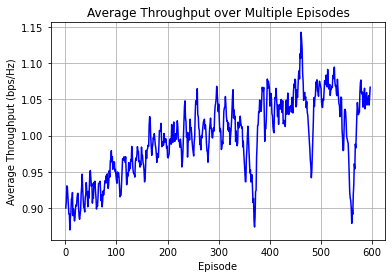

In [23]:
# import numpy as np
# import matplotlib.pyplot as plt

# Example data (replace this with your own data)
# episodes = np.arange(1, 101)  # episode numbers
# real_rewards = np.random.normal(0, 1, size=(100,))  # replace with your actual rewards

# Function to calculate a simple moving average
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Set the window size for smoothing
window_size = 5

# Calculate the moving average of real rewards
smoothed_rewards = moving_average(avg_reward_all_episodes, window_size)
# smoothed_rewards2 = moving_average(avg_reward_all_episodes2, window_size)
# smoothed_rewards3 = moving_average(avg_reward_all_episodes3, window_size)

fig1, ax1 = plt.subplots(nrows=1,ncols = 1)
# ax1.semilogy(all_epochs,avg_reward_all_episodes,'-*', alpha=0.5, label = 'Learning Rate = 0.1', color ='blue')
# ax1.semilogy(all_epochs,avg_reward_all_episodes2,'-*', alpha=0.5, label = 'Learning Rate = 0.1', color ='green')
# ax1.semilogy(all_epochs,avg_reward_all_episodes3,'-*', alpha=0.5, label = 'Learning Rate = 0.1', color ='red')
ax1.set_xlabel(r'Episode')
ax1.set_ylabel(r'Average Throughput (bps/Hz)')
ax1.set_title('Average Throughput over Multiple Episodes')
plt.grid(True)


# Plot the original real rewards with reduced opacity
# plt.plot(episodes, real_rewards, label='Real Rewards', color='blue', alpha=0.5)

# Plot the smoothed rewards
plt.plot(all_epochs[:-window_size+1], smoothed_rewards, label=f'Smoothed Rewards (Window Size={window_size})', color='blue')
# plt.plot(all_epochs[:-window_size+1], smoothed_rewards2, label=f'Smoothed Rewards (Window Size={window_size})', color='green')
# plt.plot(all_epochs[:-window_size+1], smoothed_rewards3, label=f'Smoothed Rewards (Window Size={window_size})', color='red')
# ax1.legend(['Round Robin', 'Static', 'Random'])
# Add labels and legend
# plt.xlabel('Episode')
# plt.ylabel('Reward')
# plt.title('Average Reward vs Episode with Smoothed Rewards')
# plt.legend()

# Show the plot
# plt.show()

save_results_to = 'C:/Users/Zunayeed/Desktop/PhD/WICL/NSF-AoF Project/Simulation BC EH/New Plots/Throughput/'
plt.savefig(save_results_to + 'Avg_Throughput_3Strategies_200S_600E_10channels.png', dpi = 300)
# plt.savefig('Avg_Throughput_Static_400S_200E.png')

### for debugging ###

In [24]:
f = 900e6
fJ = 900e6

# **** for path loss ****

# P_J = 20
# Pt_dBm = 10*math.log10(P_J*1000) #selecting random jamming power between 1W - 4W
# Gt_dBi = 1 #Gain of the Tx antenna in dBi 
# Gr_dBi = 1 #Gain of the Rx antenna in dBi
# d0 = 1 #reference distance of receiver from the transmitter in meters
# d = 10 # 
# dJ = 2 #distance between Tx and Rx
# L = 1 #Other System Losses, for no Loss case L=1
# sigma=2 #Standard deviation of log Normal distribution (in dB)
# n=2 #
# APBD_path_loss_dB = logNormalShadowing(Pt_dBm,Gt_dBi,Gr_dBi,f,d0,d,L,sigma,n)
# jammer_path_loss_dB = logNormalShadowing(Pt_dBm,Gt_dBi,Gr_dBi,fJ,d0,dJ,L,sigma,n)
# print('APBD Path Loss in dB: ',APBD_path_loss_dB)
# print('Jammer Path Loss in dB: ',jammer_path_loss_dB)

# **** for gain ****

H = APBD_ChannelGain(f)
JBD = JBD_ChannelGain(fJ)
JAP = JAP_ChannelGain(fJ)
print('AP - BD Channel Gain: ',H)
#print('AP - BD distance: ',d)
print('Jammer - AP Channel Gain: ',JAP)
print('Jammer - BD Channel Gain: ',JBD)
#print('Jammer - AP/BD Distance: ',dJ)

AP - BD Channel Gain:  8.340774458617567e-05
Jammer - AP Channel Gain:  0.0003432371160596014
Jammer - BD Channel Gain:  0.00012553090698975996


In [25]:
n = -1 
for i in range(20):
    #Jammer Strategy: Static Jammer
    (P_J,f_J,n) = Jammer(n,K_ch)

    k = 0 # AP channel 
    f_k = Fc + (k*deltaf)

    P_R = ((s_bb**2)*P_T*(APBD_ChannelGain(f_k))**2) 
    P_R_AP = sum(P_R)/(N*L) #Average Received Power
    Noise_variance = (P_R_AP)/(10**(20/10)) #Desired SNR assumed to be 20dB
    unwanted_signal = 1*(f_k == f_J)*P_J*JAP_ChannelGain(f_J) + loopback_Channel() + Noise_variance*abs(complex_noise(0, 1, N*L))
    ### 1*(f_k == f_J)*... => 0 if f_K is not equal to f_J
    P_N = sum(unwanted_signal)/(N*L)
    SNR =  P_R_AP/P_N
    SNR_dB = 10*math.log(SNR)
    # #print(SNR)
    throughput = math.log2(1+SNR) #SNR in linear scale will give throughput in bps; Here, throughput (reward) is in bps/Hz
    # print(unwanted_signal)
    # print(y_AP_squared)
    print('AP Channel: ',f_k)
    print('Jammer Channel: ',f_J)
#     print('Received Power: ',P_R_AP)
#     print('Noise Power: ',P_N)
#     print('SNR: ',SNR)
    print('SNR in dB: ',SNR_dB)
#     print('Throughput: ',throughput)


AP Channel:  900000000.0
Jammer Channel:  900000000.0
SNR in dB:  -153.54871218856442
AP Channel:  900000000.0
Jammer Channel:  910000000.0
SNR in dB:  -5.066913646135309
AP Channel:  900000000.0
Jammer Channel:  920000000.0
SNR in dB:  -1.9247384191421777
AP Channel:  900000000.0
Jammer Channel:  930000000.0
SNR in dB:  8.414854291204648
AP Channel:  900000000.0
Jammer Channel:  940000000.0
SNR in dB:  -3.4438409717868796
AP Channel:  900000000.0
Jammer Channel:  950000000.0
SNR in dB:  12.901878657852759
AP Channel:  900000000.0
Jammer Channel:  960000000.0
SNR in dB:  5.611856272820972
AP Channel:  900000000.0
Jammer Channel:  970000000.0
SNR in dB:  13.294196643926997
AP Channel:  900000000.0
Jammer Channel:  980000000.0
SNR in dB:  9.099625708561494
AP Channel:  900000000.0
Jammer Channel:  990000000.0
SNR in dB:  14.048007704048388
AP Channel:  900000000.0
Jammer Channel:  900000000.0
SNR in dB:  -134.78233190457172
AP Channel:  900000000.0
Jammer Channel:  910000000.0
SNR in dB: